In [1]:
from pathlib import Path

import pandas as pd

csv_path = Path(r"E:\daneshgah\quantitative-finance-lab\data\nasdaq_all_close_volume.csv")
parquet_path = Path(r"E:\daneshgah\quantitative-finance-lab\data\nasdaq_all_close_volume.parquet")



if parquet_path.exists():
    print(f"Parquet already exists: {parquet_path}")
else:
    raw = pd.read_csv(csv_path, header=[0, 1], low_memory=False)
    flat_cols = []
    for first, second in raw.columns:
        first = str(first).strip()
        second = str(second).strip()
        if first.lower() == "date":
            flat_cols.append("Date")
        else:
            flat_cols.append(f"{first}__{second}")

    raw.columns = flat_cols
    raw["Date"] = pd.to_datetime(raw["Date"], errors="coerce")
    raw = raw.dropna(subset=["Date"]).sort_values("Date")
    raw.to_parquet(parquet_path, index=False)
    print(f"Created parquet: {parquet_path}")


Parquet already exists: E:\daneshgah\quantitative-finance-lab\data\nasdaq_all_close_volume.parquet


Universe size across rebalances: min=100, max=100, mean=100.0

Risk/Return Summary (Net)

                       CAGR  AnnVol  Sharpe    MaxDD  Calmar Sortino
Strategy                                                            
EW                   0.1454  0.2513  0.5875  -0.4616  0.3151  0.7720
MinVar (SampleCov)   0.1495  0.1583  0.8348  -0.2913  0.5133  1.0235
MinVar (LedoitWolf)  0.1341  0.1567  0.7555  -0.2921  0.4590  0.9202
MinVar (OAS)         0.1466  0.1581  0.8193  -0.2884  0.5081  1.0004
MV (SampleCov)       0.1403  0.1543  0.7997  -0.2790  0.5028  1.0140
MV (LedoitWolf)      0.1327  0.1557  0.7510  -0.2794  0.4748  0.9326
MV (OAS)             0.1397  0.1555  0.7919  -0.2802  0.4986  0.9870
Ridge MV             0.1333  0.1558  0.7543  -0.2801  0.4759  0.9347
Lasso MV             0.1327  0.1557  0.7510  -0.2794  0.4748  0.9326
MaxSharpe            0.2228  0.2978  0.7580  -0.4761  0.4679  0.9846

Trading & Stability Summary

                    Avg Turnover Total Turnover Tota

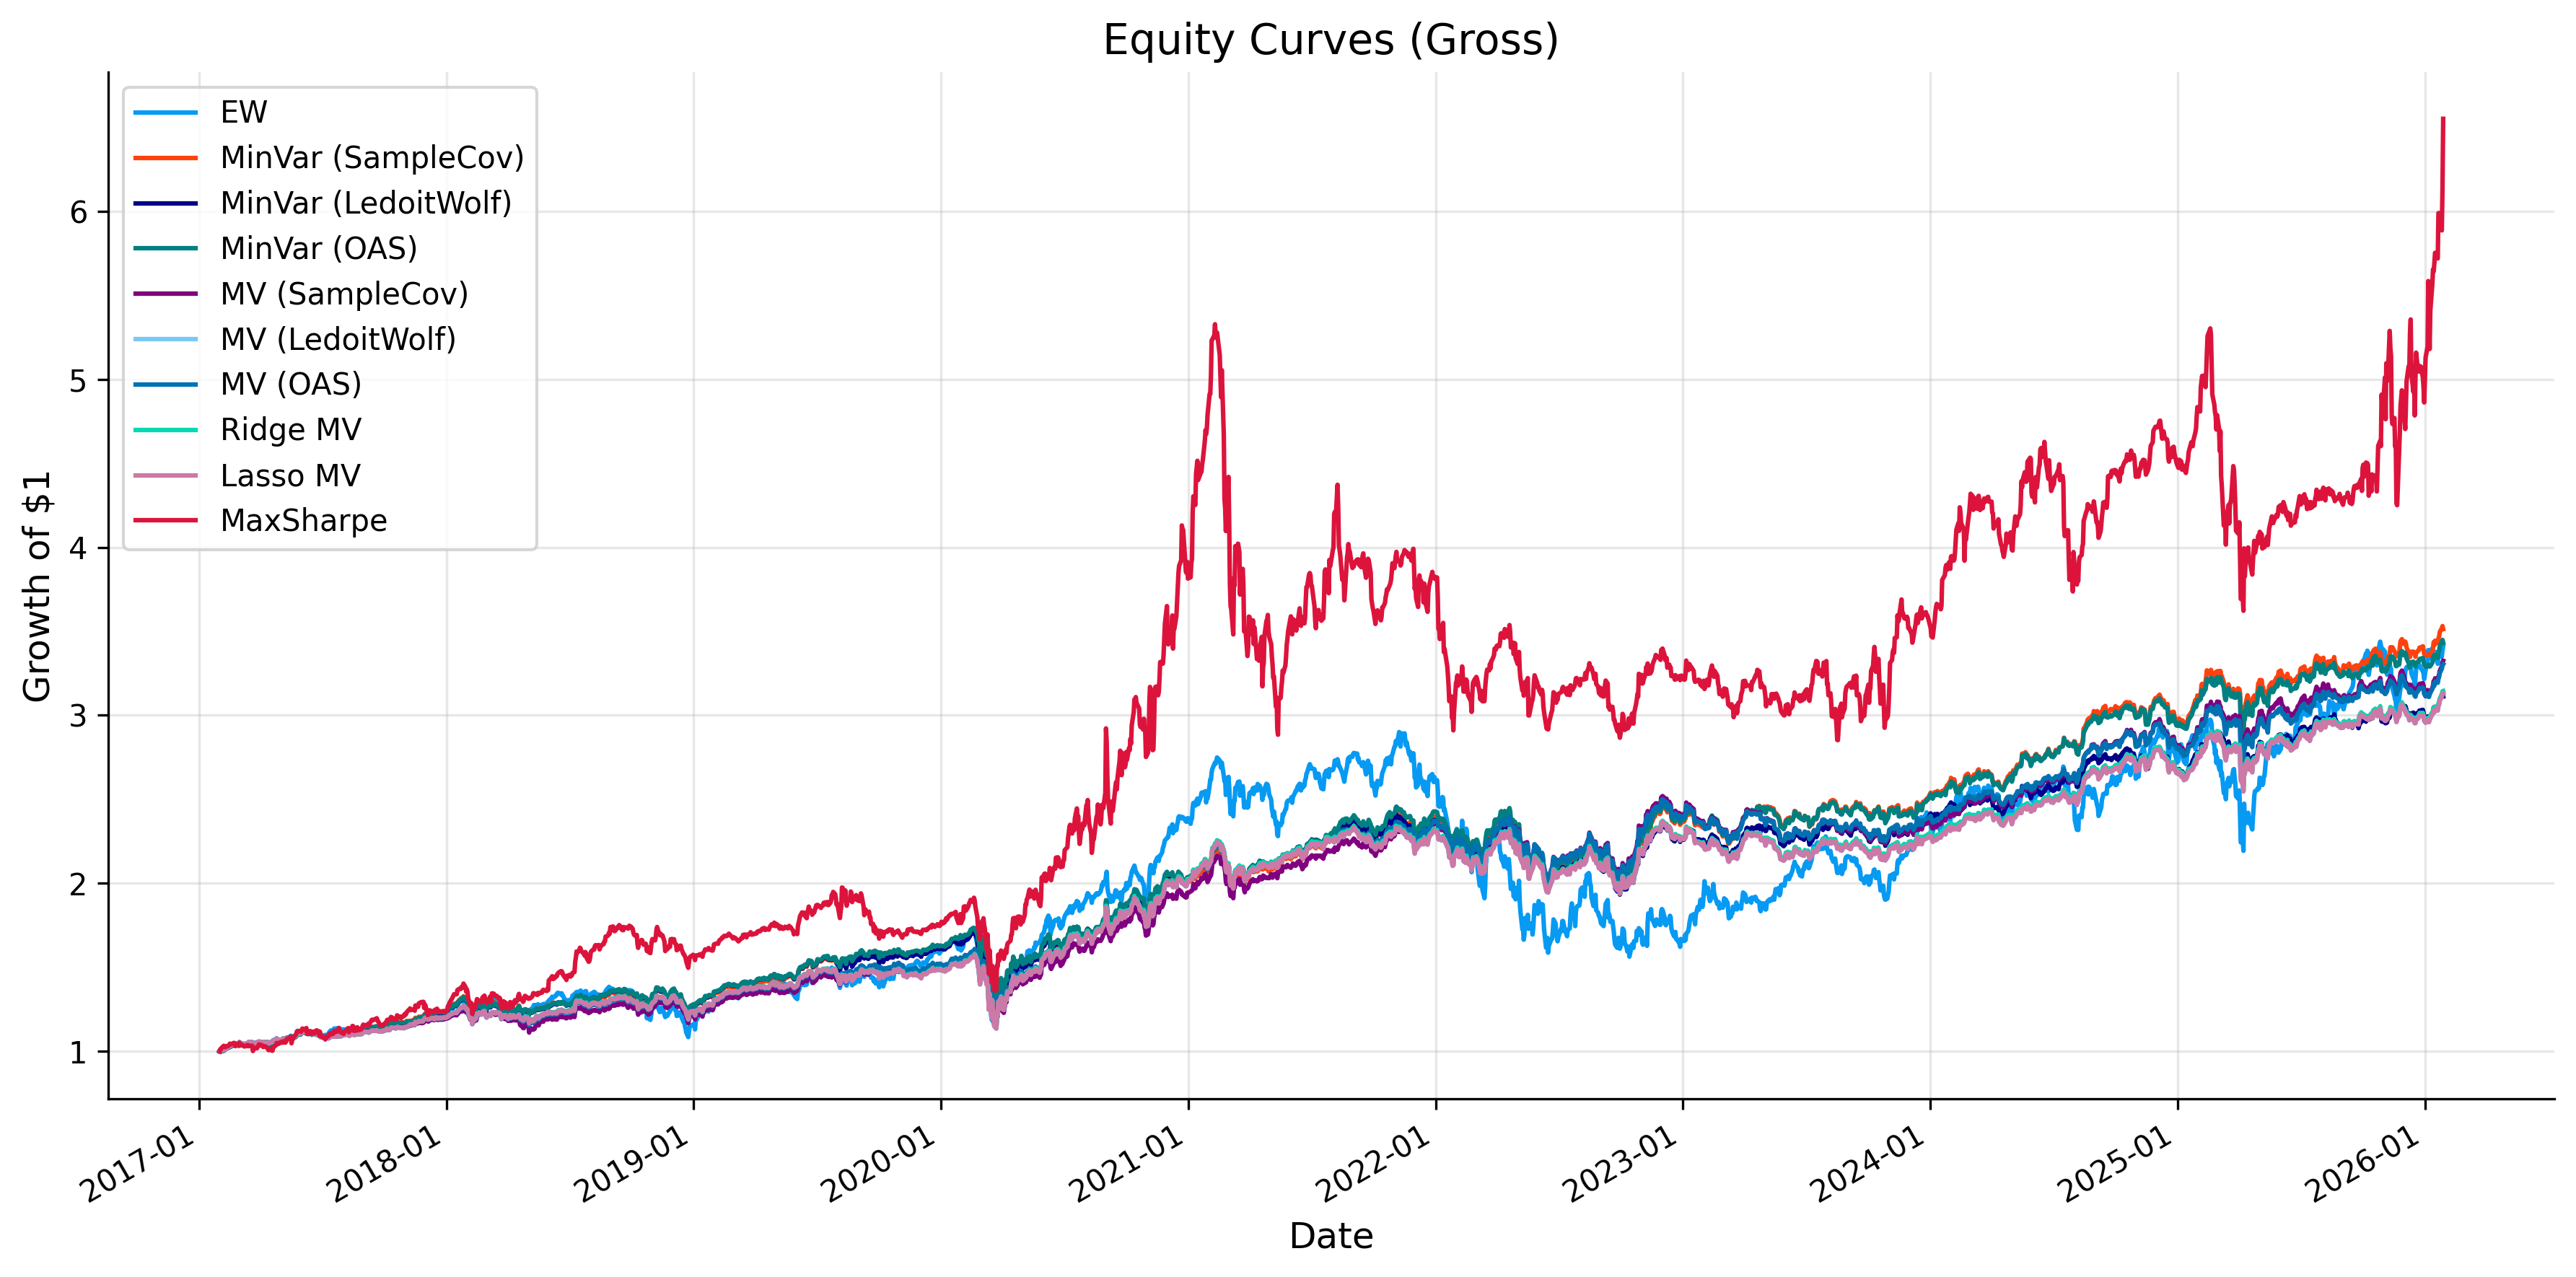

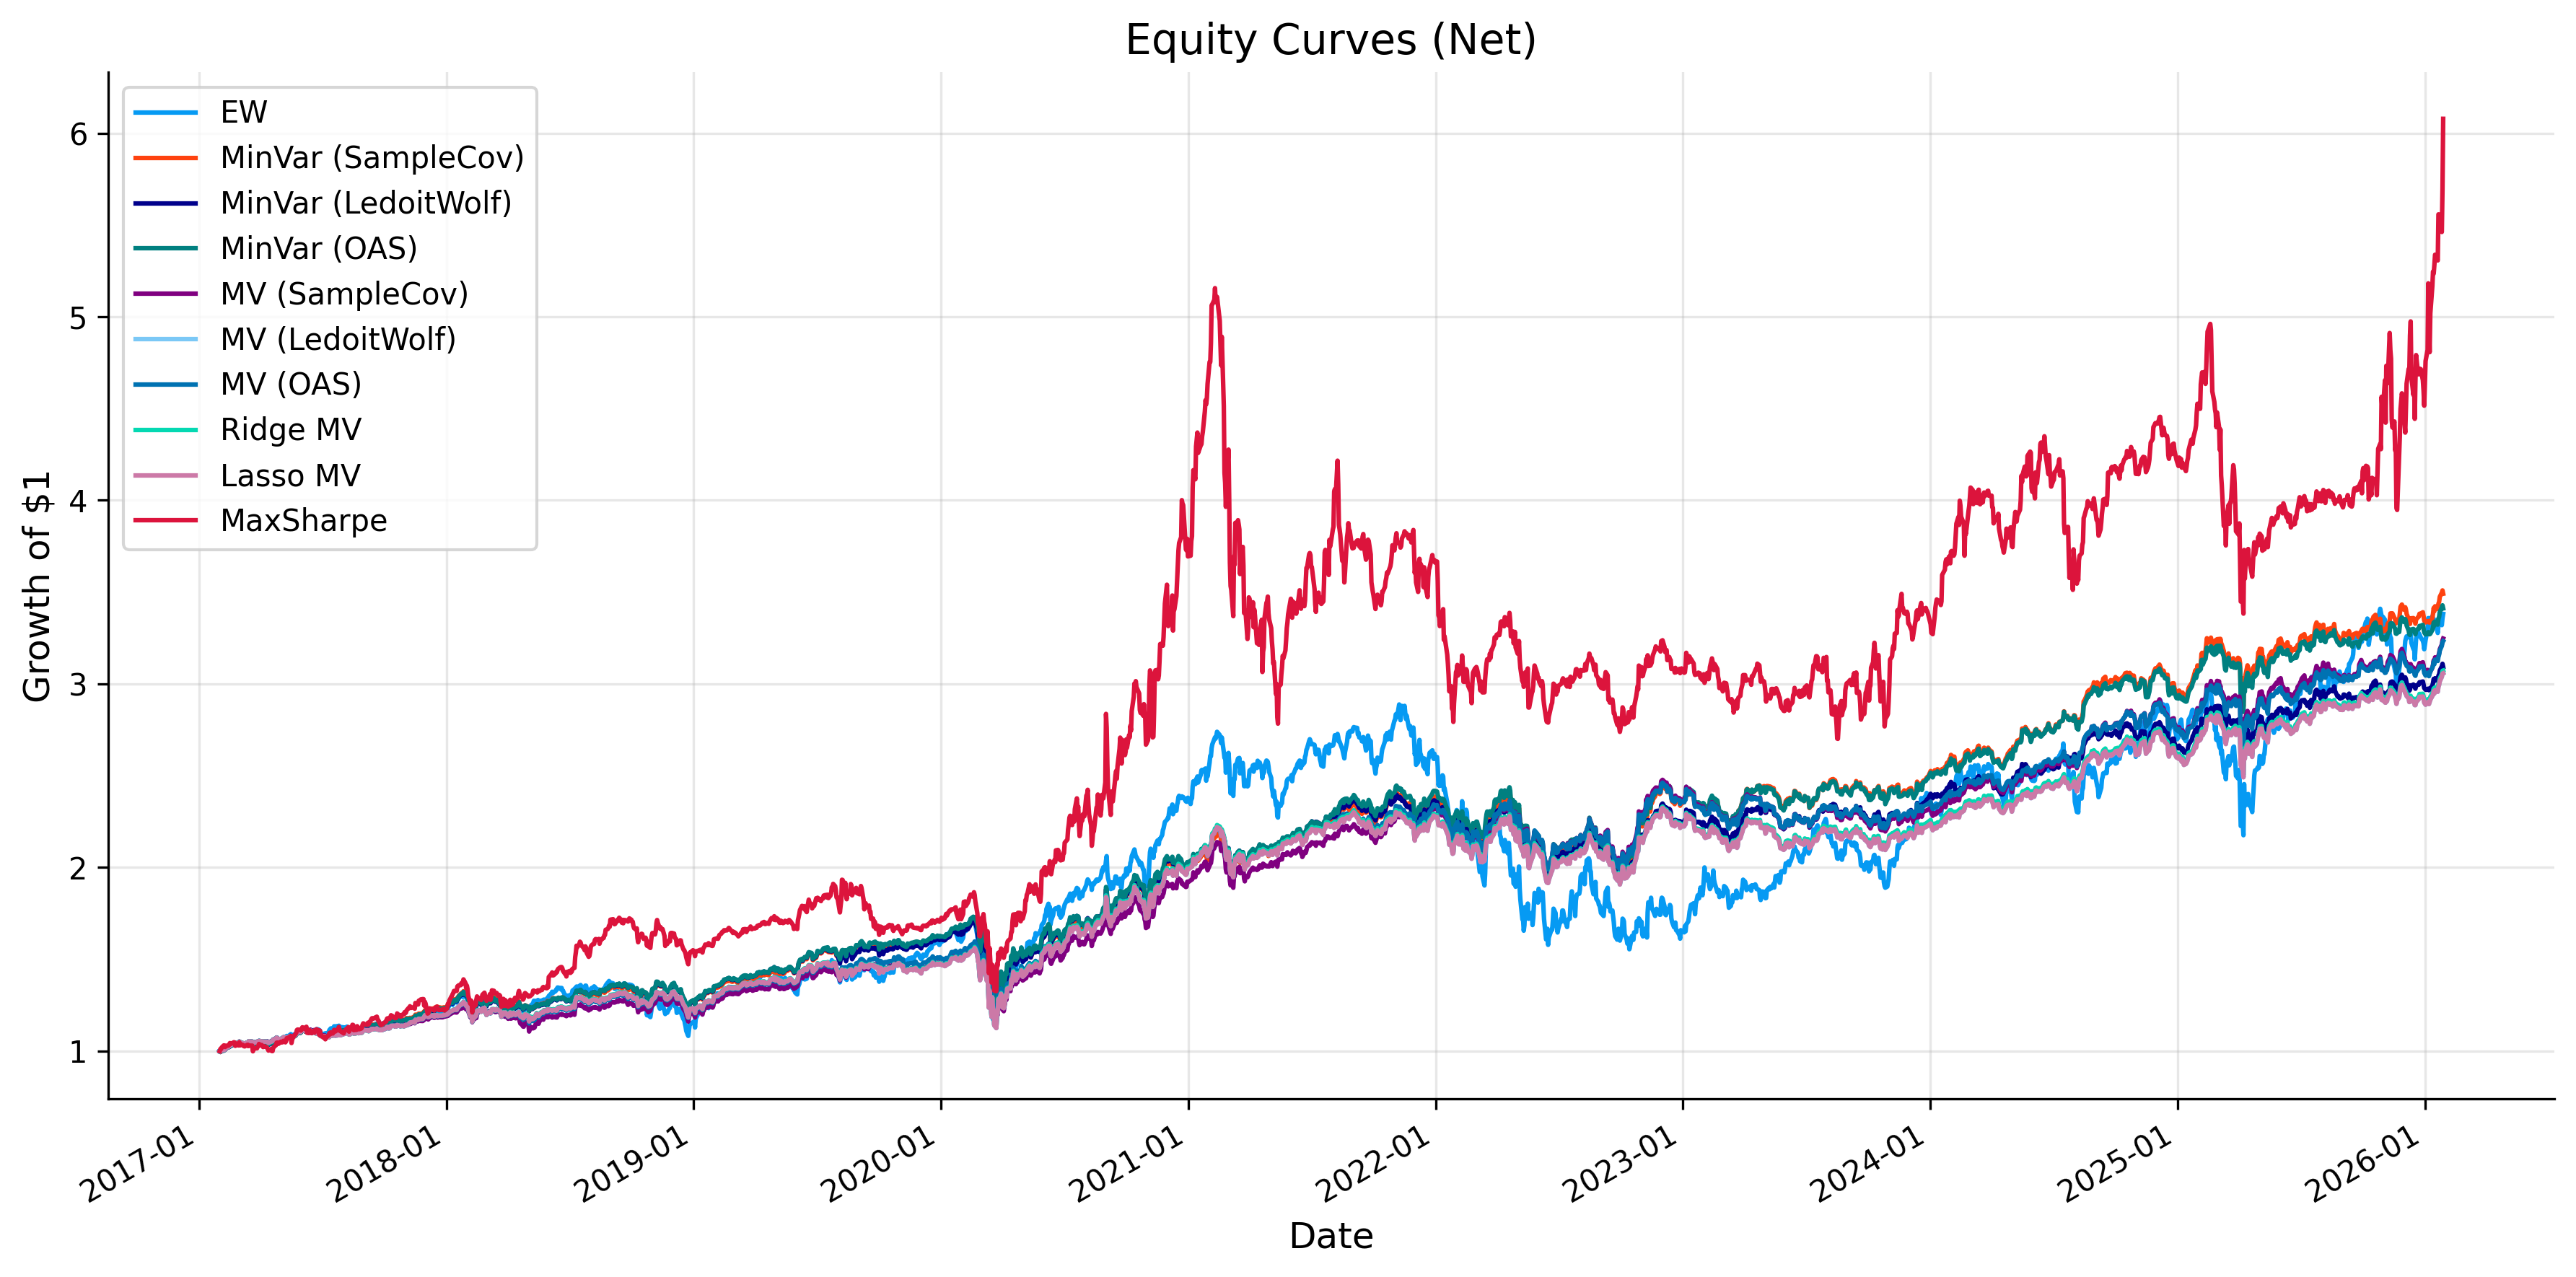

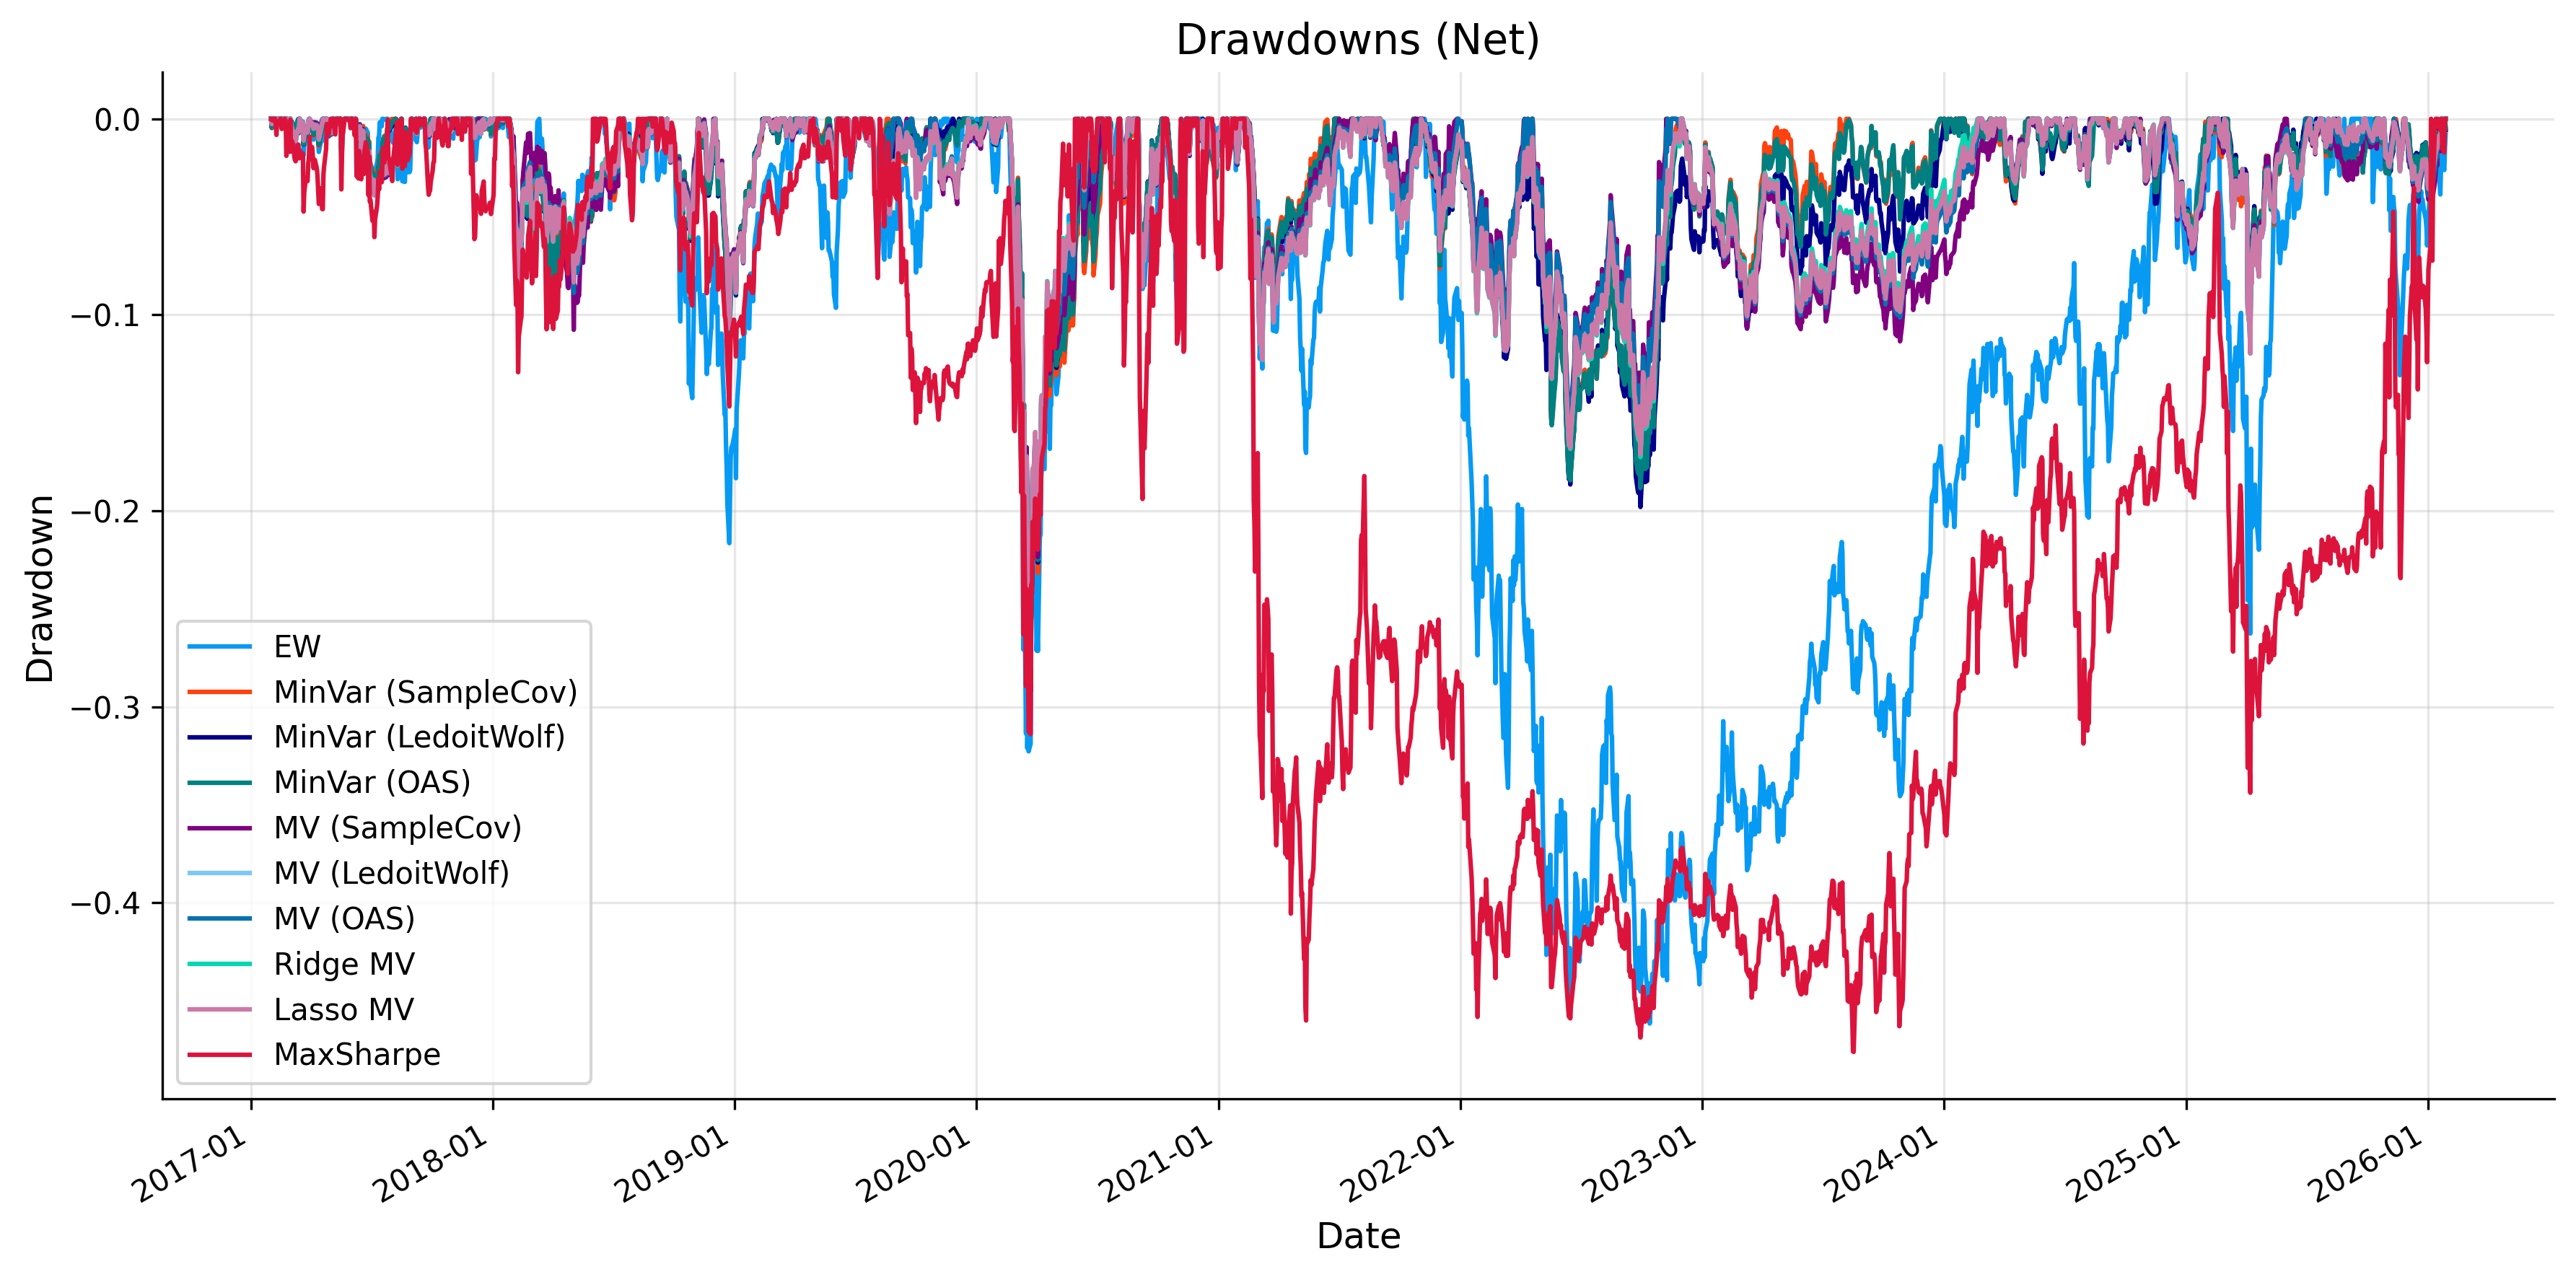

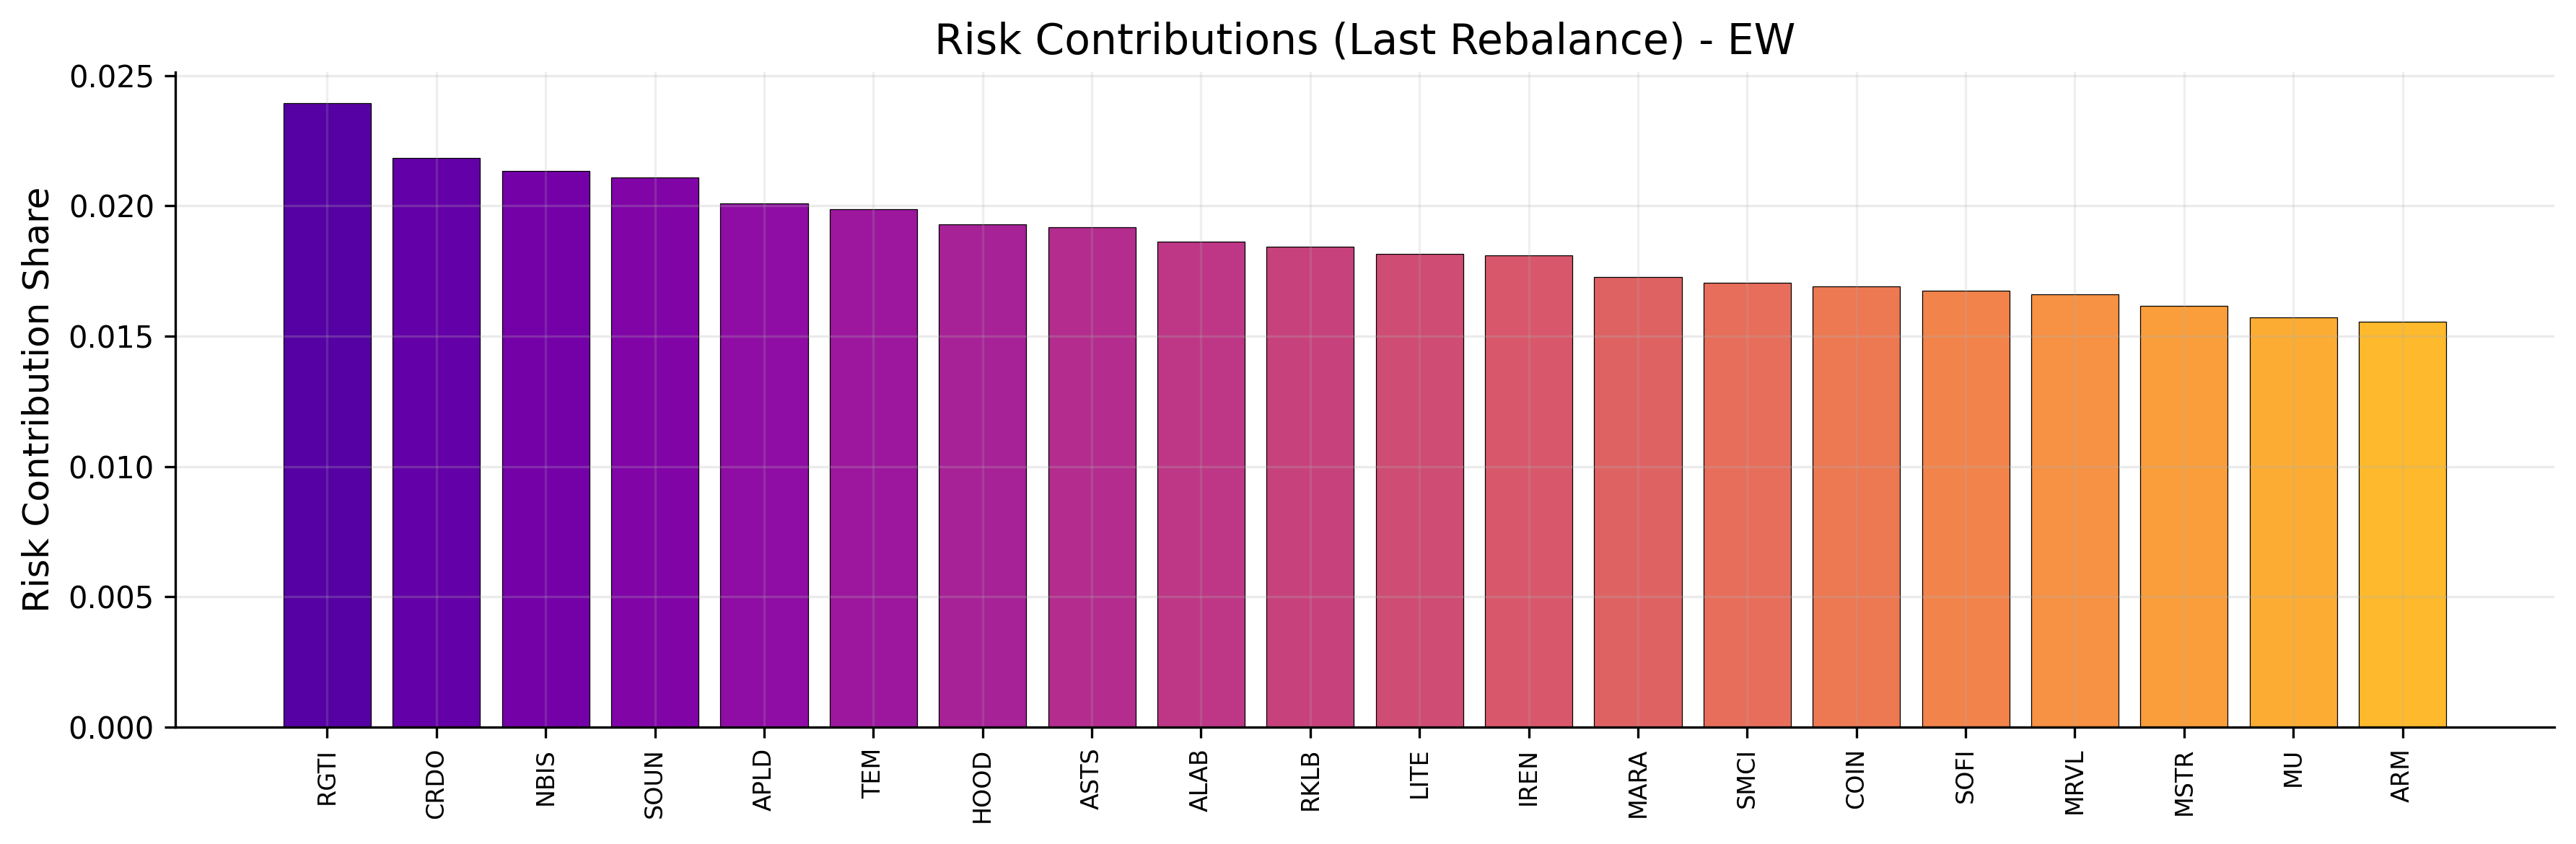

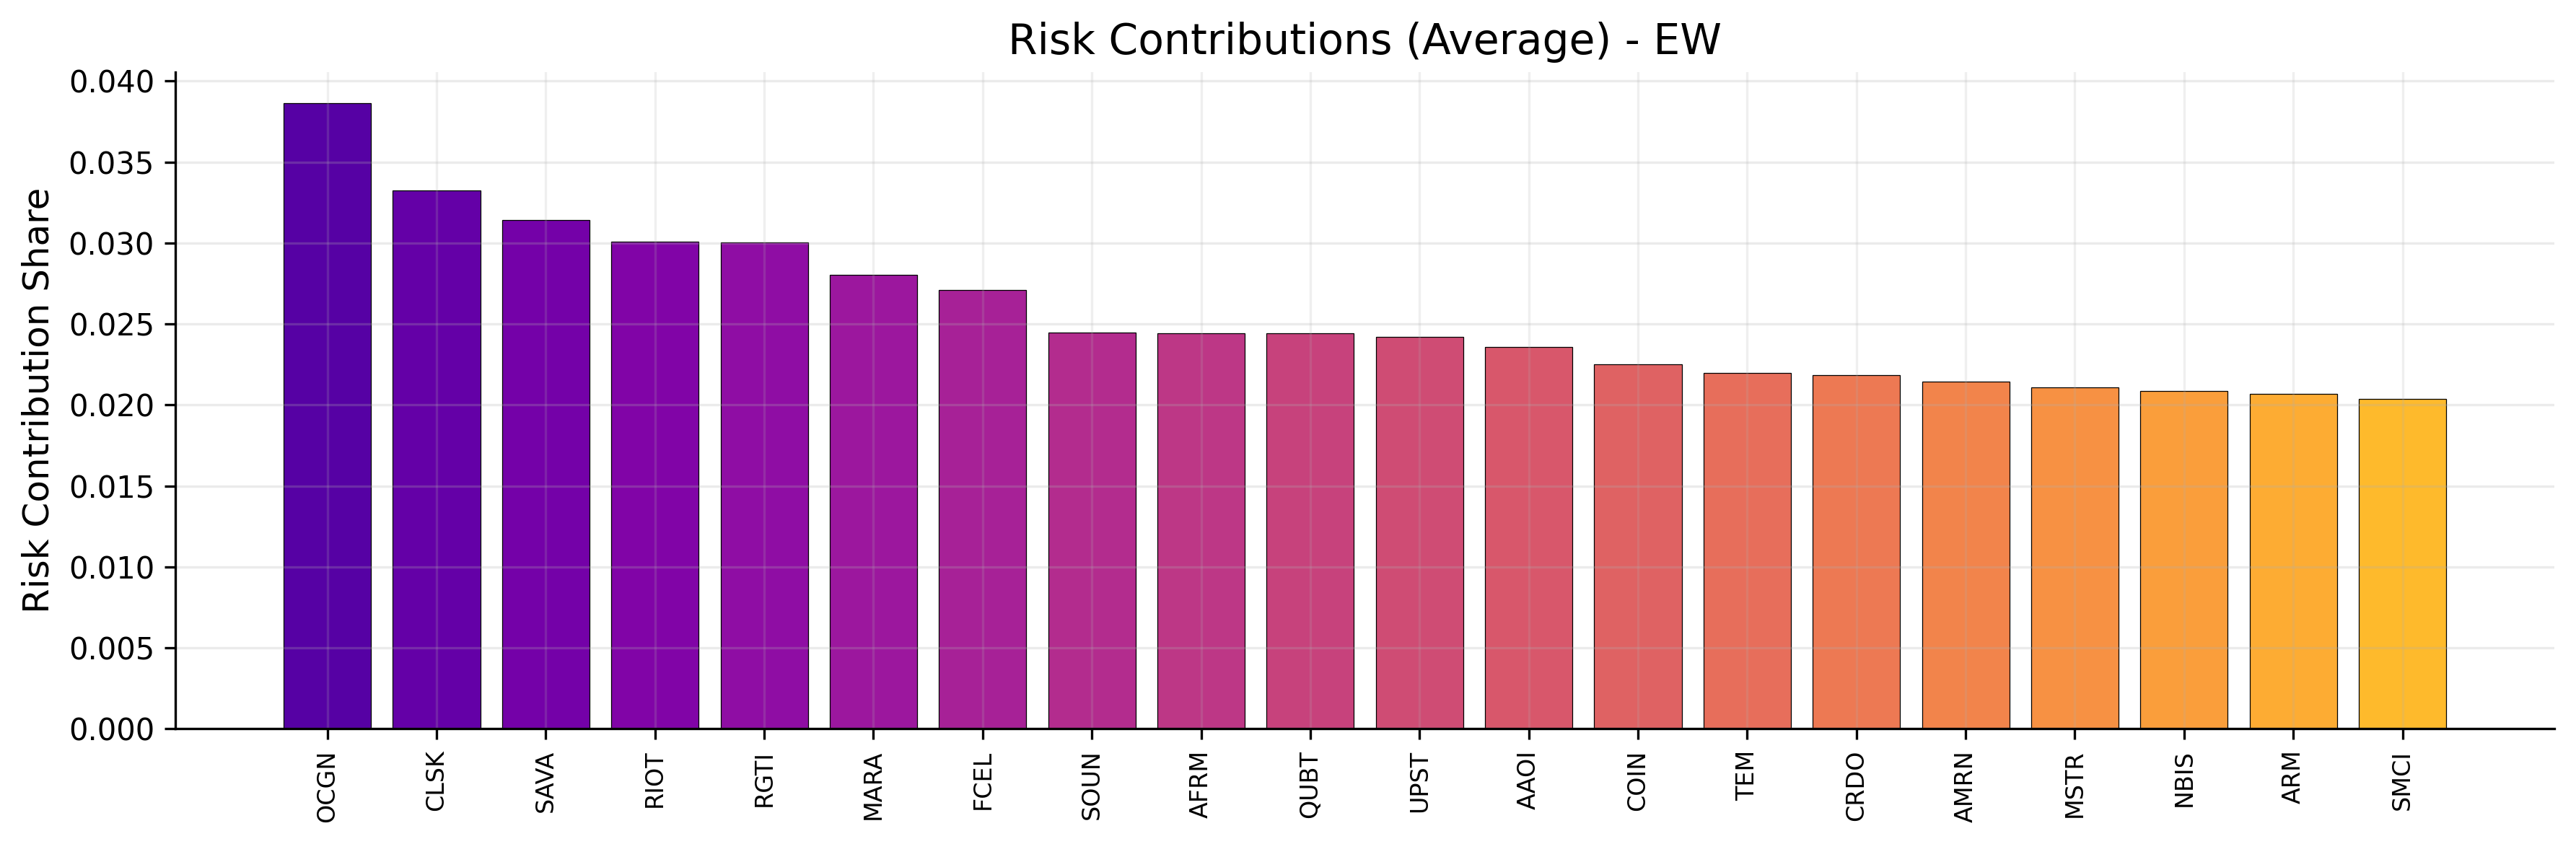

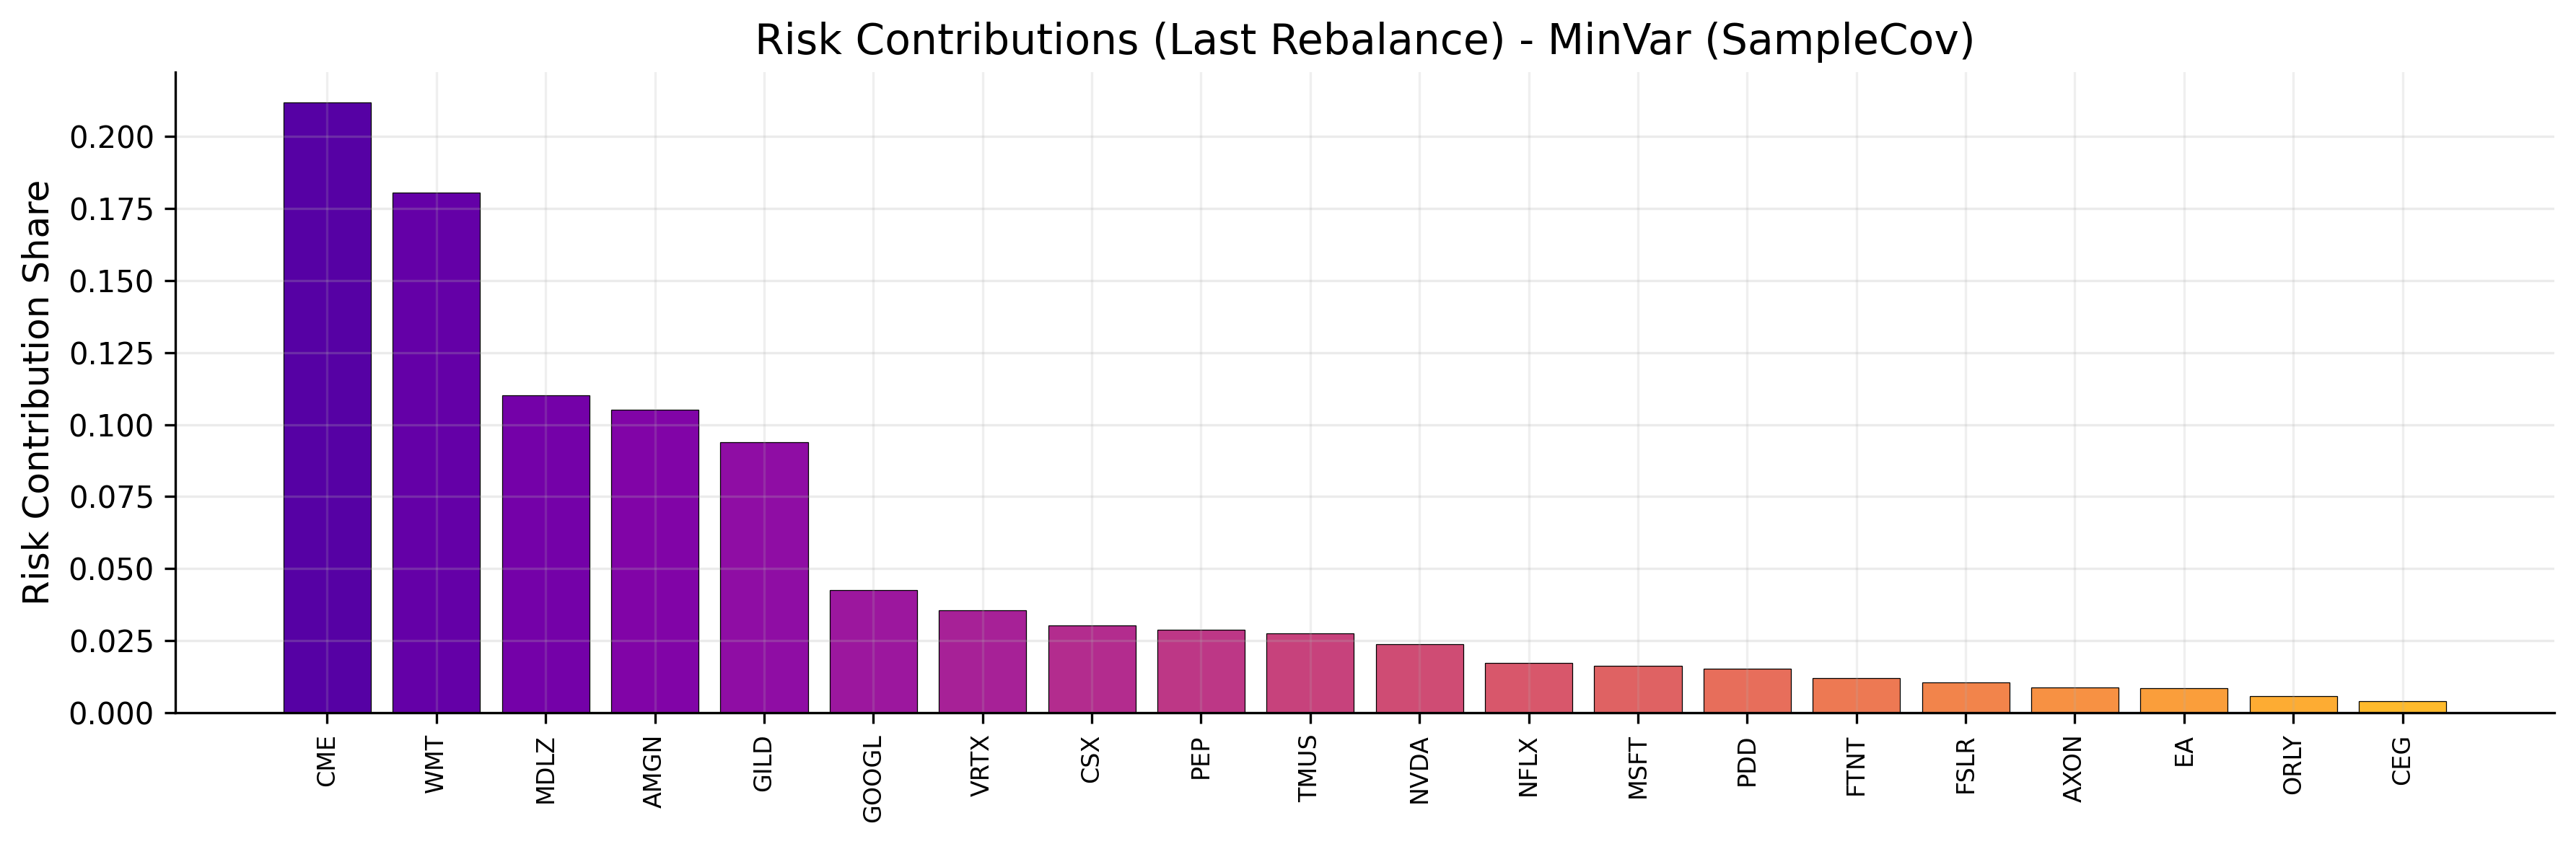

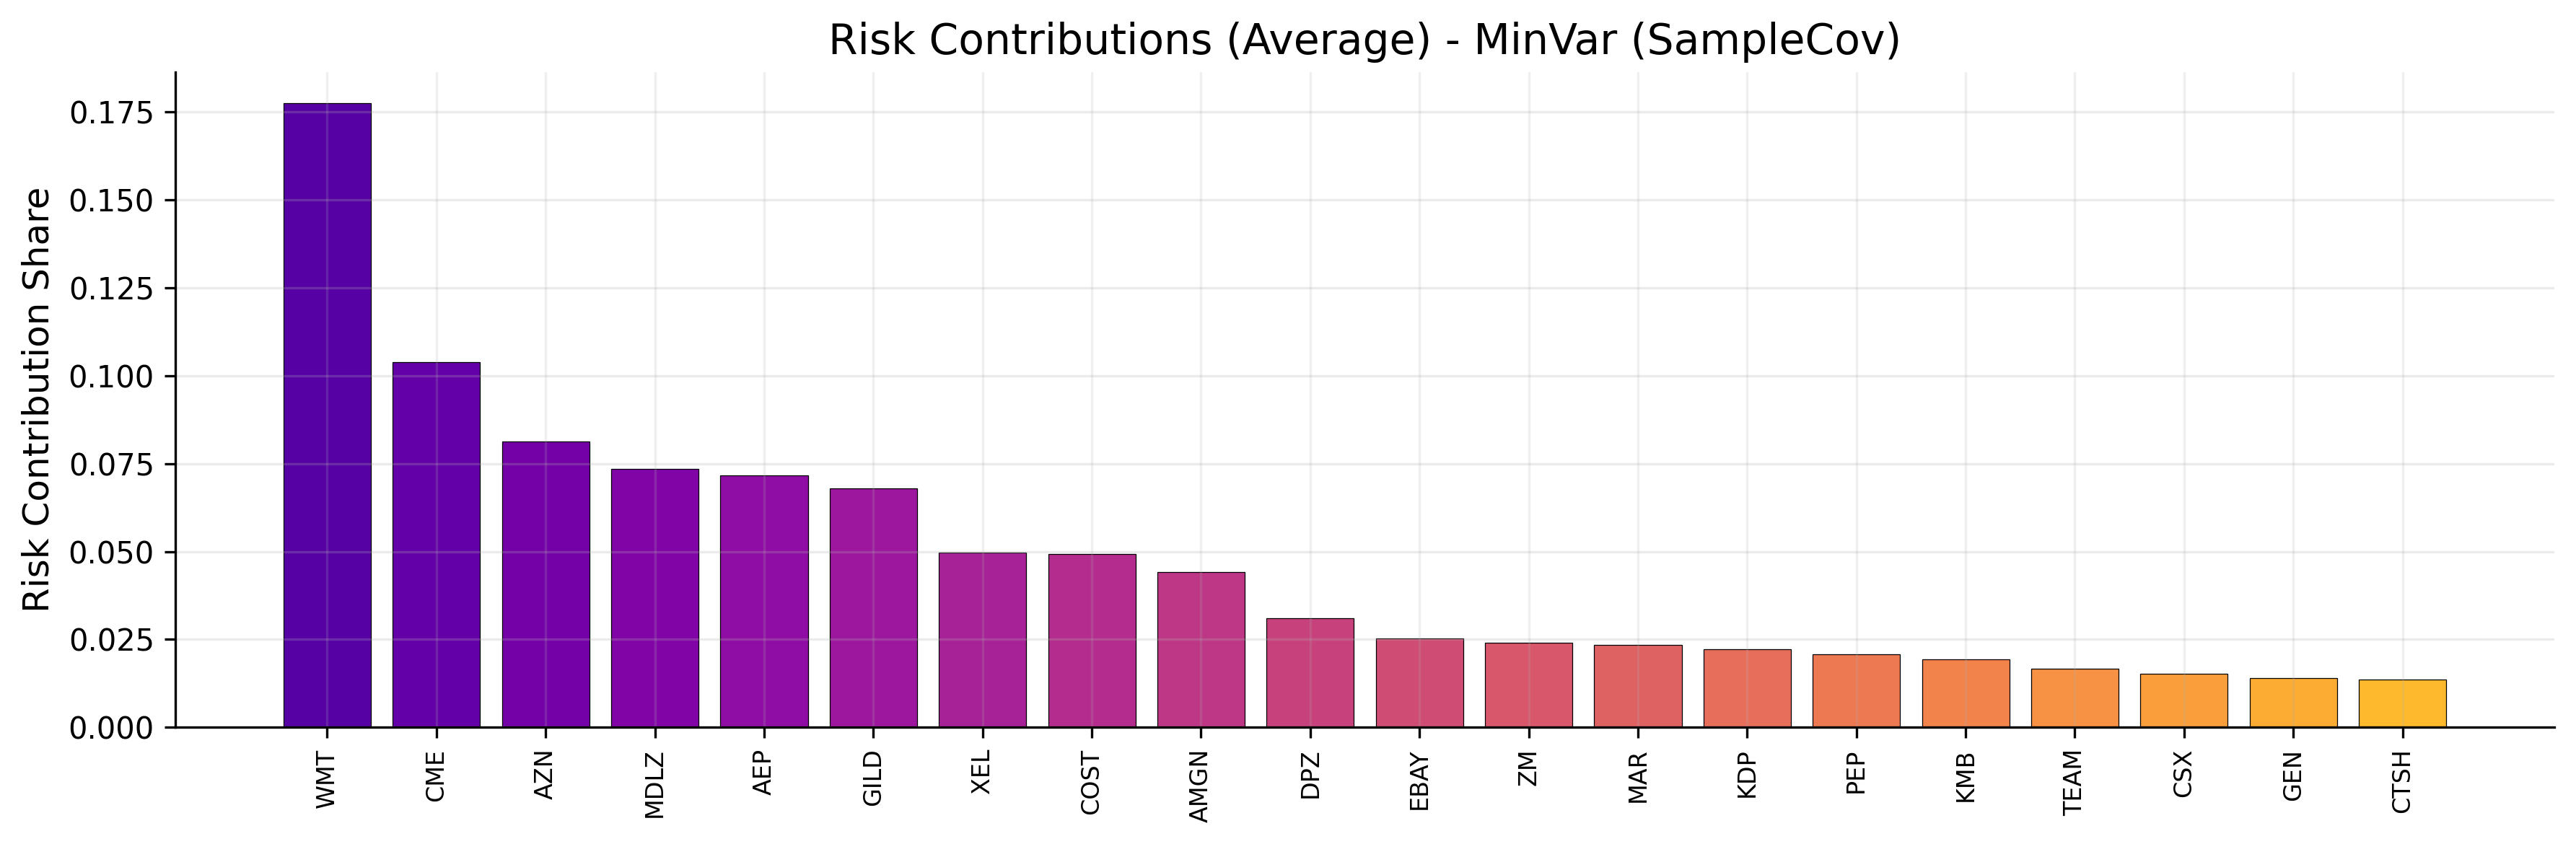

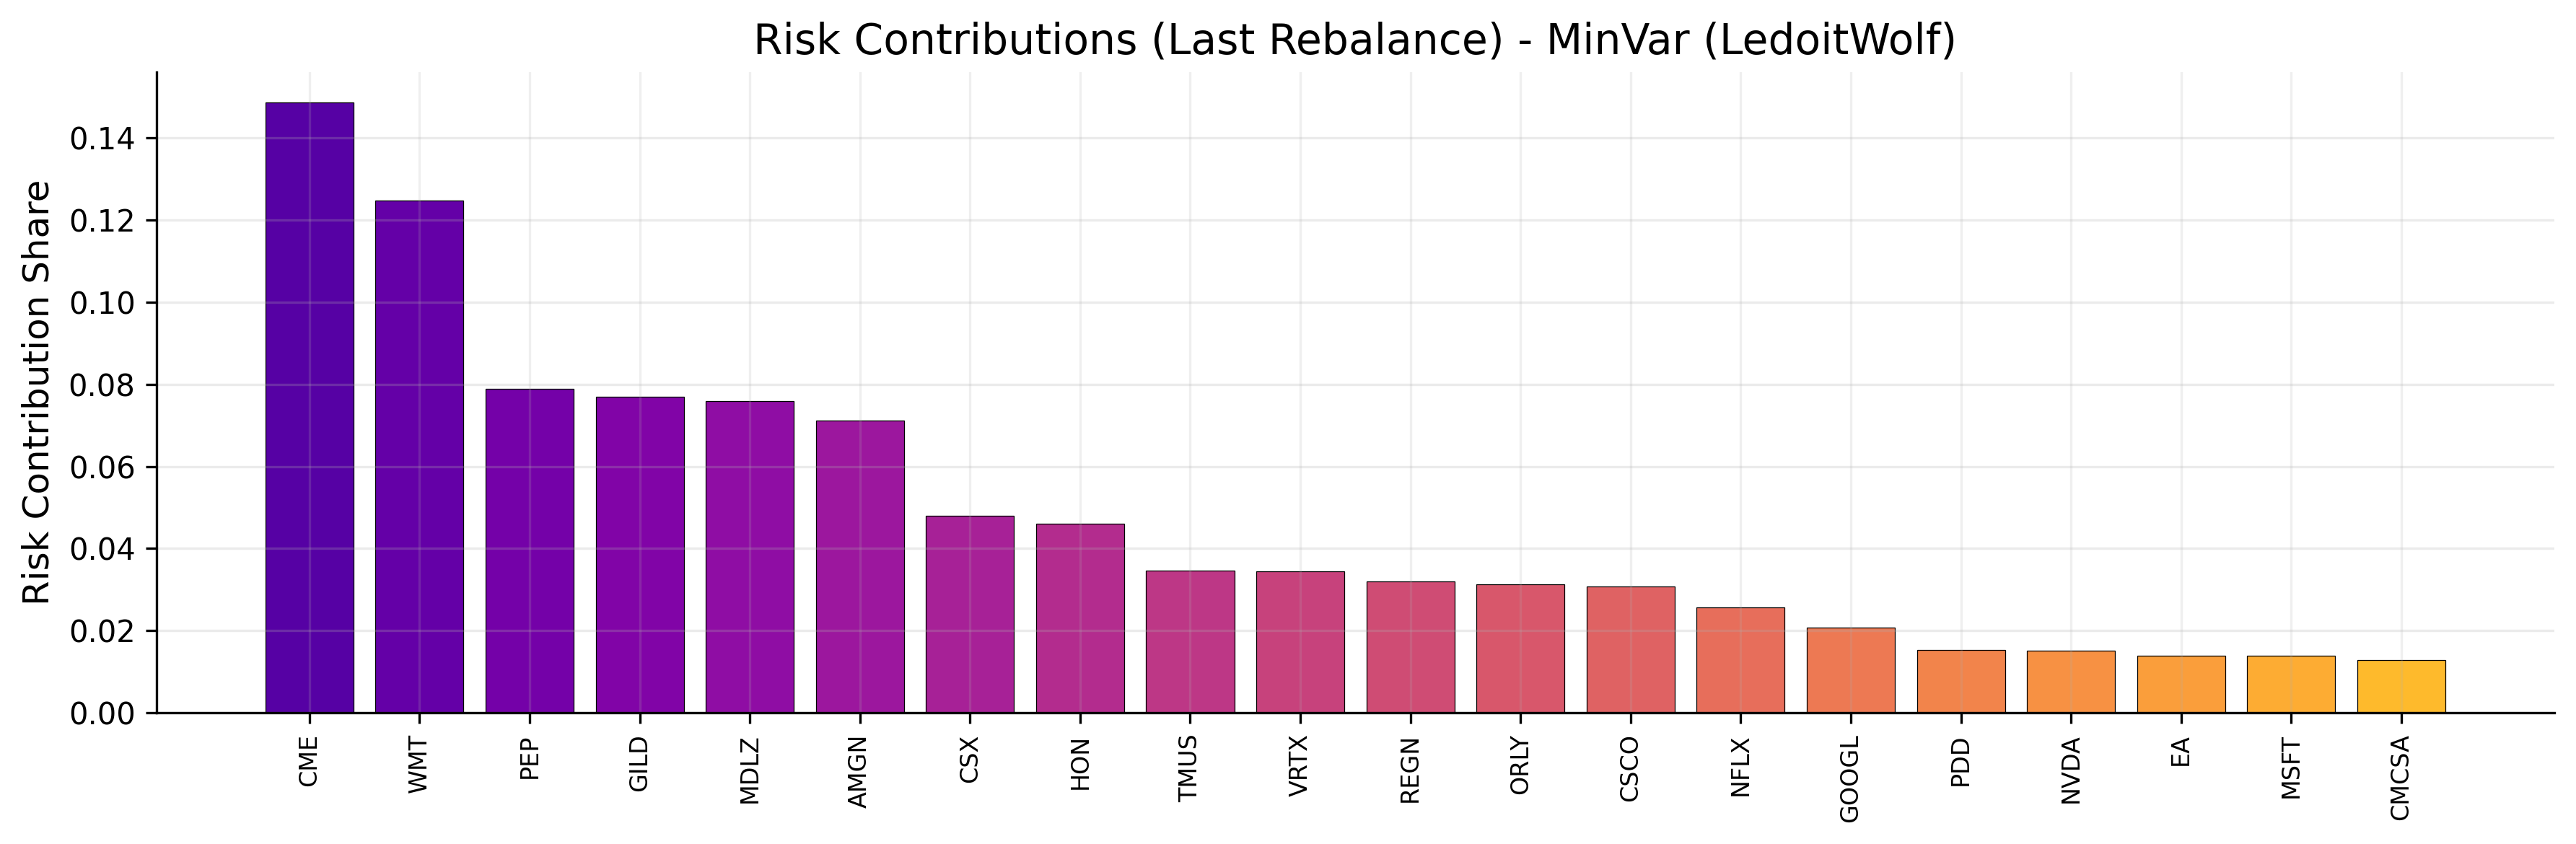

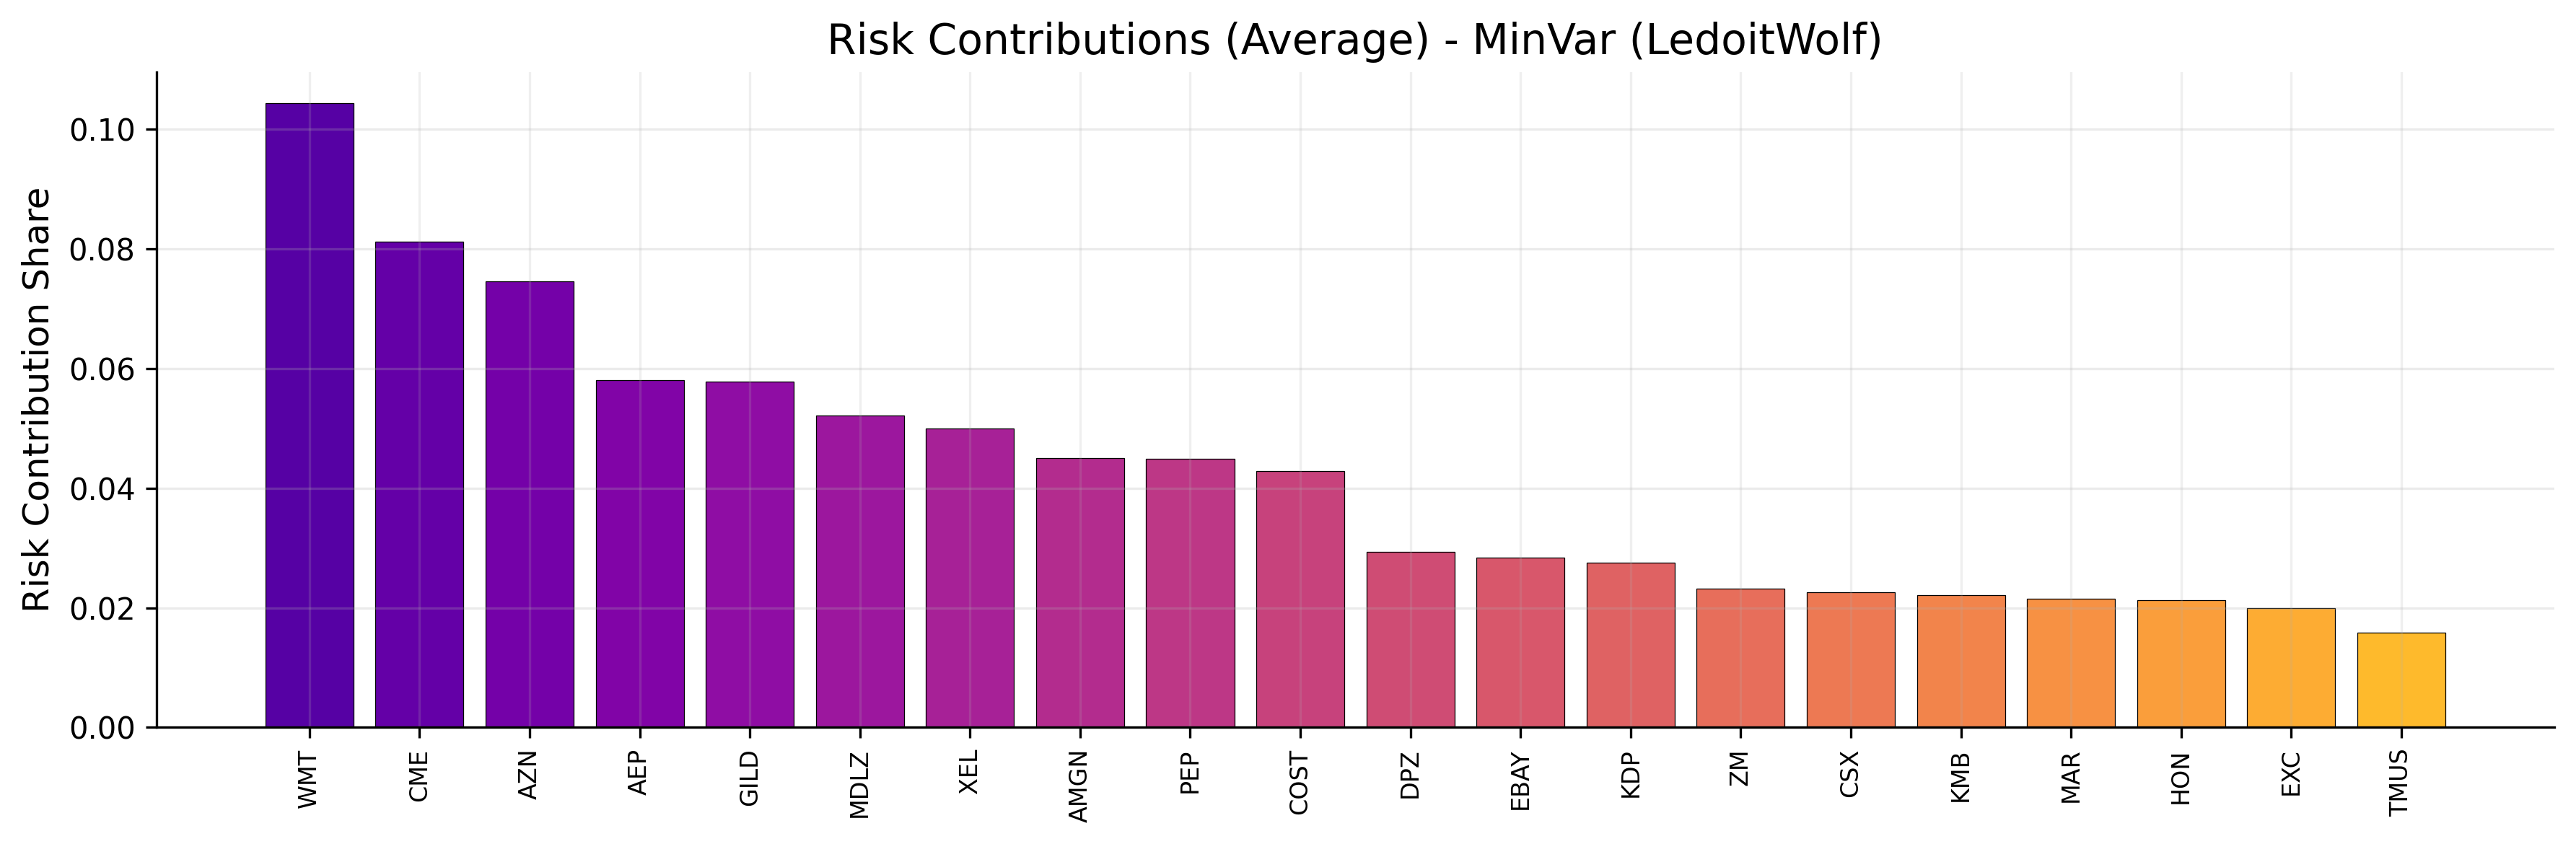

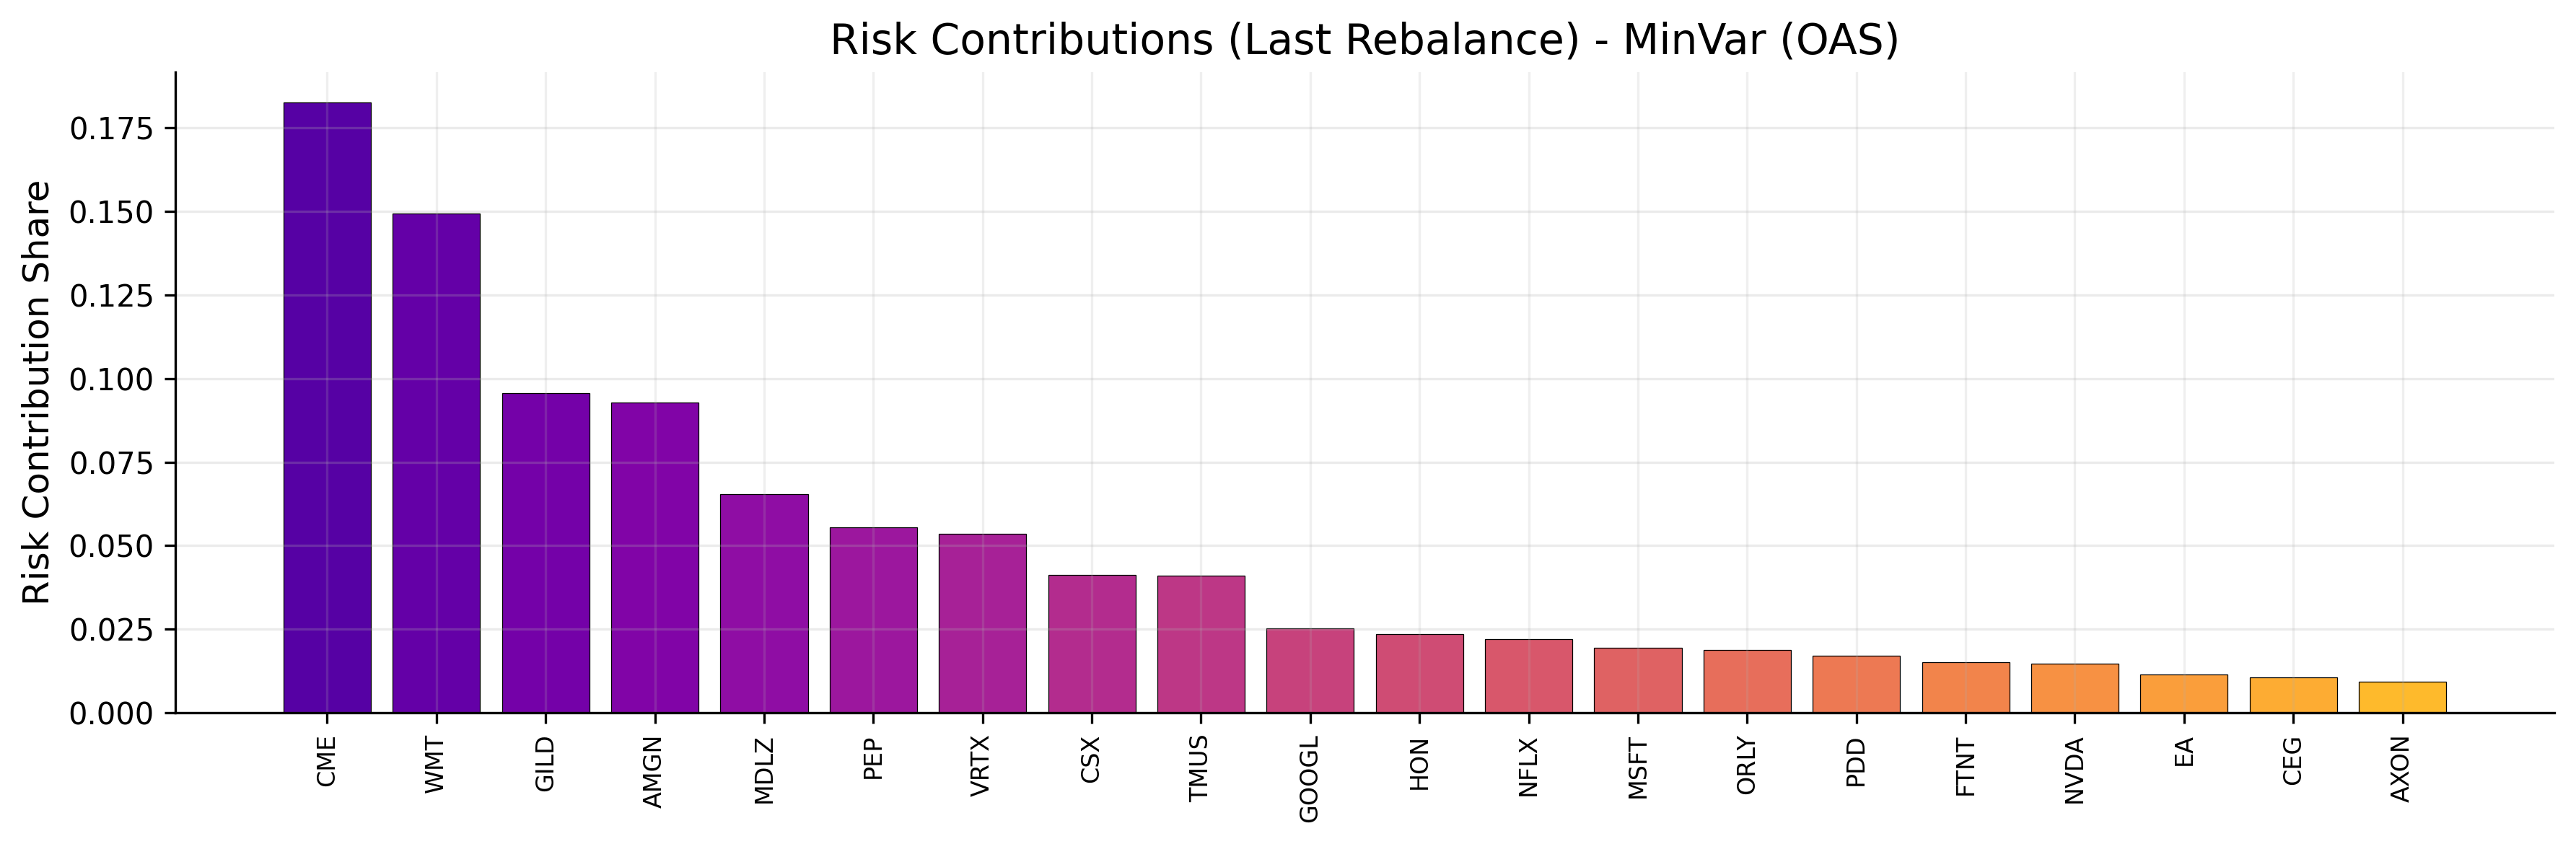

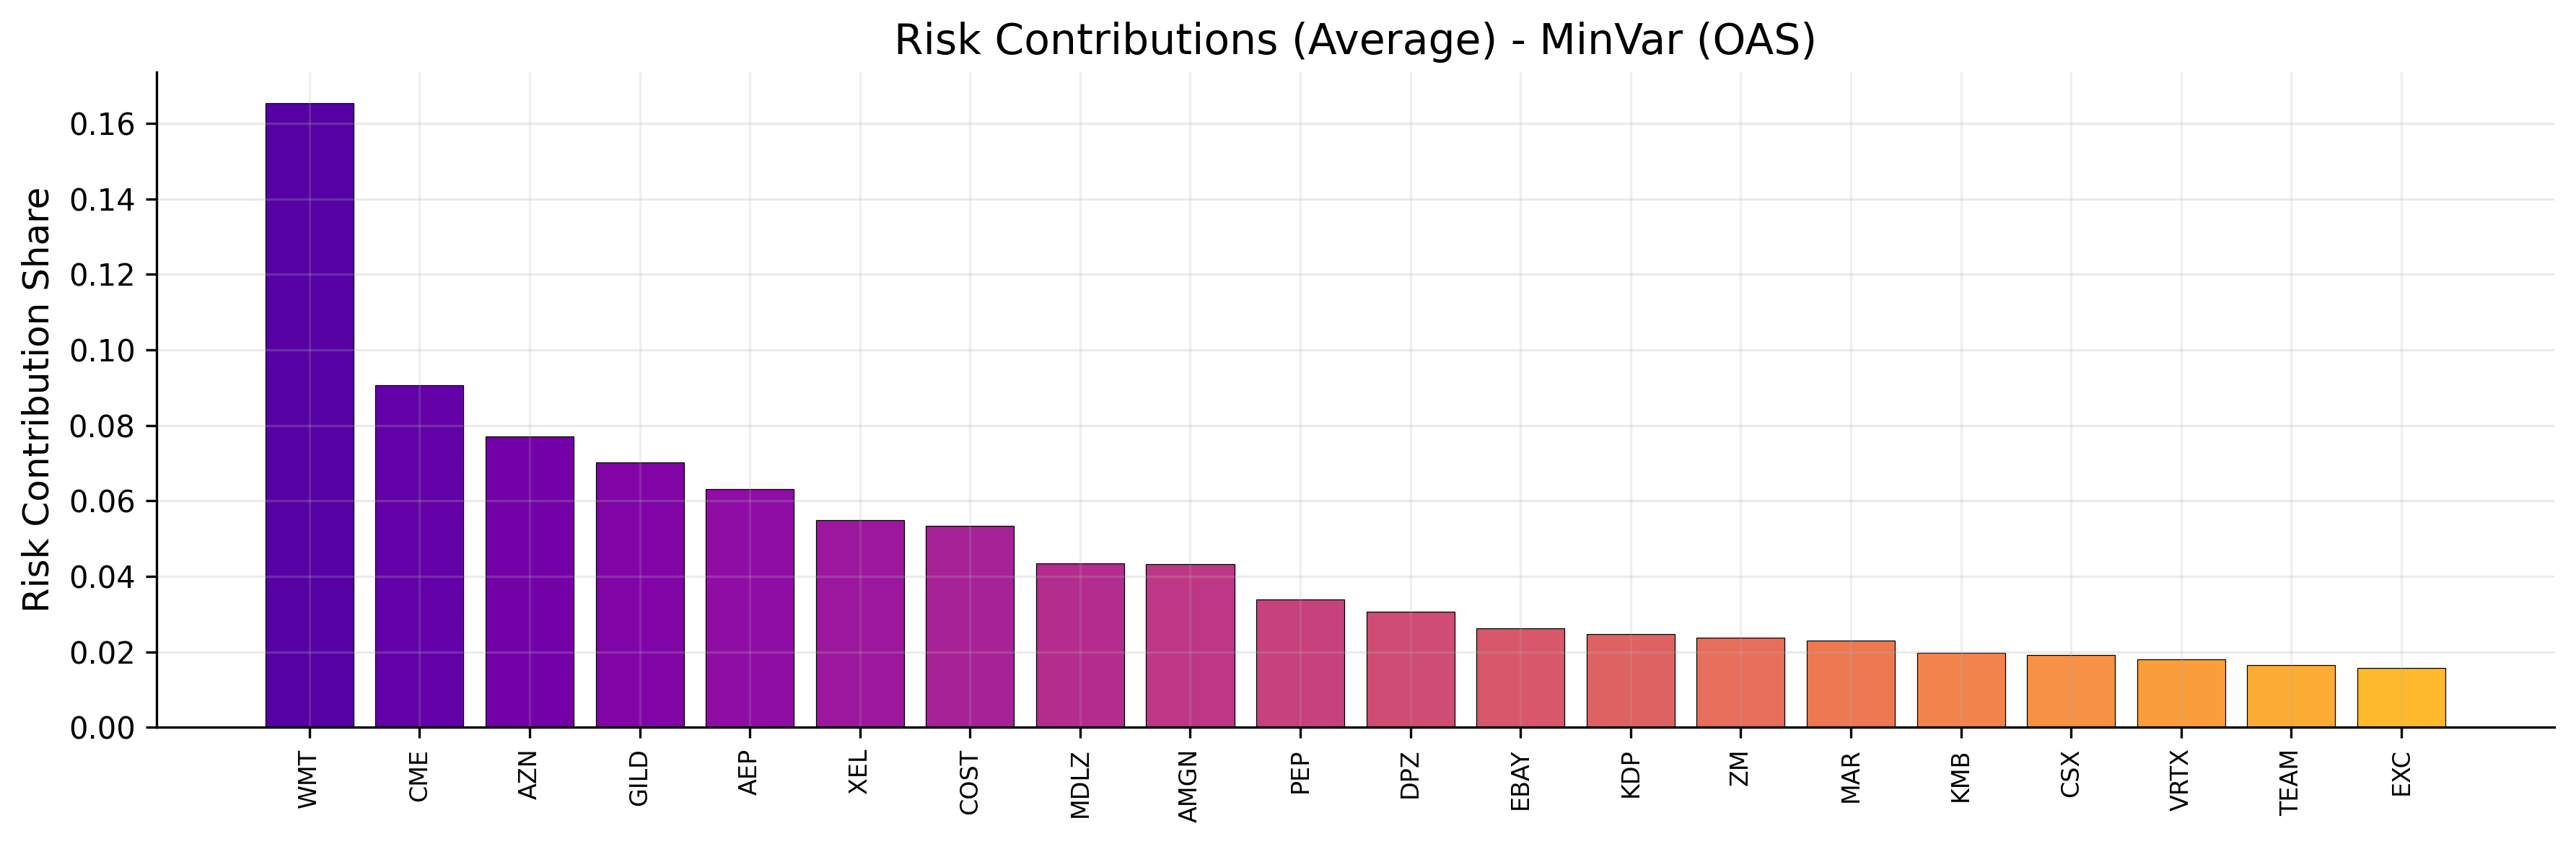

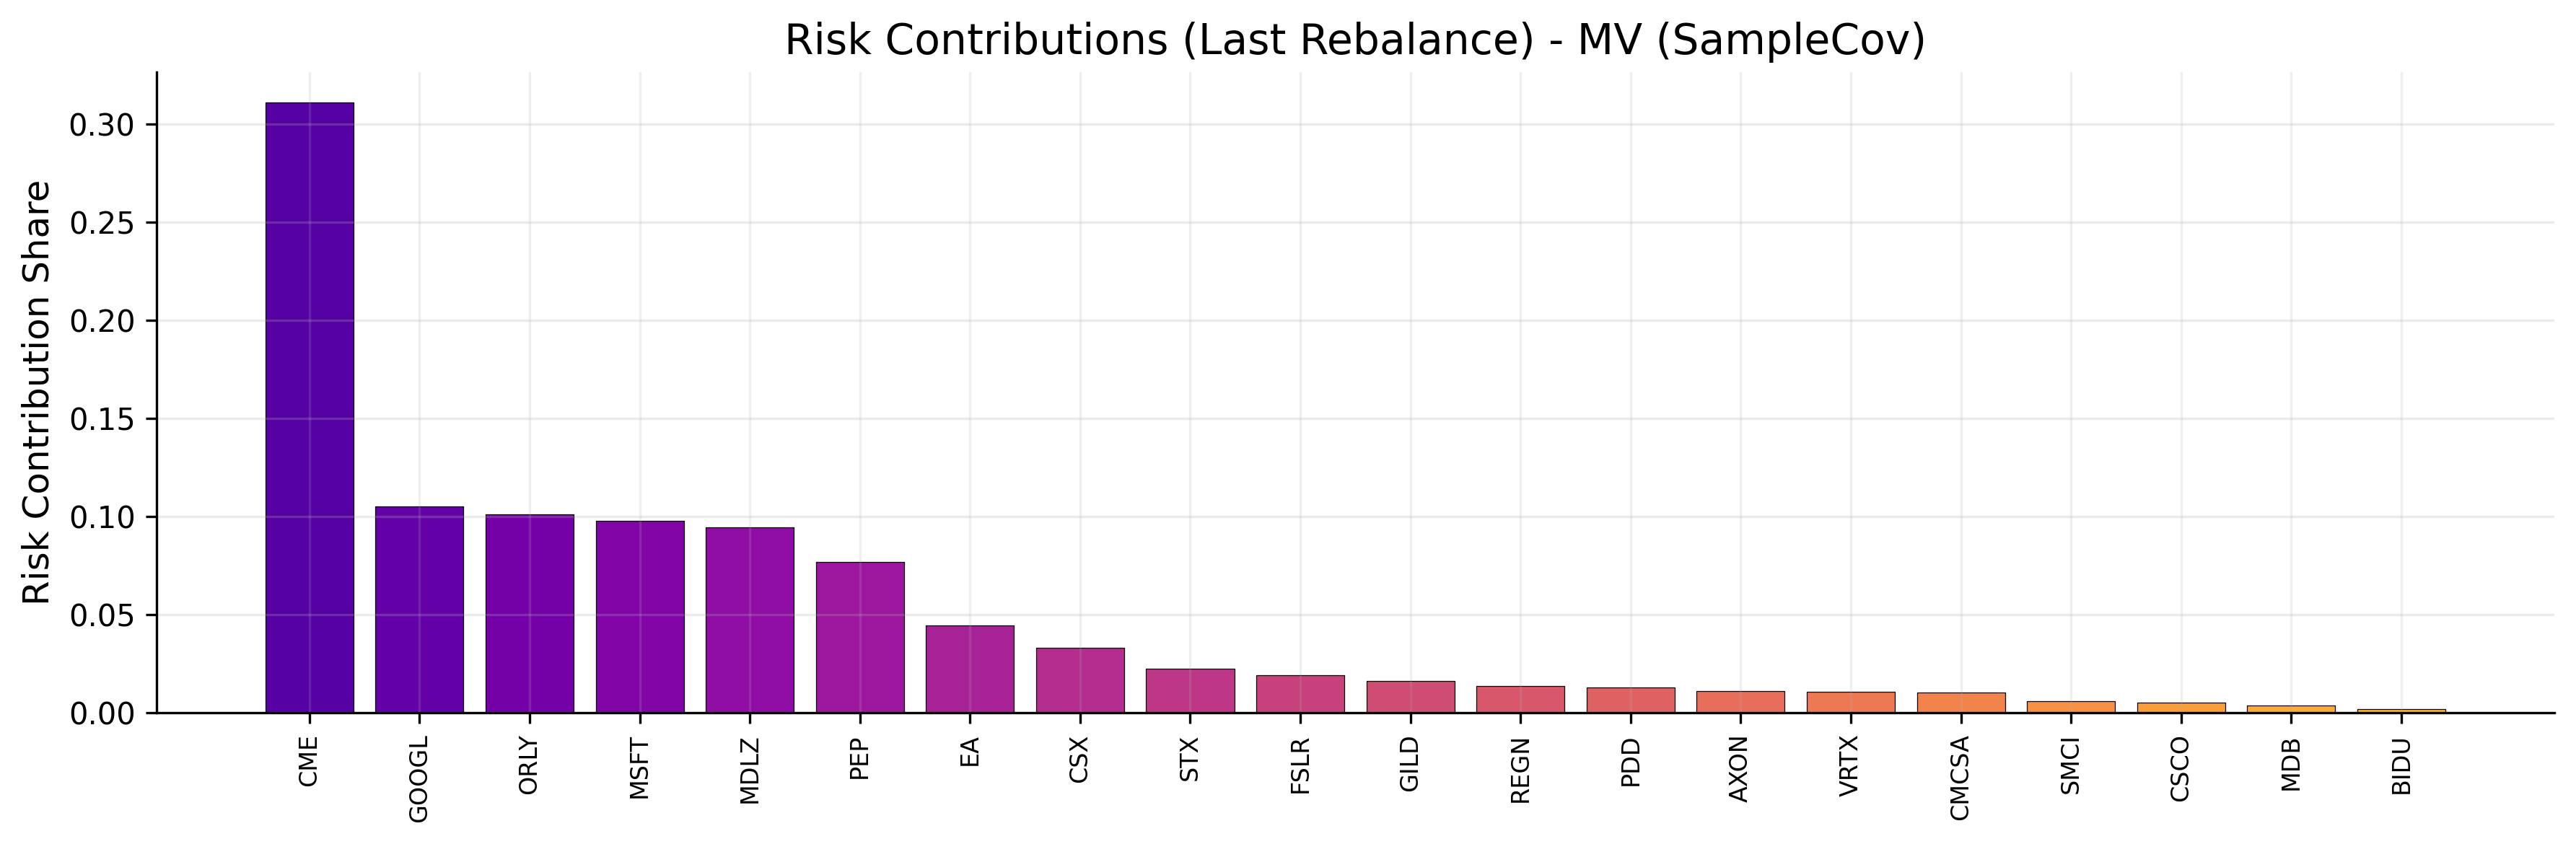

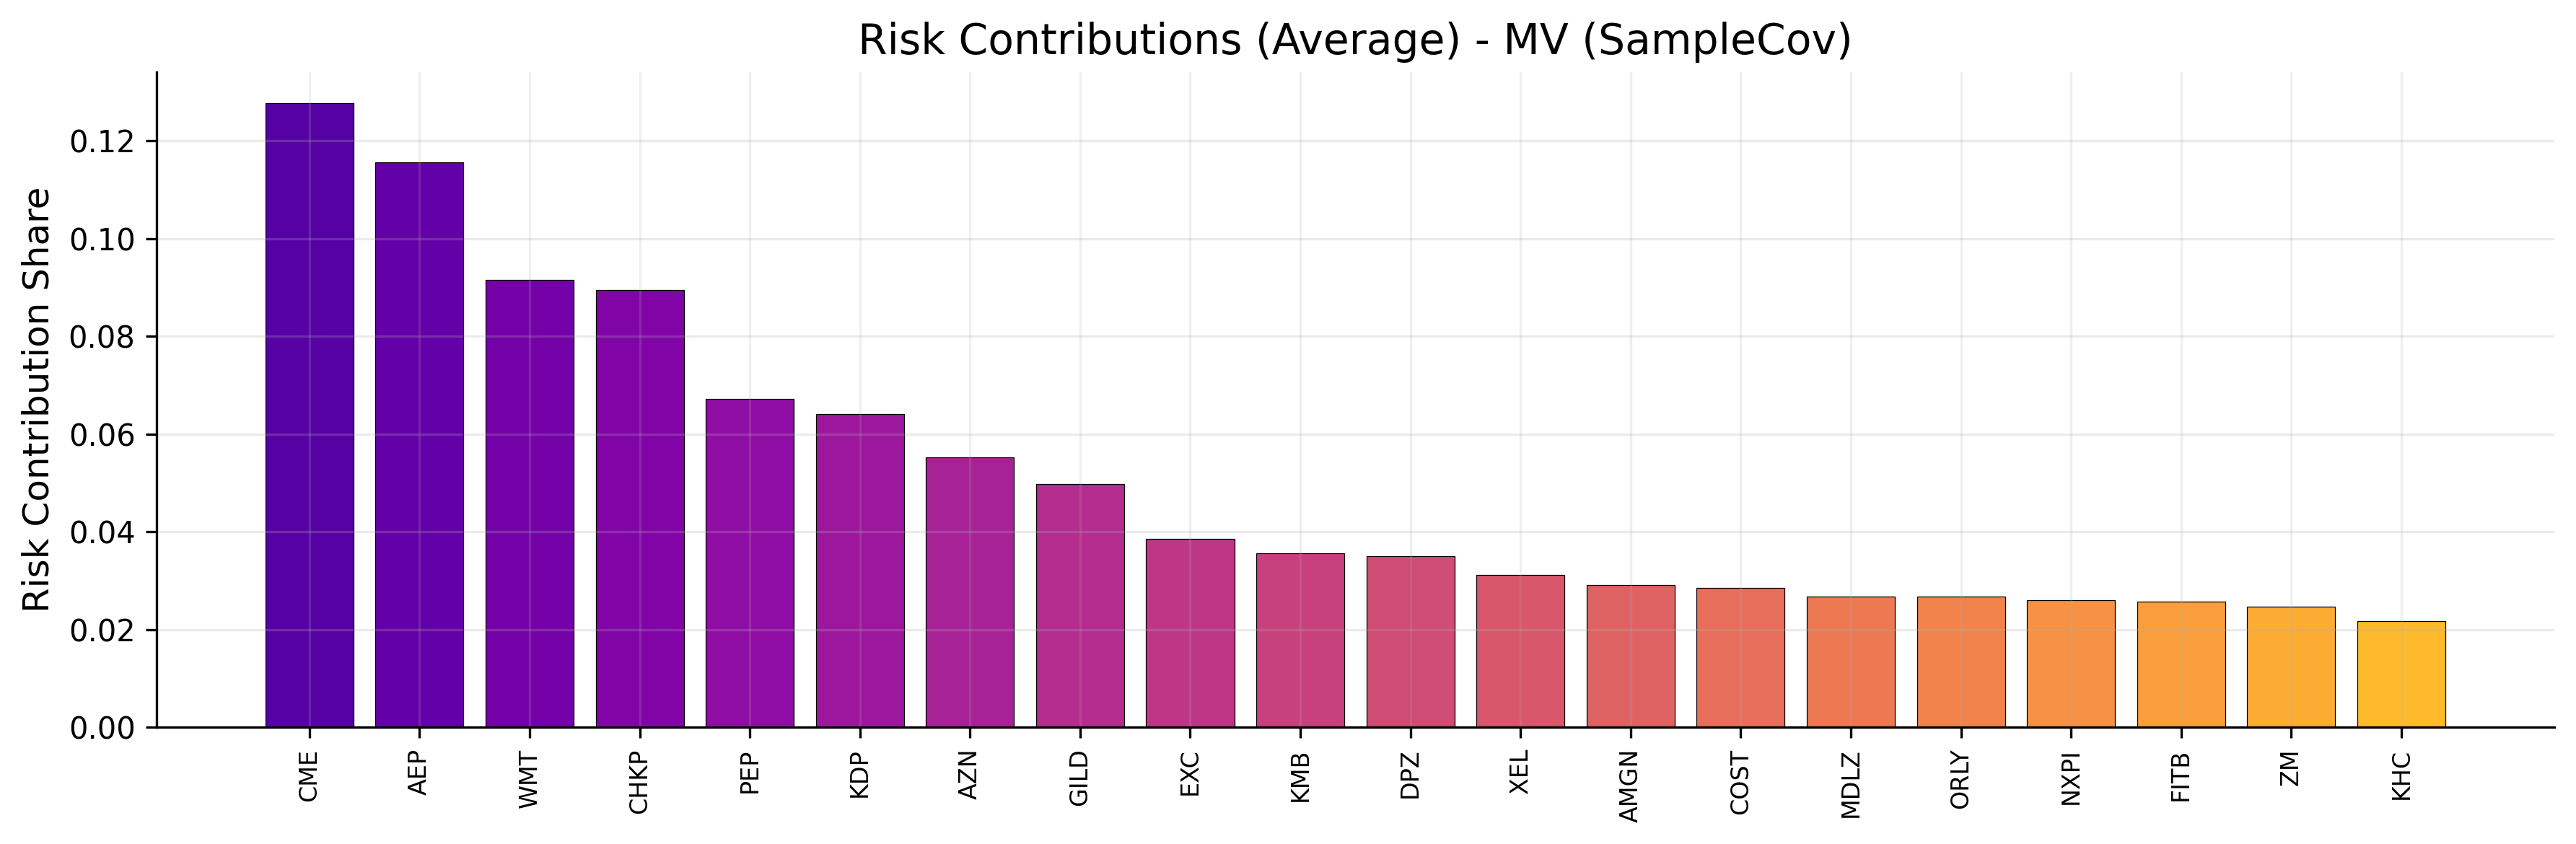

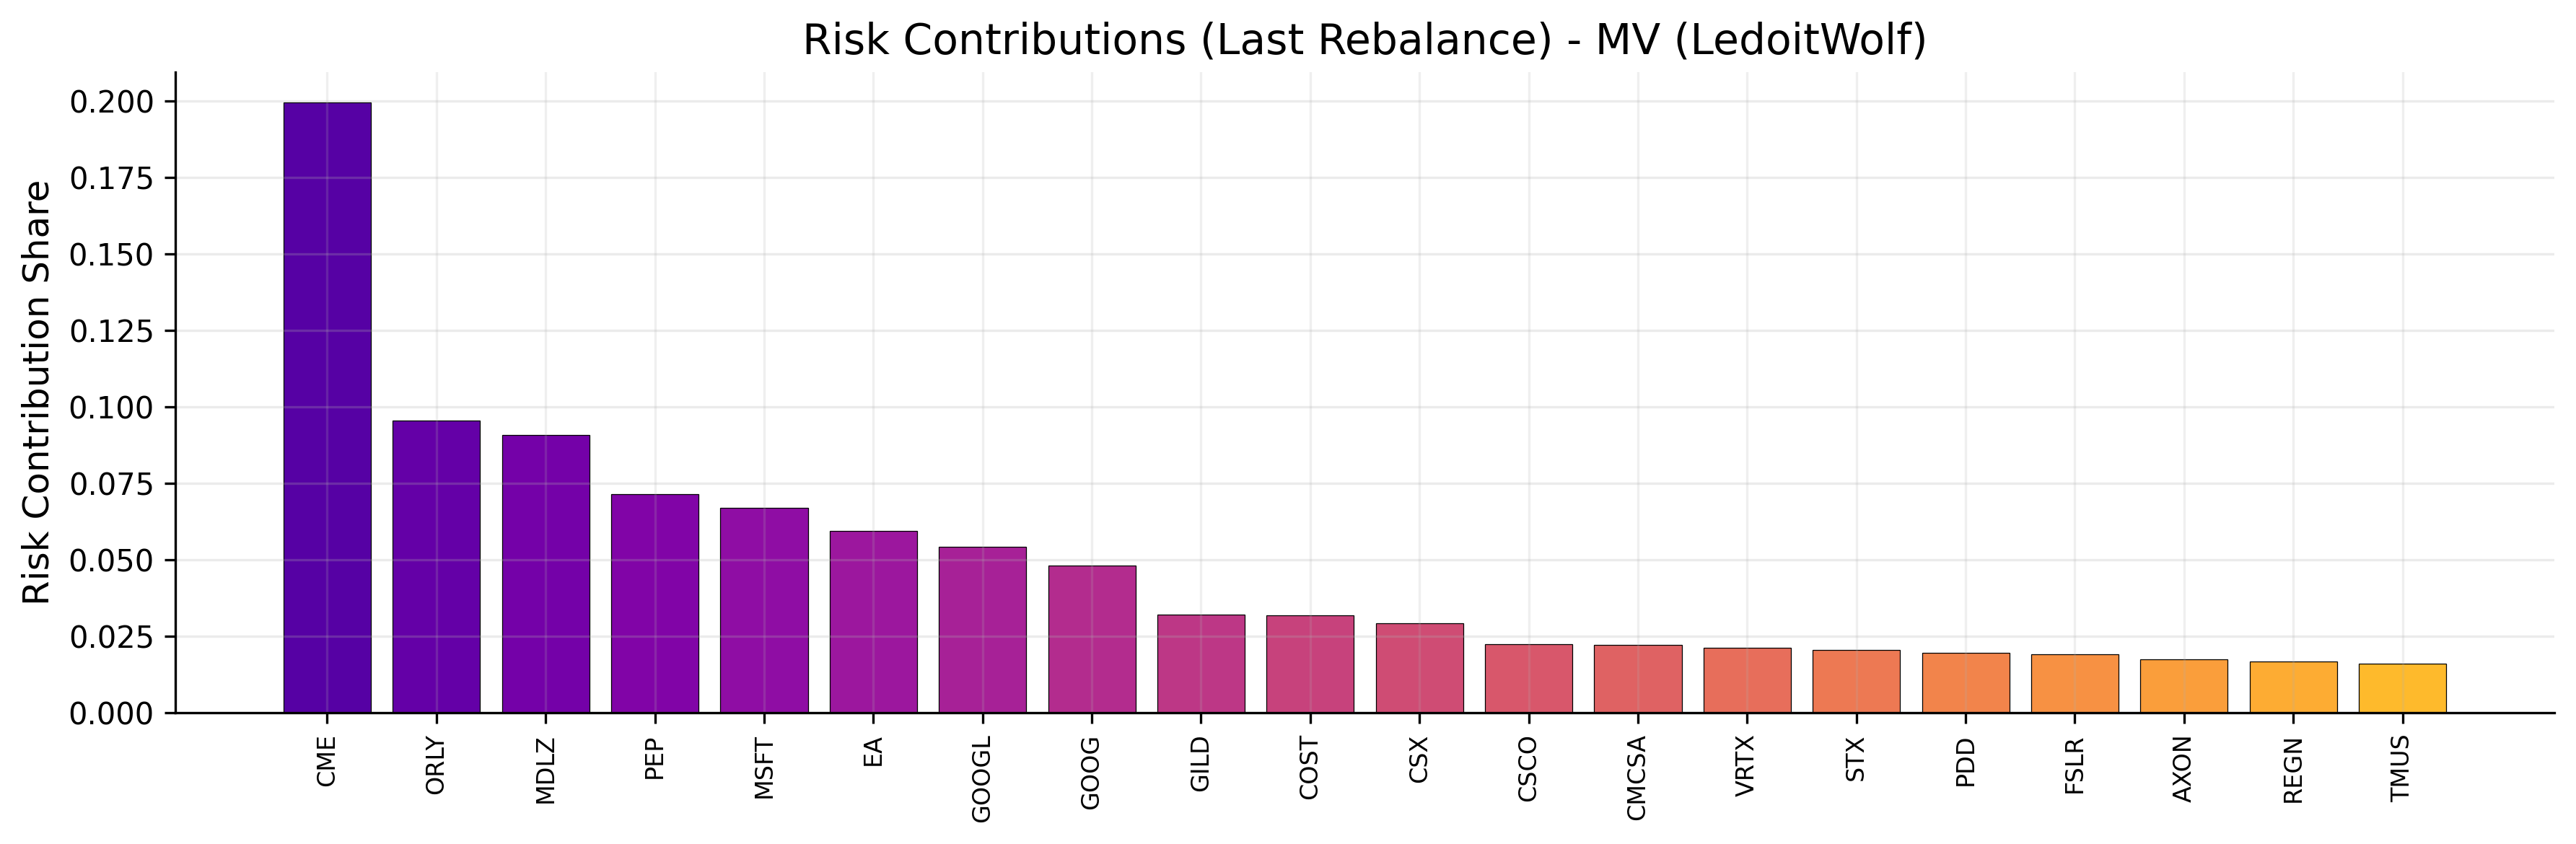

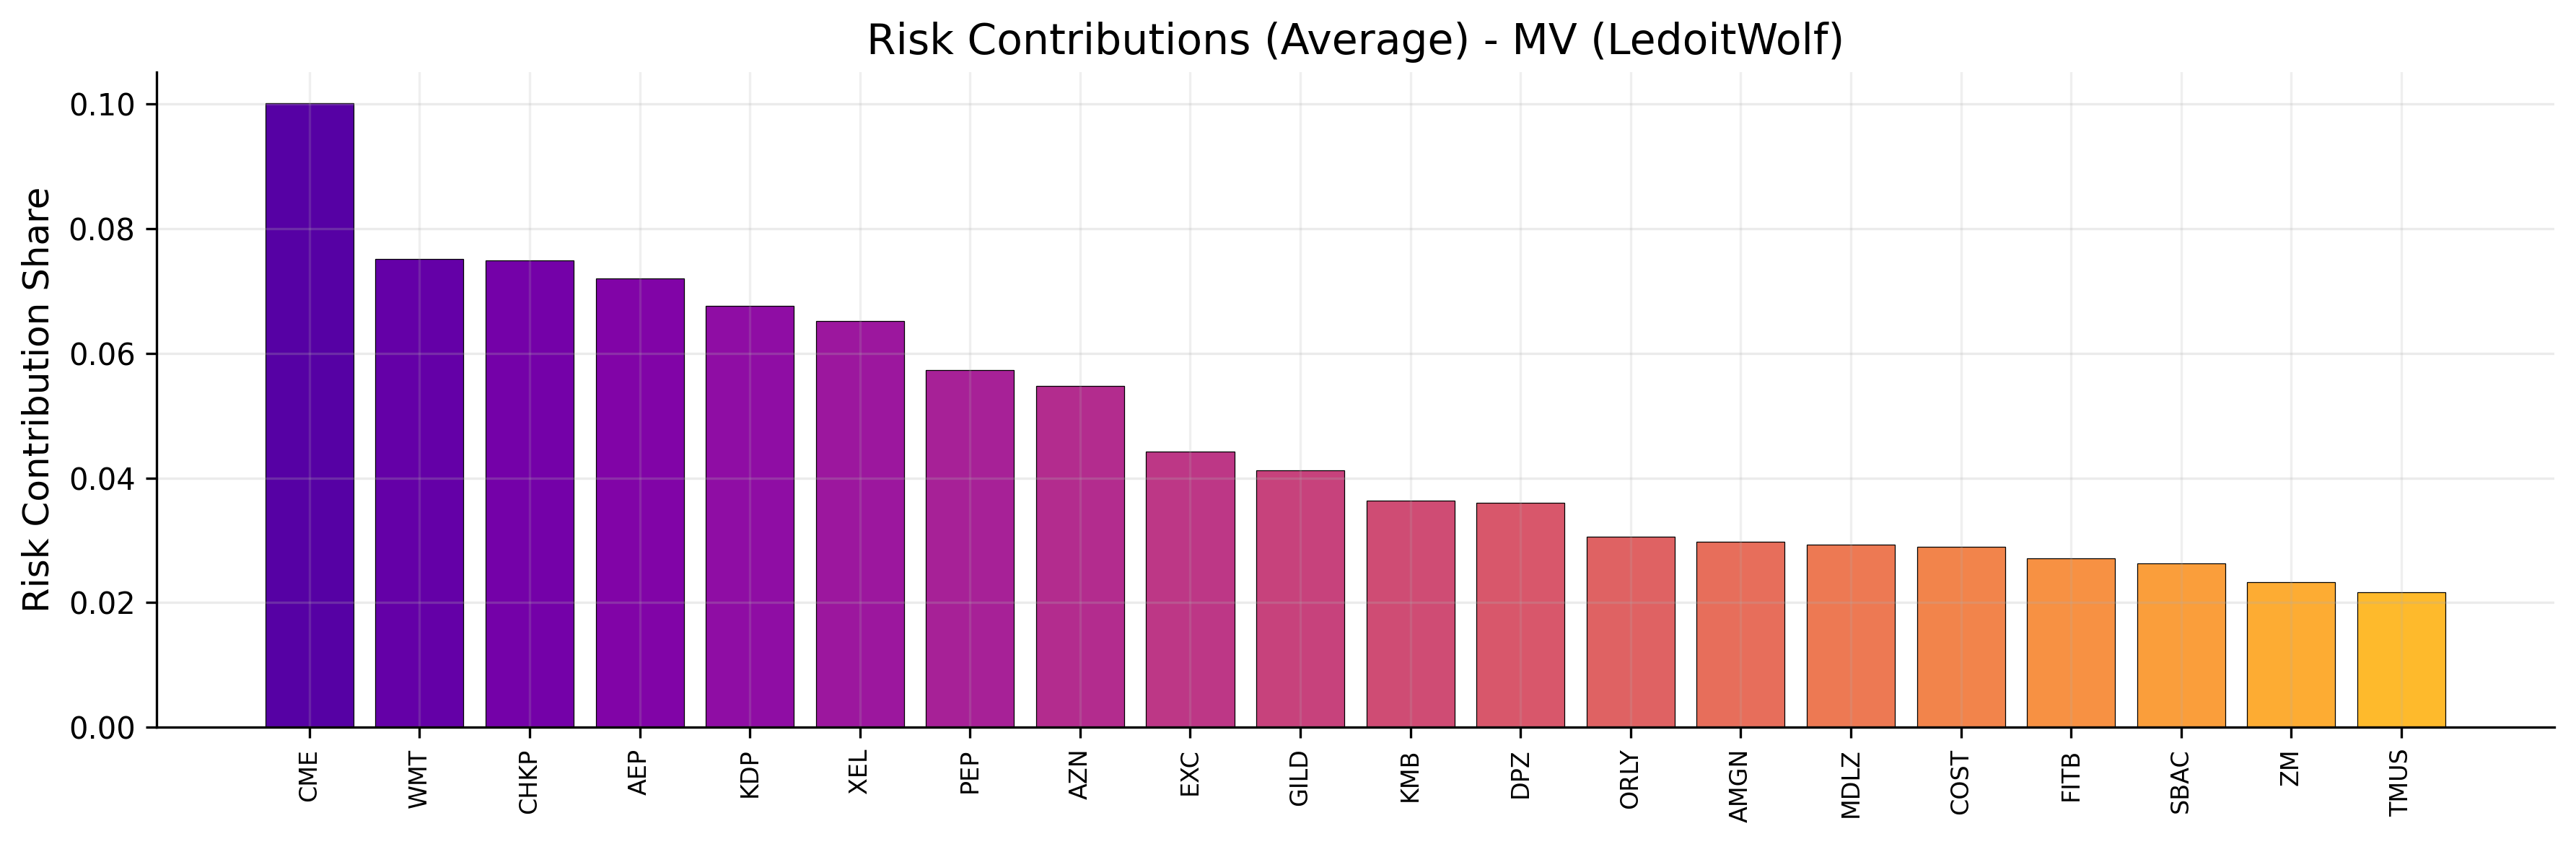

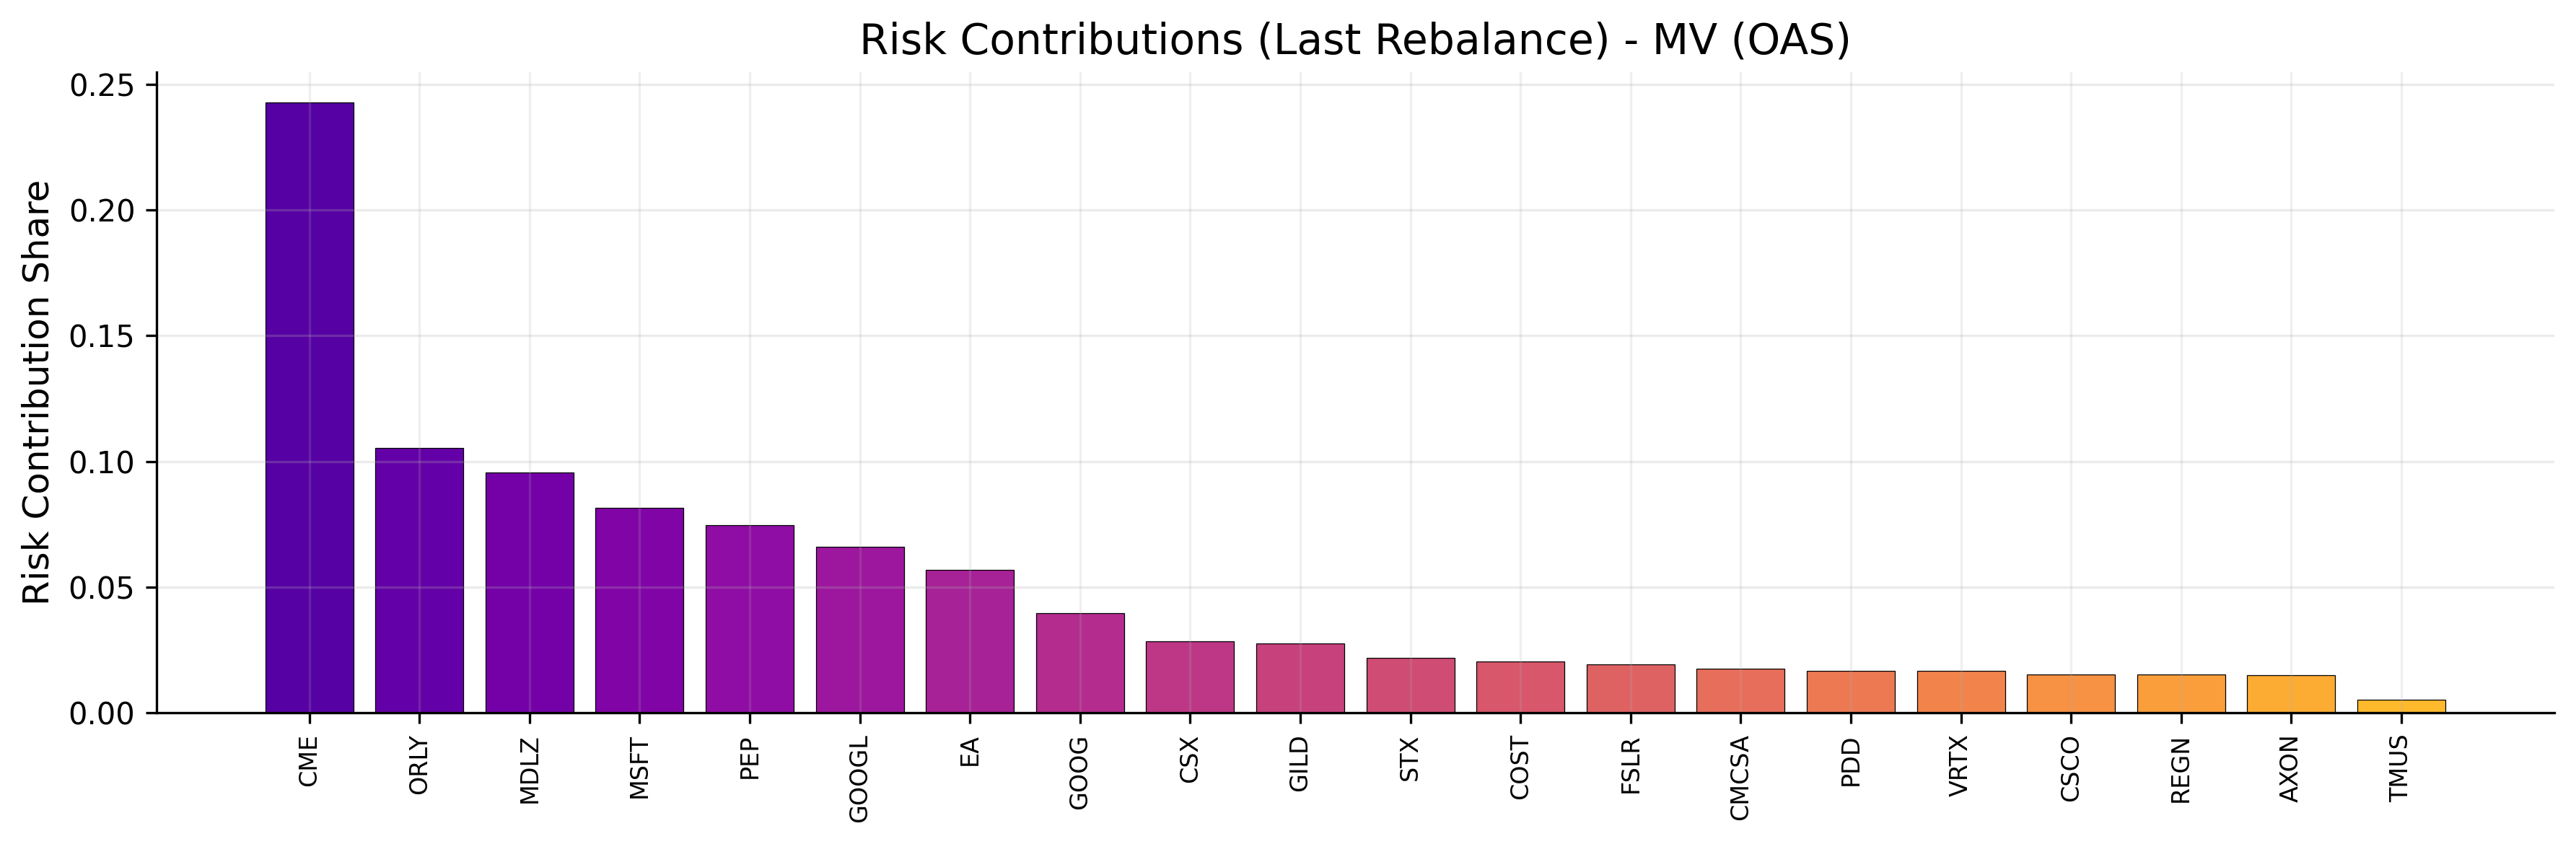

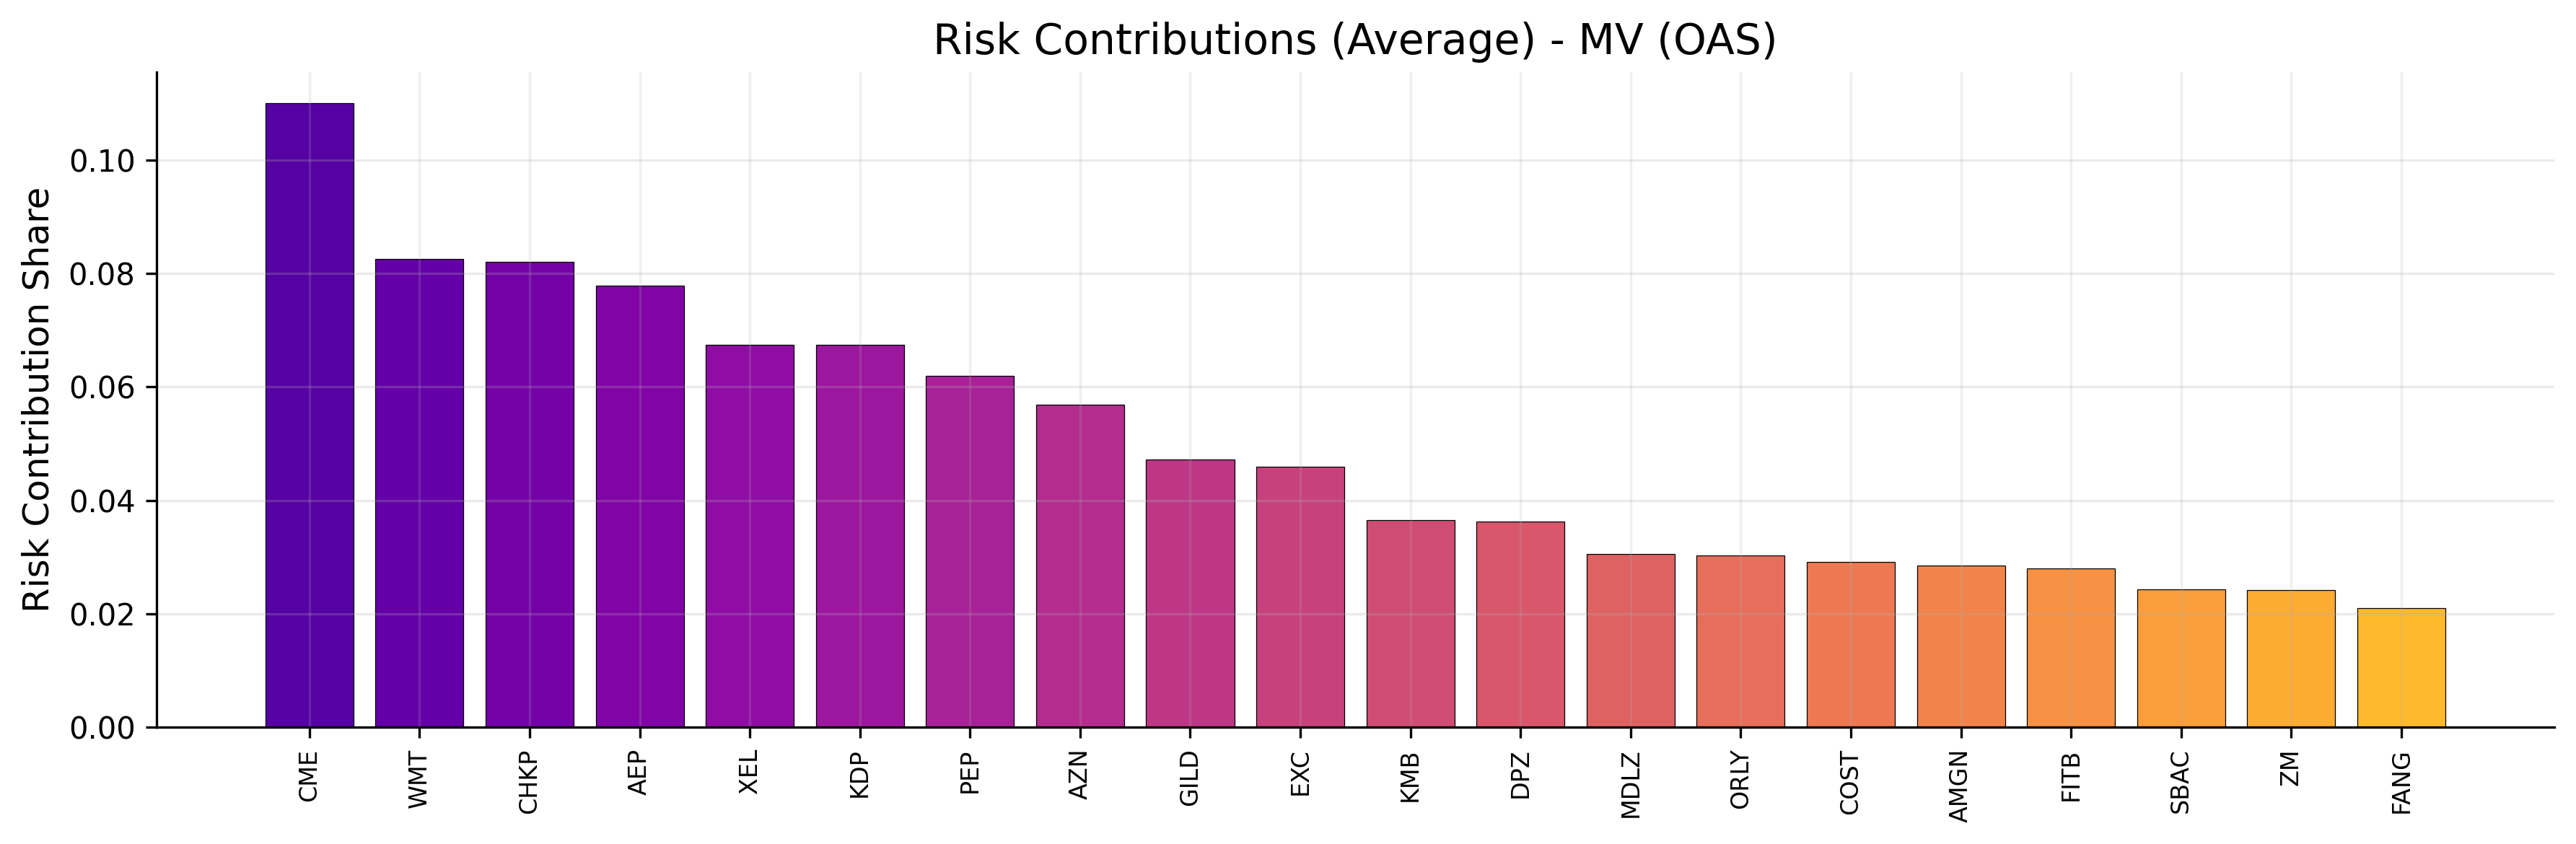

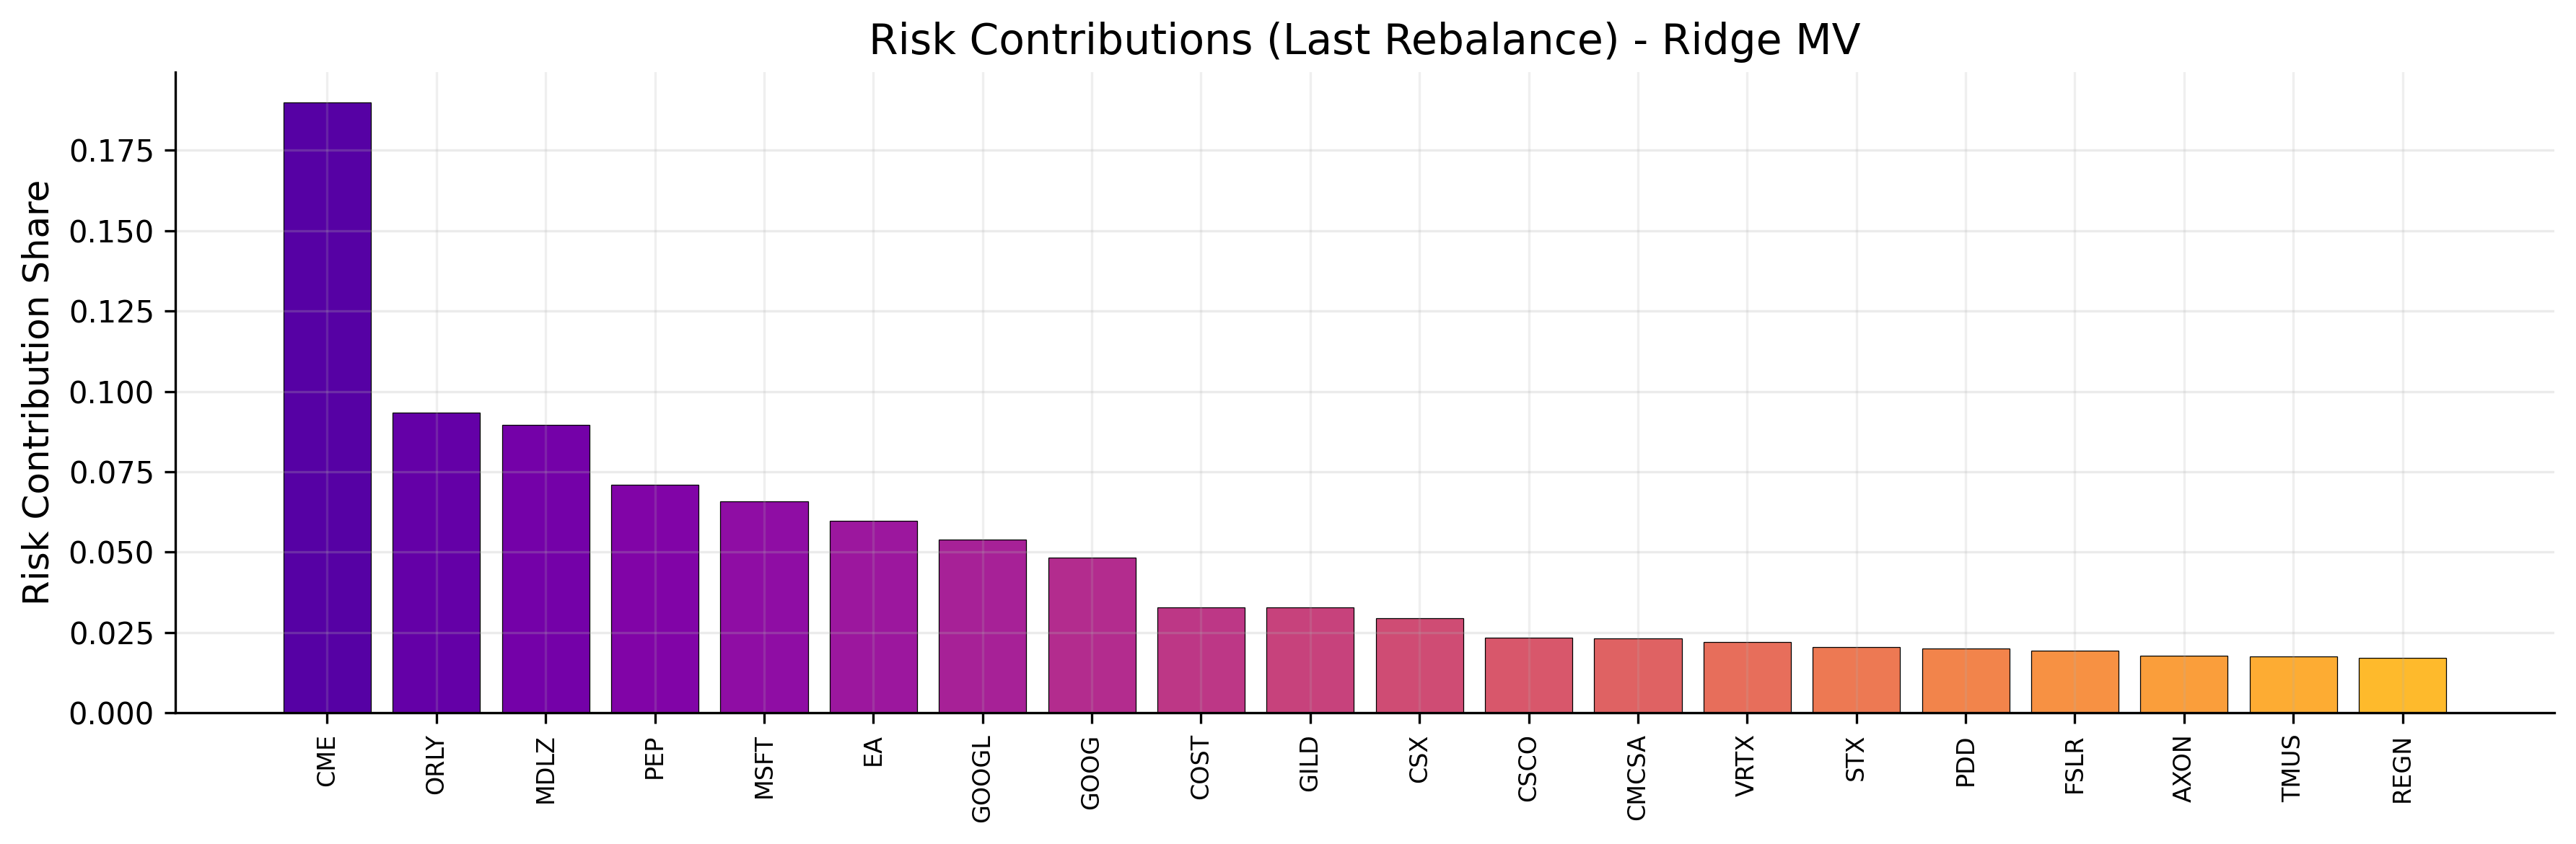

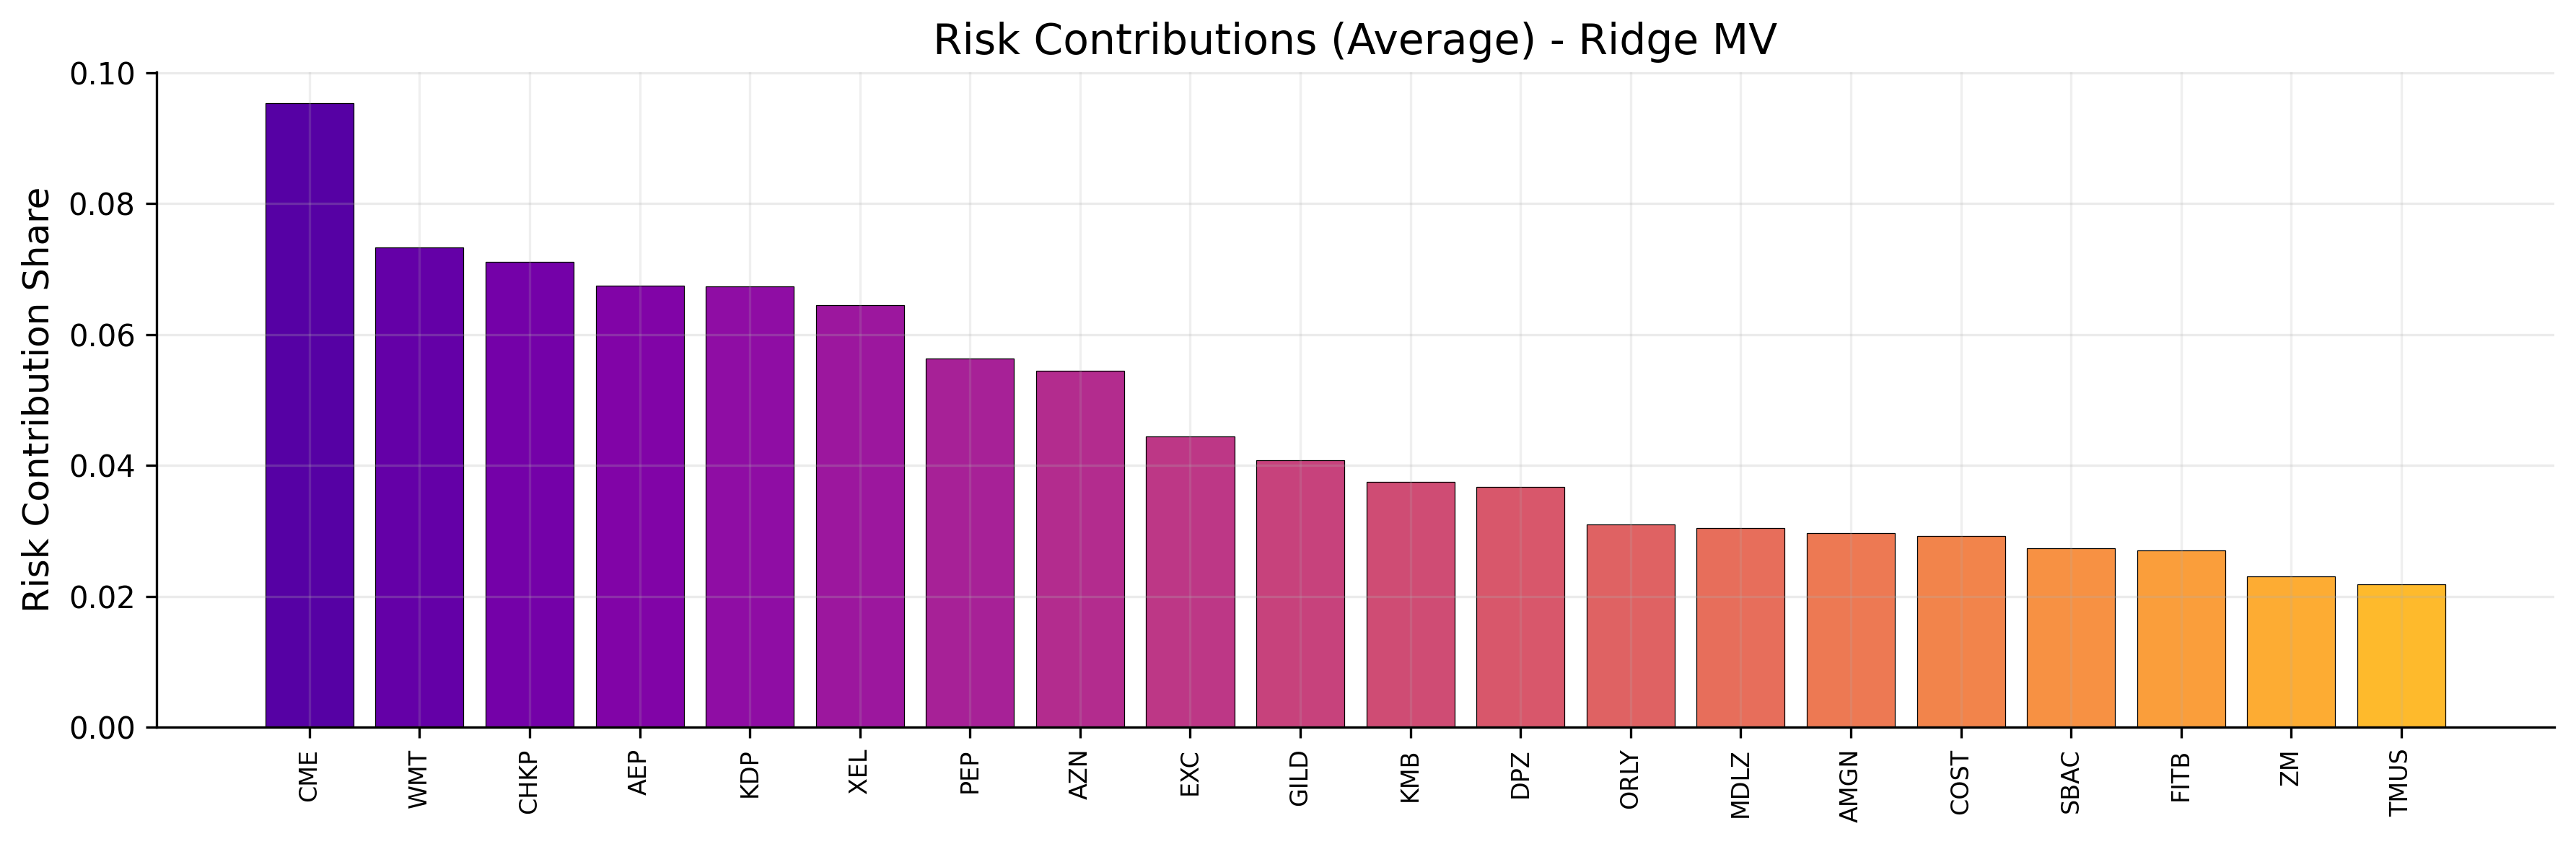

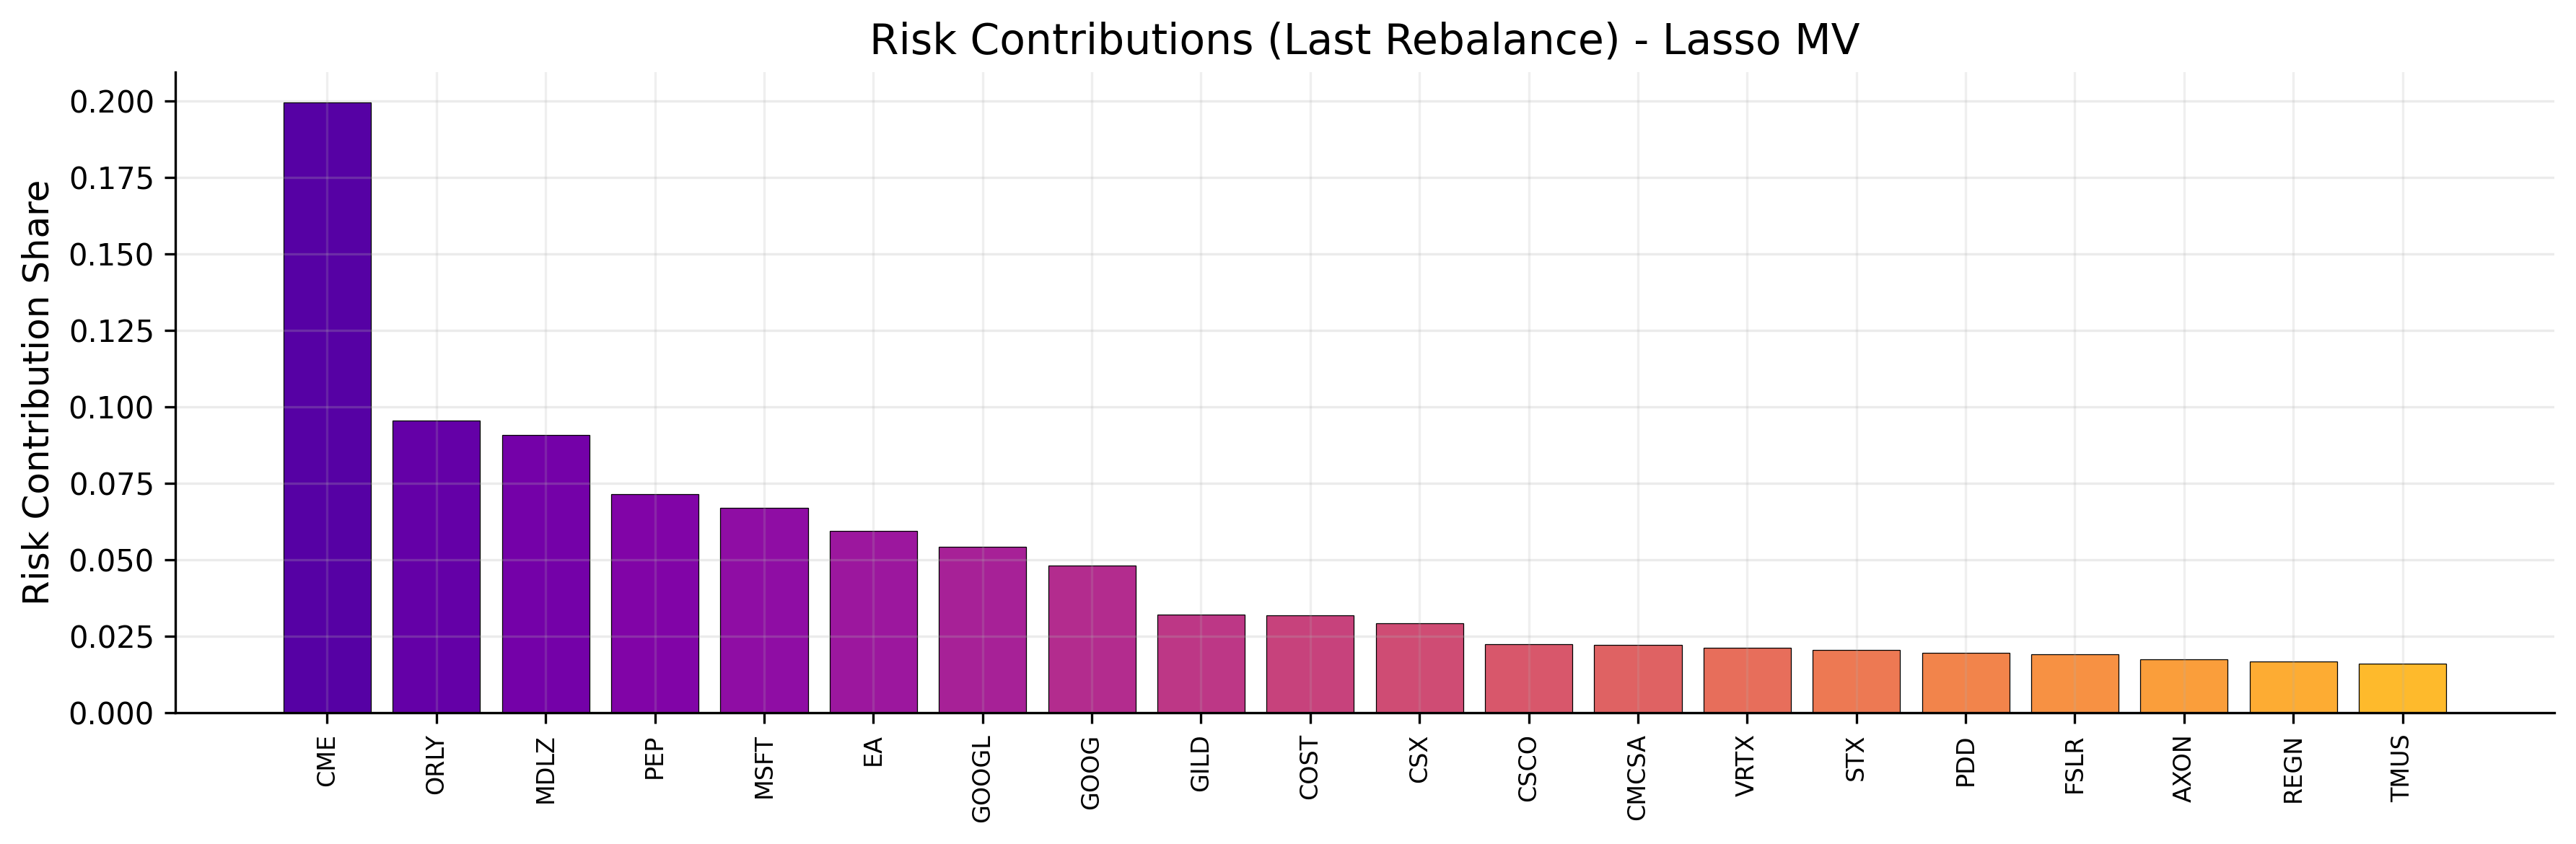

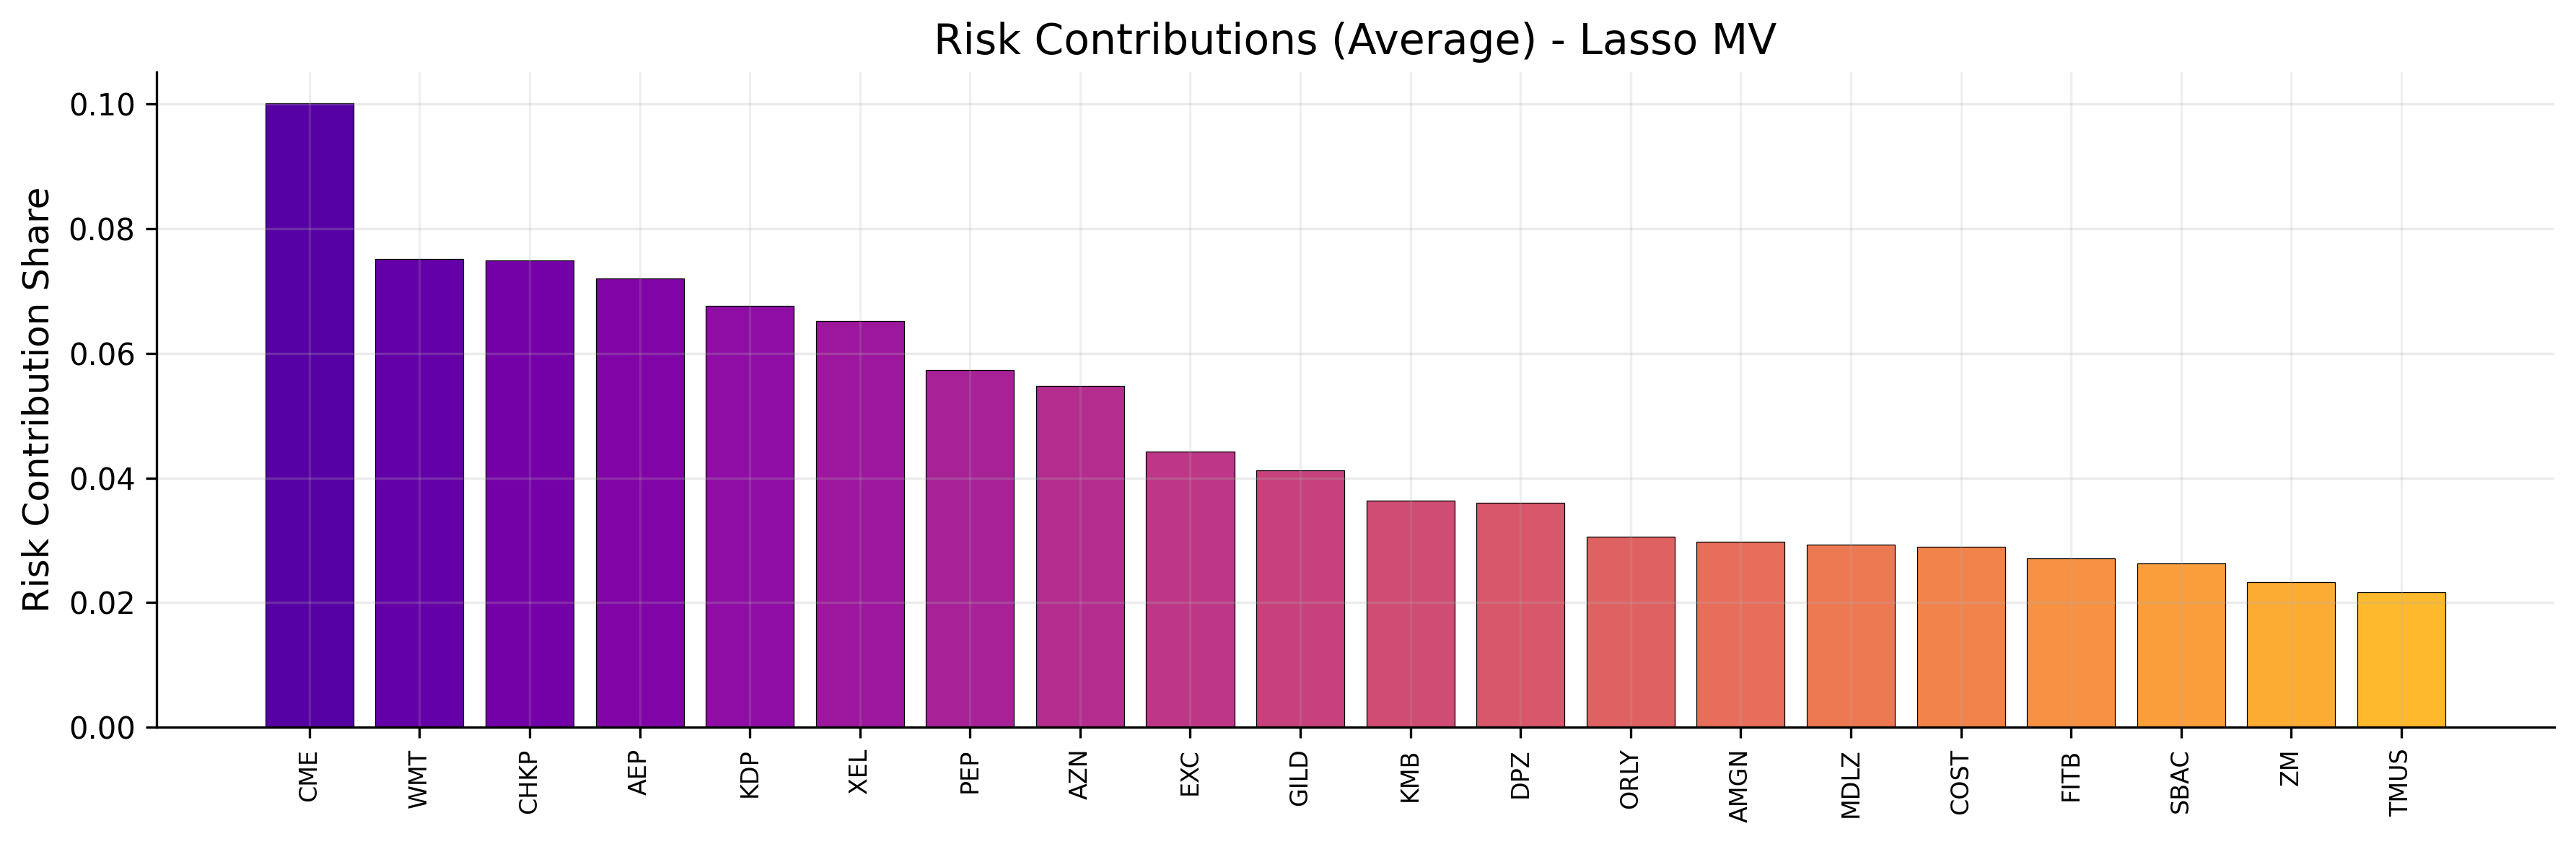

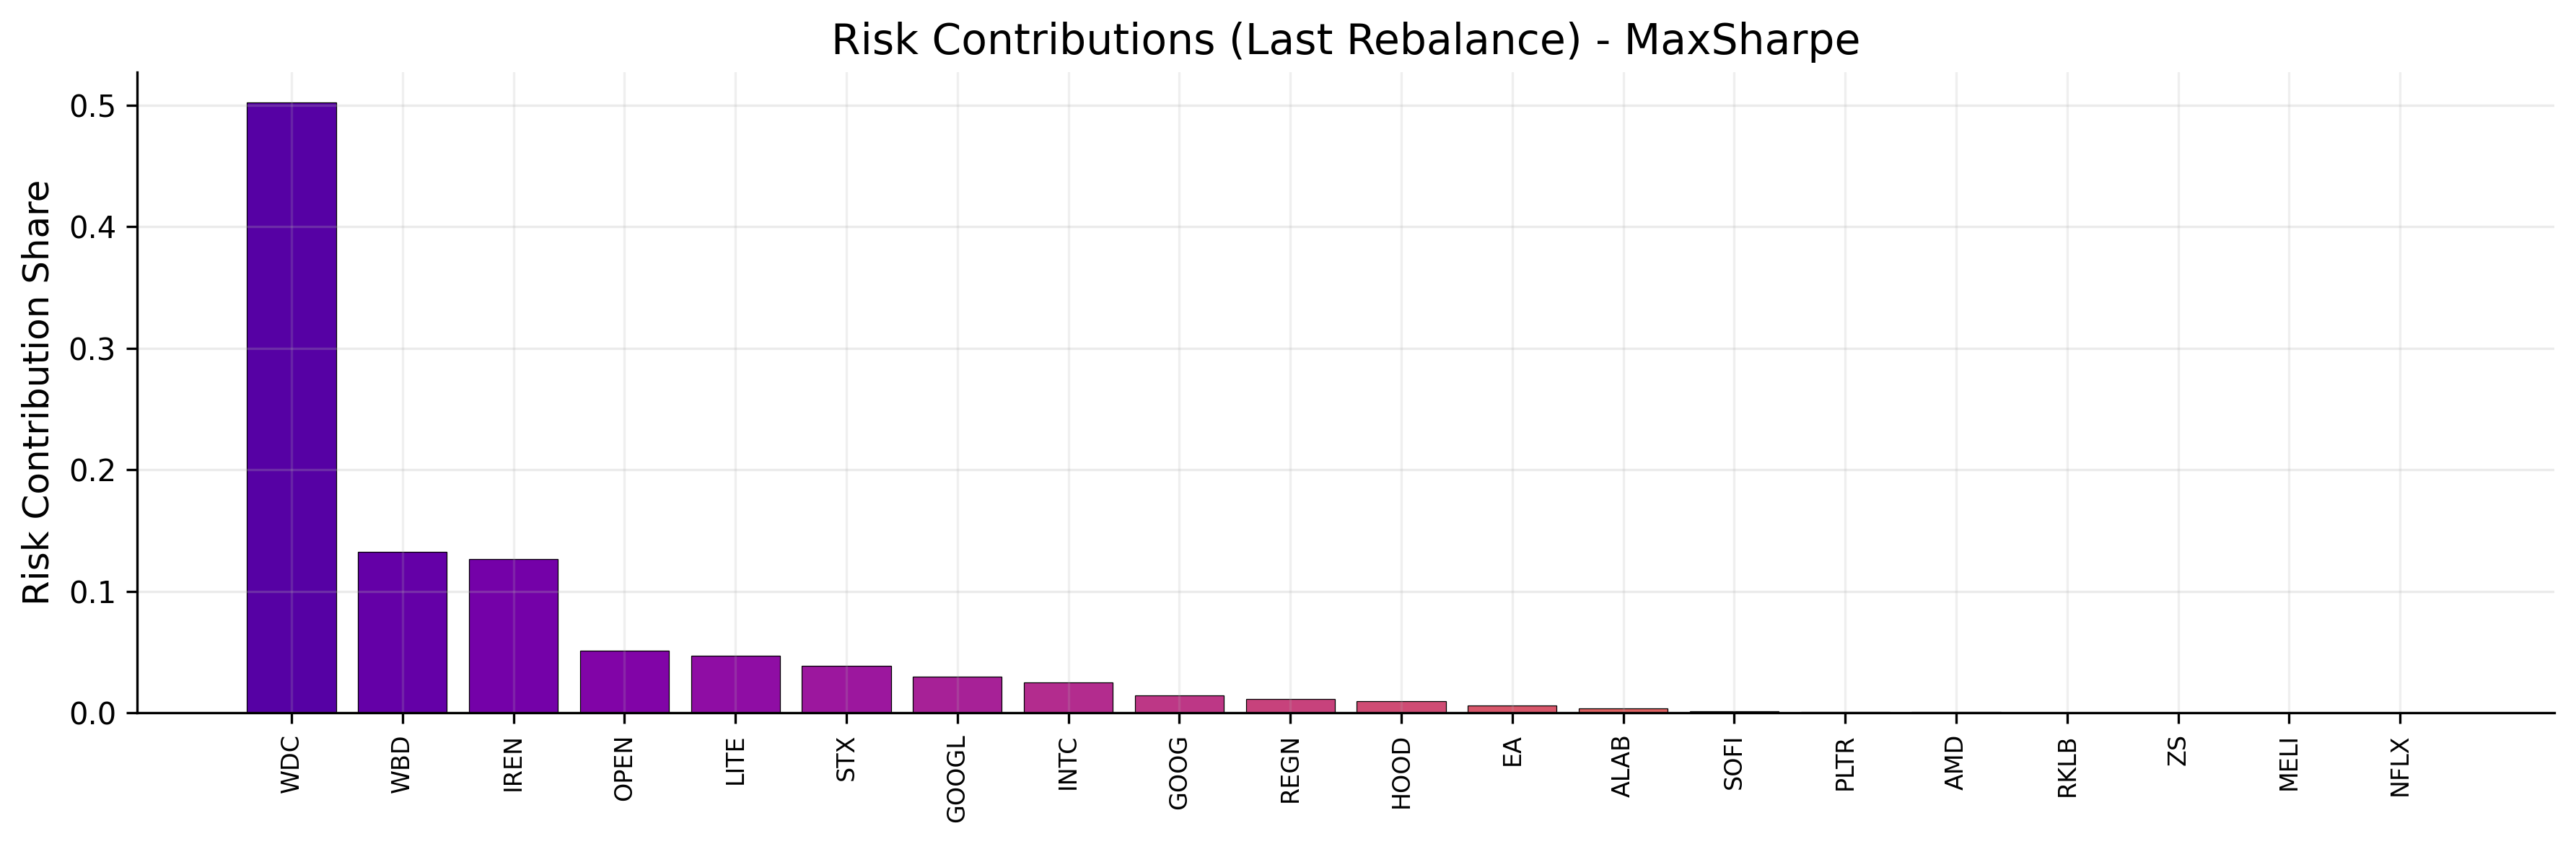

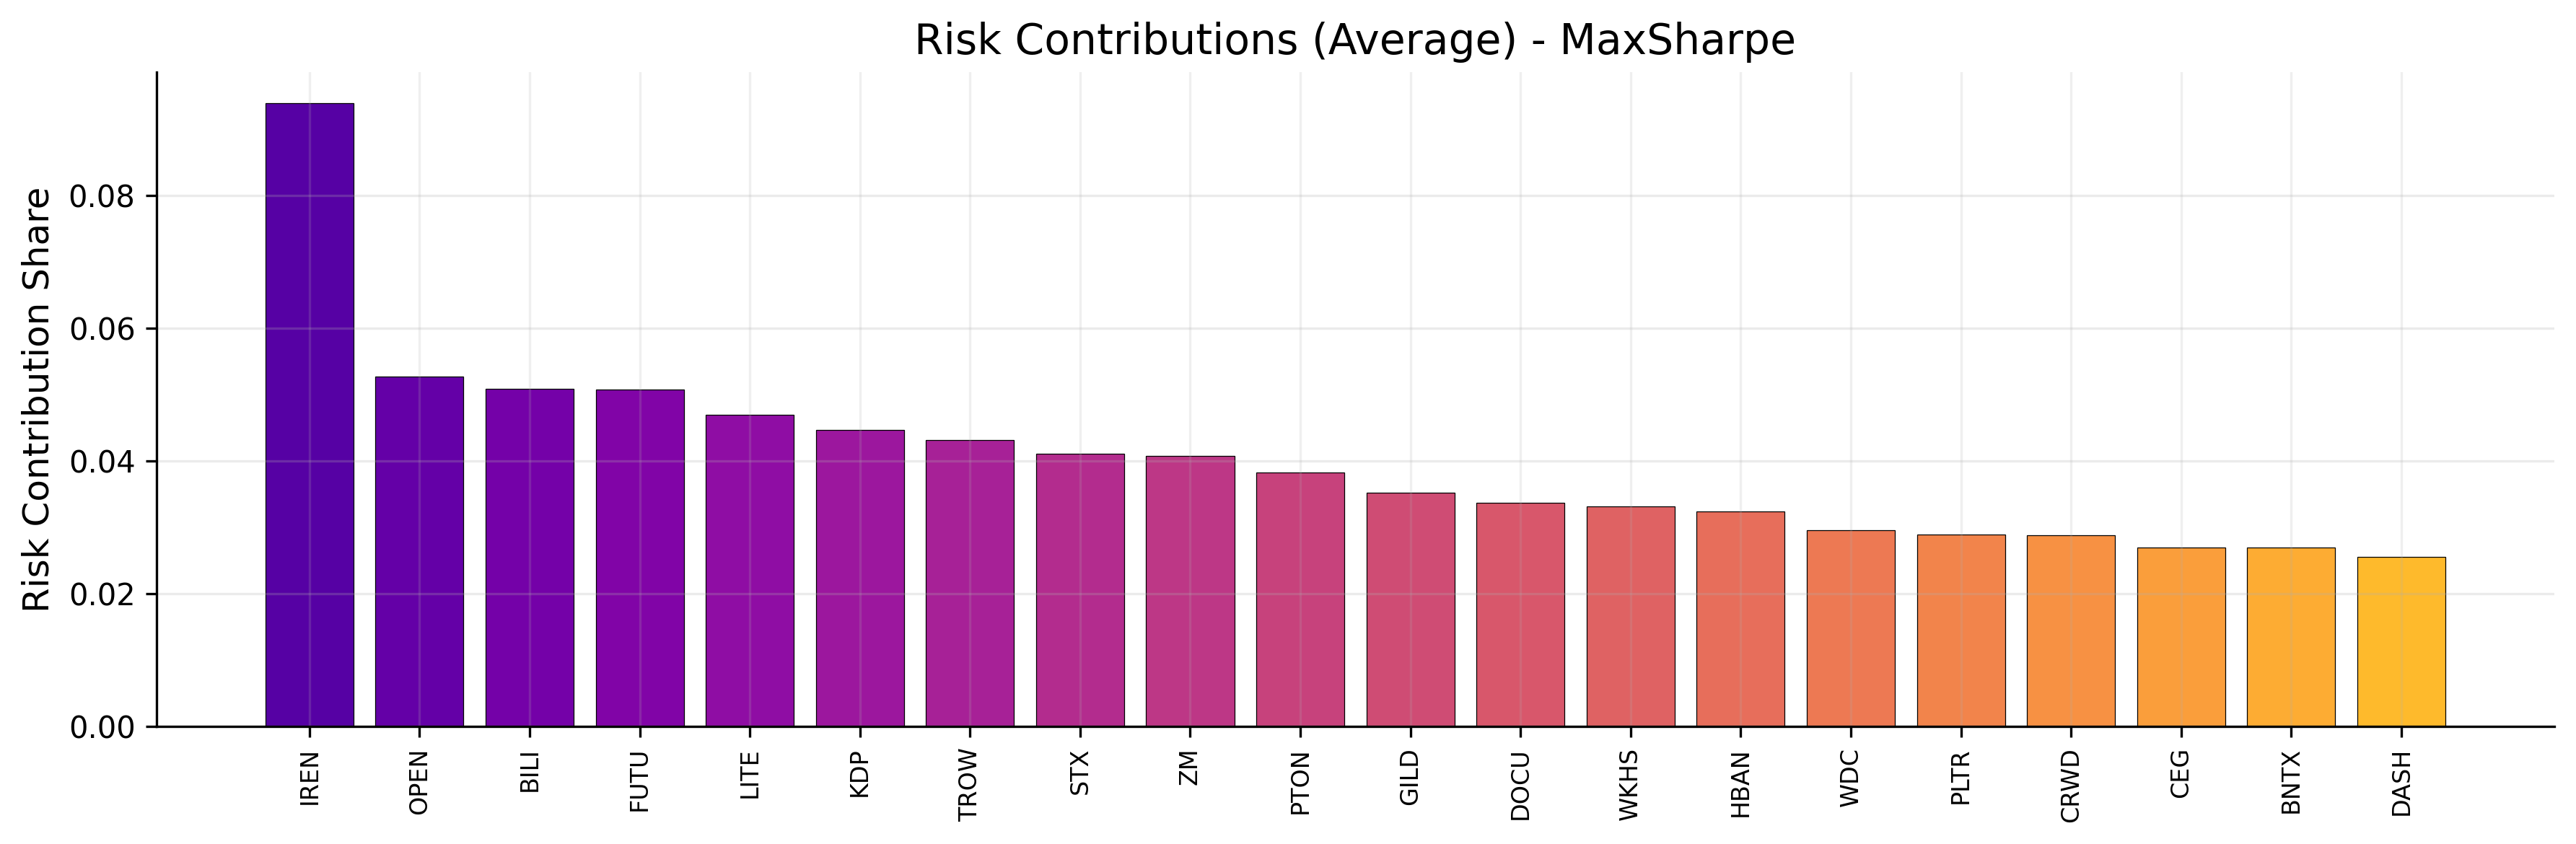

In [3]:
import warnings

warnings.filterwarnings("ignore")

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.dates import DateFormatter
from scipy.optimize import minimize
from sklearn.covariance import LedoitWolf, OAS
from cycler import cycler
np.set_printoptions(precision=6, suppress=True)

colors = ["#069AF3","#FE420F", "#00008B", "#008080", "#800080","#7BC8F6", "#0072B2","#04D8B2", "#CC79A7", "#DC143C","#008000"]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)
plt.rcParams.update({
    "figure.figsize": (6, 3),
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "axes.grid": True,
    "grid.alpha": 0.20,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
})

# ============================================================
# CONFIG
# ============================================================
config = {
    "data_path": r"E:\daneshgah\quantitative-finance-lab\data\nasdaq_all_close_volume.parquet",
    "file_type": "parquet",             # "csv" or "parquet"
    "date_col": "Date",
    "start": "2016-01-01",
    "end": None,
    "returns": "simple",                # "simple" or "log"

    # rebalance schedule: pandas resample rule (calendar-based)
    "rebalance_freq": "M",
    "lookback_days": 250,
    "liquidity_lookback_days": 250,
    "liquidity_top_n": 100,
    "min_history_days": 250,

    "risk_free_annual": 0.02,

    "constraints": {
        "long_only": True,
        "w_min": 0.0,
        "w_max": 0.40,                  # enforced >= 0.30 below (non-NCO)
        "sum_to_one": True
    },

    "costs": {
        "enabled": True,
        "cost_bps_one_way": 10,         # 10 bps
        "fixed_fee_per_trade": 0.0
    },

    "mu_model": {
        # KEY FIX: momentum signal -> winsorize/zscore -> scale to target tangency Sharpe under LW cov
        "type": "momentum_target_sharpe",
        "mode": "6-1",
        "winsor_lo": 0.05,
        "winsor_hi": 0.95,
        "target_sharpe_ann": 0.80,
        "mu_cap_ann": 0.30,
        "apply_shrink": False
    },

    "optimization": {
        # Mean-Variance (annual scale): maximize mu_excess_ann'w - 0.5*lambda*w'Sigma_ann*w - penalties
        "mv_lambda_annual": 32.0,
        "mu_shrink_to_zero": 0.40,

        # Ridge/Lasso MV regularization strengths (scaled by 1/N internally)
        "ridge_mv_gamma": 8.0,
        "lasso_mv_gamma": 1.5,

        # Stability (inside optimizer)
        "ridge": 1e-4,

        # penalty interpretation (IMPORTANT):
        # turnover_penalty_bps: additional "slippage bps" per unit L1 turnover, per rebalance.
        # Costs penalty uses cost_bps_one_way similarly. Both are annualized inside the optimizer.
        "turnover_penalty_bps": 0.0,
        "use_cost_as_penalty": True,

        # Numerics
        "solver_order": ["OSQP", "ECOS", "SCS"],
        "jitter": 1e-10,
        "psd_clip_eps": 1e-10,
        "max_iter": 8000
    },

    "blend": {
        "MV (SampleCov)": 0.15,
        "MV (LedoitWolf)": 0.15,
        "MV (OAS)": 0.15,
        "Ridge MV": 0.15,
        "Lasso MV": 0.15,
        "MaxSharpe": 0.10,
        "MinVar (SampleCov)": 0.20,
        "MinVar (LedoitWolf)": 0.20,
        "MinVar (OAS)": 0.20
    },

    "plots": {"risk_contrib_top_k": 20}
}

# enforce reasonable cap for all long-only strategies
config["constraints"]["w_max"] = max(float(config["constraints"]["w_max"]), 0.40)

# ============================================================
# DATA LOADING
# ============================================================
def _split_ticker_field(col_name):
    if "__" not in col_name:
        return None, None
    ticker, field = col_name.rsplit("__", 1)
    return ticker.strip(), field.strip().lower()

def _extract_close_volume_from_flat(df, cfg):
    if cfg["date_col"] in df.columns:
        date_col = pd.to_datetime(df[cfg["date_col"]], errors="coerce")
    else:
        date_col = pd.to_datetime(df.iloc[:, 0], errors="coerce")

    close_map = {}
    volume_map = {}
    for col in df.columns:
        if str(col) == cfg["date_col"]:
            continue
        ticker, field = _split_ticker_field(str(col))
        if ticker is None:
            continue
        if field == "close":
            close_map[ticker] = col
        elif field == "volume":
            volume_map[ticker] = col

    common = sorted(set(close_map).intersection(volume_map))
    if len(common) == 0:
        raise ValueError("No overlapping Close/Volume columns found in flat parquet/csv.")

    close = df[[close_map[t] for t in common]].copy()
    close.columns = common

    volume = df[[volume_map[t] for t in common]].copy()
    volume.columns = common

    close.index = date_col
    volume.index = date_col
    return close, volume

def _extract_close_volume_from_multi(df, cfg):
    cols_lvl0 = df.columns.get_level_values(0).astype(str)
    cols_lvl1 = df.columns.get_level_values(1).astype(str)

    date_candidates = np.where(cols_lvl0.str.lower() == cfg["date_col"].lower())[0]
    if len(date_candidates) > 0:
        date_col = pd.to_datetime(df.iloc[:, date_candidates[0]], errors="coerce")
    else:
        date_col = pd.to_datetime(df.iloc[:, 0], errors="coerce")

    lvl1_lower = cols_lvl1.str.lower()
    close_labels = ["adj close", "close", "adjclose"]
    volume_labels = ["volume"]

    close_field = next((x for x in close_labels if x in set(lvl1_lower)), None)
    volume_field = next((x for x in volume_labels if x in set(lvl1_lower)), None)
    if close_field is None or volume_field is None:
        raise ValueError("MultiIndex file must contain Close and Volume fields.")

    close = df.loc[:, lvl1_lower == close_field].copy()
    volume = df.loc[:, lvl1_lower == volume_field].copy()

    close.columns = close.columns.get_level_values(0)
    volume.columns = volume.columns.get_level_values(0)

    common = sorted(set(close.columns).intersection(volume.columns))
    close = close[common]
    volume = volume[common]

    close.index = date_col
    volume.index = date_col
    return close, volume

def load_close_volume(cfg):
    path = cfg["data_path"]
    if cfg["file_type"] == "csv":
        df = pd.read_csv(path, header=[0, 1], low_memory=False)
    else:
        df = pd.read_parquet(path)

    if isinstance(df.columns, pd.MultiIndex):
        close, volume = _extract_close_volume_from_multi(df, cfg)
    else:
        close, volume = _extract_close_volume_from_flat(df, cfg)

    close = close.sort_index()
    volume = volume.sort_index()

    close = close.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
    volume = volume.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)

    # float32 for faster panel calculations
    close = close.astype(np.float32)
    volume = volume.astype(np.float32)

    valid_idx = close.index.notna() & volume.index.notna()
    close = close.loc[valid_idx]
    volume = volume.loc[valid_idx]
    close = close[~close.index.duplicated(keep="last")]
    volume = volume.loc[close.index]

    return close, volume

close_prices, volumes = load_close_volume(config)

start = pd.Timestamp(config["start"])
end = pd.Timestamp(config["end"]) if config["end"] else None
close_prices = close_prices.loc[close_prices.index >= start]
volumes = volumes.loc[volumes.index >= start]
if end is not None:
    close_prices = close_prices.loc[close_prices.index <= end]
    volumes = volumes.loc[volumes.index <= end]

common_idx = close_prices.index.intersection(volumes.index)
common_cols = close_prices.columns.intersection(volumes.columns)
close_prices = close_prices.loc[common_idx, common_cols]
volumes = volumes.loc[common_idx, common_cols]

if config["returns"] == "log":
    returns = np.log(close_prices).diff()
else:
    returns = close_prices.pct_change(fill_method=None)

returns = returns.replace([np.inf, -np.inf], np.nan).astype(np.float32)

all_tickers = close_prices.columns.tolist()
tickers = all_tickers
if len(tickers) < 2:
    raise ValueError("Need at least two assets in input data.")

# ============================================================
# HELPERS
# ============================================================
def print_warn(msg):
    print(f"[WARN] {msg}")

def format_date_axis(ax):
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    ax.figure.autofmt_xdate()

def cov_to_corr(sigma):
    d = np.sqrt(np.diag(sigma))
    d[d == 0] = 1e-12
    corr = sigma / np.outer(d, d)
    return np.clip(corr, -1.0, 1.0)

def make_psd(sigma, eps):
    sigma = 0.5 * (sigma + sigma.T)
    vals, vecs = np.linalg.eigh(sigma)
    vals = np.maximum(vals, eps)
    sigma_psd = (vecs * vals) @ vecs.T
    return 0.5 * (sigma_psd + sigma_psd.T)

def safe_normalize_weights(w, w_min, w_max, long_only):
    w = np.asarray(w, dtype=np.float64).flatten()
    if long_only:
        w = np.maximum(w, 0.0)
    if w_min is not None:
        w = np.maximum(w, w_min)
    if w_max is not None:
        w = np.minimum(w, w_max)
    s = w.sum()
    if (not np.isfinite(s)) or s <= 0:
        return None
    w = w / s
    for _ in range(2):
        if long_only:
            w = np.maximum(w, 0.0)
        if w_min is not None:
            w = np.maximum(w, w_min)
        if w_max is not None:
            w = np.minimum(w, w_max)
        s = w.sum()
        if s <= 0:
            return None
        w = w / s
    return w

def compute_drifted_weights(w, r):
    w = w * (1.0 + r)
    s = w.sum()
    if s <= 0 or (not np.isfinite(s)):
        return None
    return w / s

def constraints_feasible(nn, w_min, w_max, long_only):
    w_min_eff = 0.0 if long_only else (-np.inf if w_min is None else w_min)
    w_max_eff = np.inf if w_max is None else w_max
    if np.isfinite(w_max_eff) and w_max_eff * nn < 1.0 - 1e-9:
        return False
    if np.isfinite(w_min_eff) and w_min_eff * nn > 1.0 + 1e-9:
        return False
    return True

def blend_weights(w_star, w_prev, eta):
    eta = float(np.clip(eta, 0.0, 1.0))
    return (1.0 - eta) * np.asarray(w_star, dtype=np.float64) + eta * np.asarray(w_prev, dtype=np.float64)

# Transaction costs
w_min = float(config["constraints"]["w_min"])
w_max = float(config["constraints"]["w_max"])
long_only = bool(config["constraints"]["long_only"])

rf_daily = (1.0 + config["risk_free_annual"]) ** (1.0 / 252.0) - 1.0

def tc_rate_from_delta(delta):
    if not config["costs"]["enabled"]:
        return 0.0
    c = config["costs"]["cost_bps_one_way"] / 10000.0
    return float(c * np.sum(np.abs(delta)))

def rebalances_per_year(rebal_dates_index):
    if len(rebal_dates_index) < 2:
        return 1.0
    d = pd.to_datetime(rebal_dates_index).values
    gaps = np.diff(d).astype("timedelta64[D]").astype(int)
    med_days = float(np.median(gaps))
    med_days = max(med_days, 1.0)
    return 252.0 / med_days

# ============================================================
# MU: MOMENTUM SIGNAL -> SCALE TO TARGET TANGENCY SHARPE (FIX)
# ============================================================
def momentum_score_from_returns(ret_window: pd.DataFrame, mode="6-1") -> np.ndarray:
    """
    Cross-sectional momentum SCORE at window end.
    Uses geometric cumulative return over lookback, skipping last month if requested.

    mode:
      "6-1": 126d lookback, skip last 21d
      "12-1": 252d lookback, skip last 21d (needs >=273 days)
      "3-0":  63d lookback, skip 0d
    """
    R = ret_window.replace([np.inf, -np.inf], np.nan).dropna(how="any")
    T = len(R)
    if T < 80:
        return R.mean().values.astype(np.float64)

    if mode == "12-1":
        lookback, skip = 252, 21
    elif mode == "6-1":
        lookback, skip = 126, 21
    elif mode == "3-0":
        lookback, skip = 63, 0
    else:
        raise ValueError("Unknown momentum mode")

    if T < lookback + skip + 5:
        lookback = min(lookback, max(63, T - skip - 1))

    R_use = R.iloc[-(lookback + skip):]
    R_mom = R_use.iloc[:-skip] if skip > 0 else R_use

    cum = (1.0 + R_mom).prod(axis=0) - 1.0
    return cum.values.astype(np.float64)

def winsorize_and_zscore(x: np.ndarray, p_lo=0.05, p_hi=0.95) -> np.ndarray:
    x = np.asarray(x, dtype=np.float64)
    lo, hi = np.quantile(x, [p_lo, p_hi])
    x = np.clip(x, lo, hi)
    x = x - x.mean()
    return x / (x.std() + 1e-12)

def scale_mu_to_target_sharpe(mu_dir: np.ndarray,
                              cov_ann: np.ndarray,
                              target_sharpe_ann: float,
                              mu_cap_ann: float) -> np.ndarray:
    """
    Scale a direction vector mu_dir so that tangency Sharpe implied by (mu, Sigma) equals target.
    target: sqrt(mu' Sigma^{-1} mu)
    """
    mu = np.asarray(mu_dir, dtype=np.float64).flatten()
    if np.all(np.abs(mu) < 1e-12):
        return np.zeros_like(mu)

    ridge = 1e-8
    A = cov_ann + ridge * np.eye(cov_ann.shape[0])
    try:
        x = np.linalg.solve(A, mu)
    except np.linalg.LinAlgError:
        x = np.linalg.lstsq(A, mu, rcond=None)[0]

    q = float(mu @ x)
    if (not np.isfinite(q)) or q <= 1e-18:
        return np.zeros_like(mu)

    scale = float(target_sharpe_ann) / np.sqrt(q)
    mu_scaled = np.clip(scale * mu, -mu_cap_ann, mu_cap_ann)
    return mu_scaled

# ============================================================
# CVXPY SOLVER CACHE
# ============================================================
cvx_cache = {}

def solve_cvx(prob, var, solver_order, max_iter):
    for solver in solver_order:
        try:
            prob.solve(solver=solver, warm_start=True, max_iter=max_iter)
            if var.value is not None:
                w = np.asarray(var.value, dtype=np.float64).flatten()
                if np.all(np.isfinite(w)):
                    return w
        except Exception:
            continue
    return None

def get_mv_solver(nn, w_min, w_max, long_only, mv_lambda, ridge, kappa):
    key = ("mv", nn, w_min, w_max, long_only, mv_lambda, ridge, kappa)
    if key in cvx_cache:
        return cvx_cache[key]

    w = cp.Variable(nn)
    mu = cp.Parameter(nn)
    S = cp.Parameter((nn, nn), PSD=True)
    w_prev = cp.Parameter(nn)

    cons = []
    if long_only:
        cons.append(w >= 0)
    if w_min is not None:
        cons.append(w >= w_min)
    if w_max is not None:
        cons.append(w <= w_max)
    cons.append(cp.sum(w) == 1)

    obj = cp.Maximize(
        mu @ w
        - 0.5 * mv_lambda * cp.quad_form(w, S)
        - kappa * cp.norm1(w - w_prev)
        - 0.5 * ridge * cp.sum_squares(w)
    )
    prob = cp.Problem(obj, cons)
    cvx_cache[key] = (prob, w, mu, S, w_prev)
    return prob, w, mu, S, w_prev

def get_reg_mv_solver(nn, w_min, w_max, long_only, mv_lambda, ridge, kappa, gamma_l1, gamma_l2):
    key = ("reg_mv", nn, w_min, w_max, long_only, mv_lambda, ridge, kappa, gamma_l1, gamma_l2)
    if key in cvx_cache:
        return cvx_cache[key]

    w = cp.Variable(nn)
    mu = cp.Parameter(nn)
    S = cp.Parameter((nn, nn), PSD=True)
    w_prev = cp.Parameter(nn)

    cons = []
    if long_only:
        cons.append(w >= 0)
    if w_min is not None:
        cons.append(w >= w_min)
    if w_max is not None:
        cons.append(w <= w_max)
    cons.append(cp.sum(w) == 1)

    obj = cp.Maximize(
        mu @ w
        - 0.5 * mv_lambda * cp.quad_form(w, S)
        - kappa * cp.norm1(w - w_prev)
        - 0.5 * ridge * cp.sum_squares(w)
        - gamma_l1 * cp.norm1(w)
        - 0.5 * gamma_l2 * cp.sum_squares(w)
    )
    prob = cp.Problem(obj, cons)
    cvx_cache[key] = (prob, w, mu, S, w_prev)
    return prob, w, mu, S, w_prev

def get_minvar_solver(nn, w_min, w_max, long_only, ridge, kappa):
    key = ("minvar", nn, w_min, w_max, long_only, ridge, kappa)
    if key in cvx_cache:
        return cvx_cache[key]

    w = cp.Variable(nn)
    S = cp.Parameter((nn, nn), PSD=True)
    w_prev = cp.Parameter(nn)

    cons = []
    if long_only:
        cons.append(w >= 0)
    if w_min is not None:
        cons.append(w >= w_min)
    if w_max is not None:
        cons.append(w <= w_max)
    cons.append(cp.sum(w) == 1)

    obj = cp.Minimize(
        cp.quad_form(w, S)
        + kappa * cp.norm1(w - w_prev)
        + 0.5 * ridge * cp.sum_squares(w)
    )
    prob = cp.Problem(obj, cons)
    cvx_cache[key] = (prob, w, S, w_prev)
    return prob, w, S, w_prev

# ============================================================
# STRATEGY WEIGHT FUNCTIONS
# ============================================================
solver_order = config["optimization"]["solver_order"]
max_iter = int(config["optimization"]["max_iter"])

def kappa_annual(rebals_per_year_value: float) -> float:
    """
    Annualized L1 turnover penalty coefficient for the optimizer.
    We interpret costs/turnover penalties as per-rebalance bps (or cost bps one-way),
    then multiply by rebals_per_year to match annual mu/cov units.
    """
    k = 0.0
    if config["optimization"].get("use_cost_as_penalty", True) and config["costs"]["enabled"]:
        k += config["costs"]["cost_bps_one_way"] / 10000.0
    k += float(config["optimization"].get("turnover_penalty_bps", 0.0)) / 10000.0
    return float(rebals_per_year_value * k)

def mv_weights(mu_excess_ann, cov_ann, w_prev, rebals_per_year_value):
    nn = int(len(mu_excess_ann))
    if not constraints_feasible(nn, w_min, w_max, long_only):
        return None
    lam = float(config["optimization"]["mv_lambda_annual"])
    ridge = float(config["optimization"]["ridge"])
    kappa = kappa_annual(rebals_per_year_value)

    prob, w_var, mu_p, S_p, wprev_p = get_mv_solver(nn, w_min, w_max, long_only, lam, ridge, kappa)
    mu_p.value = np.asarray(mu_excess_ann, dtype=np.float64)
    S_p.value = np.asarray(cov_ann, dtype=np.float64)
    wprev_p.value = np.asarray(w_prev, dtype=np.float64)

    w = solve_cvx(prob, w_var, solver_order, max_iter)
    if w is None:
        return None
    return safe_normalize_weights(w, w_min, w_max, long_only)

def ridge_mv_weights(mu_excess_ann, cov_ann, w_prev, rebals_per_year_value):
    nn = int(len(mu_excess_ann))
    if not constraints_feasible(nn, w_min, w_max, long_only):
        return None
    lam = float(config["optimization"]["mv_lambda_annual"])
    ridge = float(config["optimization"]["ridge"])
    kappa = kappa_annual(rebals_per_year_value)
    gamma_l2 = float(config["optimization"]["ridge_mv_gamma"]) / max(nn, 1)
    gamma_l1 = 0.0

    prob, w_var, mu_p, S_p, wprev_p = get_reg_mv_solver(
        nn, w_min, w_max, long_only, lam, ridge, kappa, gamma_l1, gamma_l2
    )
    mu_p.value = np.asarray(mu_excess_ann, dtype=np.float64)
    S_p.value = np.asarray(cov_ann, dtype=np.float64)
    wprev_p.value = np.asarray(w_prev, dtype=np.float64)

    w = solve_cvx(prob, w_var, solver_order, max_iter)
    if w is None:
        return None
    return safe_normalize_weights(w, w_min, w_max, long_only)

def lasso_mv_weights(mu_excess_ann, cov_ann, w_prev, rebals_per_year_value):
    nn = int(len(mu_excess_ann))
    if not constraints_feasible(nn, w_min, w_max, long_only):
        return None
    lam = float(config["optimization"]["mv_lambda_annual"])
    ridge = float(config["optimization"]["ridge"])
    kappa = kappa_annual(rebals_per_year_value)
    gamma_l1 = float(config["optimization"]["lasso_mv_gamma"]) / max(nn, 1)
    gamma_l2 = 0.0

    prob, w_var, mu_p, S_p, wprev_p = get_reg_mv_solver(
        nn, w_min, w_max, long_only, lam, ridge, kappa, gamma_l1, gamma_l2
    )
    mu_p.value = np.asarray(mu_excess_ann, dtype=np.float64)
    S_p.value = np.asarray(cov_ann, dtype=np.float64)
    wprev_p.value = np.asarray(w_prev, dtype=np.float64)

    w = solve_cvx(prob, w_var, solver_order, max_iter)
    if w is None:
        return None
    return safe_normalize_weights(w, w_min, w_max, long_only)

def minvar_weights(cov_ann, w_prev, rebals_per_year_value):
    nn = int(cov_ann.shape[0])
    if not constraints_feasible(nn, w_min, w_max, long_only):
        return None
    ridge = float(config["optimization"]["ridge"])
    kappa = kappa_annual(rebals_per_year_value)

    prob, w_var, S_p, wprev_p = get_minvar_solver(nn, w_min, w_max, long_only, ridge, kappa)
    S_p.value = np.asarray(cov_ann, dtype=np.float64)
    wprev_p.value = np.asarray(w_prev, dtype=np.float64)

    w = solve_cvx(prob, w_var, solver_order, max_iter)
    if w is None:
        return None
    return safe_normalize_weights(w, w_min, w_max, long_only)

def max_sharpe_weights(mu_excess_ann, cov_ann, w_prev, rebals_per_year_value):
    """
    Non-convex Sharpe-like optimization using excess expected returns (annual).
    IMPORTANT: mu_excess_ann is already excess -> do NOT subtract rf again.
    """
    nn = int(len(mu_excess_ann))
    if not constraints_feasible(nn, w_min, w_max, long_only):
        return None

    w_min_eff = 0.0 if long_only else (-1.0 if w_min is None else w_min)
    w_max_eff = 1.0 if w_max is None else w_max
    bounds = [(w_min_eff, w_max_eff) for _ in range(nn)]
    x0 = np.ones(nn, dtype=np.float64) / nn

    kappa = kappa_annual(rebals_per_year_value)
    ridge = float(config["optimization"]["ridge"])

    mu_use = np.asarray(mu_excess_ann, dtype=np.float64)

    def neg_obj(w):
        w = np.asarray(w, dtype=np.float64)
        if np.any(~np.isfinite(w)):
            return 1e6
        ret = float(mu_use @ w)  # excess annual return
        vol = float(np.sqrt(w @ cov_ann @ w))
        if vol < 1e-12:
            return 1e6
        sharpe = ret / vol
        pen = kappa * np.sum(np.abs(w - w_prev)) + 0.5 * ridge * np.sum(w**2)
        return -sharpe + pen

    cons = ({"type": "eq", "fun": lambda w: np.sum(w) - 1.0},)
    res = minimize(neg_obj, x0, method="SLSQP", bounds=bounds, constraints=cons, options={"maxiter": max_iter})
    if (not res.success) or np.any(~np.isfinite(res.x)):
        return None
    return safe_normalize_weights(res.x, w_min, w_max, long_only)

# ============================================================
# ESTIMATION CACHE (NO LOOKAHEAD: window ends at dt-1)
# ============================================================
def select_liquid_universe(close_window, volume_window, top_n, min_history_days):
    valid_close = close_window.notna().sum(axis=0) >= min_history_days
    valid_volume = volume_window.notna().sum(axis=0) >= min_history_days
    complete_close = close_window.notna().all(axis=0)
    complete_volume = volume_window.notna().all(axis=0)
    positive = (close_window > 0).all(axis=0) & (volume_window > 0).all(axis=0)

    eligible_mask = valid_close & valid_volume & complete_close & complete_volume & positive
    eligible = close_window.columns[eligible_mask]
    if len(eligible) == 0:
        return [], pd.Series(dtype=np.float32)

    dollar_volume = (close_window[eligible] * volume_window[eligible]).mean(axis=0, skipna=False)
    dollar_volume = dollar_volume.replace([np.inf, -np.inf], np.nan).dropna()
    if dollar_volume.empty:
        return [], pd.Series(dtype=np.float32)

    top = dollar_volume.nlargest(min(int(top_n), len(dollar_volume)))
    return top.index.tolist(), top.astype(np.float32)

def estimate_covariance_maps(window: pd.DataFrame):
    x = window.values.astype(np.float64)
    nn = x.shape[1]

    cov_sample = np.cov(x, rowvar=False, ddof=1).astype(np.float64)
    cov_lw = LedoitWolf().fit(x).covariance_.astype(np.float64)
    cov_oas = OAS().fit(x).covariance_.astype(np.float64)

    cov_daily_map = {
        "SampleCov": cov_sample,
        "LedoitWolf": cov_lw,
        "OAS": cov_oas,
    }

    cov_ann_map = {}
    for name, cov_daily in cov_daily_map.items():
        c = 0.5 * (cov_daily + cov_daily.T)
        c += config["optimization"]["jitter"] * np.eye(nn)
        c = make_psd(c, config["optimization"]["psd_clip_eps"])
        cov_ann_map[name] = 252.0 * c

    return cov_ann_map

rebal_dates = returns.resample(config["rebalance_freq"]).last().index
rebal_dates = rebal_dates.intersection(returns.index)

cache = {}
mu_cfg = config["mu_model"]
lookback_days = int(config["lookback_days"])
liquidity_lookback = int(config.get("liquidity_lookback_days", lookback_days))
min_history_days = int(config.get("min_history_days", lookback_days))
liquidity_top_n = int(config.get("liquidity_top_n", 100))

for dt in rebal_dates:
    pos = returns.index.get_loc(dt)
    if isinstance(pos, slice):
        pos = pos.stop - 1

    if pos < max(lookback_days, liquidity_lookback):
        continue

    # windows end at dt-1 to avoid lookahead
    close_window = close_prices.iloc[pos - liquidity_lookback : pos]
    volume_window = volumes.iloc[pos - liquidity_lookback : pos]

    if close_window.shape[0] < liquidity_lookback or volume_window.shape[0] < liquidity_lookback:
        continue

    liquid_tickers, avg_dollar_volume = select_liquid_universe(
        close_window=close_window,
        volume_window=volume_window,
        top_n=liquidity_top_n,
        min_history_days=min_history_days,
    )
    if len(liquid_tickers) < 2:
        continue

    # returns window for model estimation
    close_for_model = close_prices[liquid_tickers].iloc[pos - lookback_days : pos]
    if close_for_model.shape[0] < lookback_days:
        continue

    if config["returns"] == "log":
        window = np.log(close_for_model).diff().iloc[1:]
    else:
        window = close_for_model.pct_change(fill_method=None).iloc[1:]

    window = window.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")
    if window.shape[0] < lookback_days - 1 or window.shape[1] < 2:
        continue

    active_tickers = window.columns.tolist()
    window = window.astype(np.float32)

    cov_ann_map = estimate_covariance_maps(window)
    cov_ann = cov_ann_map["LedoitWolf"]

    # MU: momentum score -> winsor/zscore -> scale to target tangency Sharpe => mu_excess_ann
    score = momentum_score_from_returns(window, mode=mu_cfg["mode"])
    z = winsorize_and_zscore(score, mu_cfg["winsor_lo"], mu_cfg["winsor_hi"])
    mu_excess_ann = scale_mu_to_target_sharpe(
        z,
        cov_ann,
        target_sharpe_ann=float(mu_cfg["target_sharpe_ann"]),
        mu_cap_ann=float(mu_cfg["mu_cap_ann"]),
    )

    cache[dt] = {
        "R": window,
        "mu_excess_ann": mu_excess_ann,
        "cov_ann": cov_ann,
        "cov_ann_map": cov_ann_map,
        "tickers": active_tickers,
        "avg_dollar_volume": avg_dollar_volume.reindex(active_tickers).astype(np.float32),
    }

rebal_dates = [d for d in rebal_dates if d in cache]
if len(rebal_dates) == 0:
    raise ValueError("No rebalance dates with sufficient 250-day history and liquidity data.")

universe_size = pd.Series({dt: len(cache[dt]["tickers"]) for dt in rebal_dates}, name="UniverseSize")
print(f"Universe size across rebalances: min={universe_size.min()}, max={universe_size.max()}, mean={universe_size.mean():.1f}")

REBALS_PER_YEAR = rebalances_per_year(rebal_dates)

# ============================================================
# BACKTEST (TIMING CLEAN)
# - Start at first rebalance date
# - Use weights held entering dt
# - Drift at dt close
# - If dt is rebalance date: compute new weights using info up to dt-1 and trade at dt close
# - New weights apply from next trading day
# ============================================================
def backtest_strategy(name, cov_key):
    all_dates = returns.loc[rebal_dates[0]:].index
    rebal_set = set(rebal_dates)

    w = pd.Series(dtype=np.float64)
    gross_value, net_value = 1.0, 1.0

    gross_values, net_values, gross_returns = [], [], []
    weights_rebal = {}
    turnover_list, cost_list = [], []
    fallback_count = 0

    for dt in all_dates:
        # 1) realize today's return using weights entering the day
        if w.empty:
            port_ret = 0.0
            w_drift = pd.Series(dtype=np.float64)
        else:
            r_today = returns.loc[dt].reindex(w.index).fillna(0.0).astype(np.float64)
            port_ret = float(np.dot(w.values, r_today.values))

            grossed = w.values * (1.0 + r_today.values)
            grossed_sum = float(grossed.sum())
            if grossed_sum <= 0 or (not np.isfinite(grossed_sum)):
                w_drift = pd.Series(dtype=np.float64)
            else:
                w_drift = pd.Series(grossed / grossed_sum, index=w.index, dtype=np.float64)

        gross_value *= (1.0 + port_ret)
        net_value *= (1.0 + port_ret)

        gross_values.append(gross_value)
        net_values.append(net_value)
        gross_returns.append(port_ret)

        # 2) rebalance at close (new weights effective next day)
        if dt in rebal_set:
            stats = cache[dt]
            mu_excess_ann = stats["mu_excess_ann"]
            cov_ann = stats["cov_ann_map"][cov_key]
            active_tickers = stats["tickers"]
            nn = len(active_tickers)

            if nn < 2:
                w = w_drift
                continue

            # optional additional shrink (OFF by default)
            if config["mu_model"].get("apply_shrink", False):
                shrink = float(config["optimization"].get("mu_shrink_to_zero", 0.0))
                mu_use = (1.0 - shrink) * mu_excess_ann
            else:
                mu_use = mu_excess_ann

            w_pre = w_drift.reindex(active_tickers).fillna(0.0).astype(np.float64)
            w_pre_sum = float(w_pre.sum())
            if w_pre_sum <= 0:
                w_pre = pd.Series(np.ones(nn, dtype=np.float64) / nn, index=active_tickers)
            else:
                w_pre = w_pre / w_pre_sum

            if name == "EW":
                w_tar = np.ones(nn, dtype=np.float64) / nn

            elif name.startswith("MinVar"):
                w_tar = minvar_weights(cov_ann, w_pre.values, REBALS_PER_YEAR)

            elif name.startswith("MV"):
                w_tar = mv_weights(mu_use, cov_ann, w_pre.values, REBALS_PER_YEAR)

            elif name == "Ridge MV":
                w_tar = ridge_mv_weights(mu_use, cov_ann, w_pre.values, REBALS_PER_YEAR)

            elif name == "Lasso MV":
                w_tar = lasso_mv_weights(mu_use, cov_ann, w_pre.values, REBALS_PER_YEAR)

            elif name == "MaxSharpe":
                w_tar = max_sharpe_weights(mu_use, cov_ann, w_pre.values, REBALS_PER_YEAR)
            else:
                w_tar = None

            if w_tar is None or np.any(~np.isfinite(w_tar)):
                print_warn(f"{name} failed on {dt.date()}, fallback to EW")
                w_tar = np.ones(nn, dtype=np.float64) / nn
                fallback_count += 1

            # user blending
            eta = float(config["blend"].get(name, 0.0))
            w_tar = blend_weights(w_tar, w_pre.values, eta)

            w_tar = safe_normalize_weights(w_tar, w_min, w_max, long_only)
            if w_tar is None:
                print_warn(f"{name} infeasible on {dt.date()}, fallback to EW")
                w_tar = np.ones(nn, dtype=np.float64) / nn
                fallback_count += 1

            # apply transaction costs at close for trade w_pre -> w_tar
            delta = w_tar - w_pre.values
            turnover = 0.5 * np.sum(np.abs(delta))
            cost_value = 0.0
            if config["costs"]["enabled"]:
                cost_rate = tc_rate_from_delta(delta)
                cost_value = net_value * cost_rate
                net_value = max(net_value - cost_value, 1e-12)

                if config["costs"]["fixed_fee_per_trade"] > 0:
                    fee = config["costs"]["fixed_fee_per_trade"] * np.count_nonzero(np.abs(delta) > 1e-12)
                    net_value = max(net_value - fee, 1e-12)
                    cost_value += fee

            turnover_list.append(turnover)
            cost_list.append(cost_value)
            weights_rebal[dt] = pd.Series(w_tar.astype(np.float32), index=active_tickers)

            # new weights apply next day
            w = pd.Series(w_tar, index=active_tickers, dtype=np.float64)
        else:
            w = w_drift

    gross_values = pd.Series(gross_values, index=all_dates, name=f"{name}_gross")
    net_values = pd.Series(net_values, index=all_dates, name=f"{name}_net")
    gross_returns = pd.Series(gross_returns, index=all_dates, name=f"{name}_gross_ret")
    net_returns = net_values.pct_change().fillna(0.0)

    weights_df = pd.DataFrame.from_dict(weights_rebal, orient="index")
    if not weights_df.empty:
        weights_df = weights_df.fillna(0.0)

    turnover_s = pd.Series(turnover_list, index=weights_df.index) if len(weights_df) else pd.Series([], dtype=float)
    costs_s = pd.Series(cost_list, index=weights_df.index) if len(weights_df) else pd.Series([], dtype=float)

    return {
        "gross_values": gross_values,
        "net_values": net_values,
        "gross_returns": gross_returns,
        "net_returns": net_returns,
        "weights": weights_df,
        "turnover": turnover_s,
        "costs": costs_s,
        "fallbacks": fallback_count,
    }

# ============================================================
# RUN STRATEGIES
# ============================================================
strategy_cov_key = {
    "EW": "LedoitWolf",
    "MinVar (SampleCov)": "SampleCov",
    "MinVar (LedoitWolf)": "LedoitWolf",
    "MinVar (OAS)": "OAS",
    "MV (SampleCov)": "SampleCov",
    "MV (LedoitWolf)": "LedoitWolf",
    "MV (OAS)": "OAS",
    "Ridge MV": "LedoitWolf",
    "Lasso MV": "LedoitWolf",
    "MaxSharpe": "LedoitWolf",
}
strategy_names = list(strategy_cov_key.keys())
results = {name: backtest_strategy(name, strategy_cov_key[name]) for name in strategy_names}

# ============================================================
# METRICS
# ============================================================
def calc_drawdown(series):
    peak = series.cummax()
    return series / peak - 1.0

def performance_metrics(net_returns, net_values):
    n_days = len(net_returns)
    years = n_days / 252.0
    cagr = (net_values.iloc[-1] ** (1.0 / years) - 1.0) if years > 0 else 0.0
    vol = net_returns.std() * np.sqrt(252.0)
    excess = net_returns - rf_daily
    sharpe = (excess.mean() / net_returns.std()) * np.sqrt(252.0) if net_returns.std() > 0 else np.nan
    dd = calc_drawdown(net_values)
    max_dd = dd.min()
    calmar = cagr / abs(max_dd) if max_dd < 0 else np.nan
    downside = net_returns[net_returns < 0]
    sortino = (excess.mean() / downside.std()) * np.sqrt(252.0) if downside.std() > 0 else np.nan
    return cagr, vol, sharpe, max_dd, calmar, sortino

metrics_rows = []
for name, res in results.items():
    cagr, vol, sharpe, max_dd, calmar, sortino = performance_metrics(res["net_returns"], res["net_values"])
    metrics_rows.append([name, cagr, vol, sharpe, max_dd, calmar, sortino])

metrics_df = pd.DataFrame(
    metrics_rows,
    columns=["Strategy", "CAGR", "AnnVol", "Sharpe", "MaxDD", "Calmar", "Sortino"]
).set_index("Strategy")

print("\nRisk/Return Summary (Net)\n")
print(metrics_df.applymap(lambda x: f"{x:.4f}" if pd.notnull(x) else "NA"))

trade_rows = []
for name, res in results.items():
    turnover = res["turnover"]
    costs = res["costs"]
    wdf = res["weights"]
    if len(wdf) > 0:
        hhi = (wdf ** 2).sum(axis=1)
        avg_hhi = float(hhi.mean())
        eff_n = 1.0 / avg_hhi if avg_hhi > 0 else np.nan
    else:
        avg_hhi = np.nan
        eff_n = np.nan
    trade_rows.append([
        name,
        float(turnover.mean()) if len(turnover) else 0.0,
        float(turnover.sum()) if len(turnover) else 0.0,
        float(costs.sum()) if len(costs) else 0.0,
        float(costs.sum() / res["net_values"].iloc[-1]) if len(costs) else 0.0,
        avg_hhi,
        eff_n
    ])

trade_df = pd.DataFrame(
    trade_rows,
    columns=["Strategy", "Avg Turnover", "Total Turnover", "Total Costs", "Cost % Final Value", "Avg HHI", "Effective N"]
).set_index("Strategy")

print("\nTrading & Stability Summary\n")
print(trade_df.applymap(lambda x: f"{x:.4f}" if pd.notnull(x) else "NA"))

print("\nFallback counts per strategy:\n")
for name in strategy_names:
    print(f"{name}: {results[name]['fallbacks']}")

# ============================================================
# PLOTS (DATE AXIS)
# ============================================================
def plot_equity_curves(results_dict, key, title):
    plt.figure(figsize=(12, 6))
    for name, res in results_dict.items():
        s = res[key]
        plt.plot(s.index, s.values, label=name)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Growth of $1")
    plt.grid(True, alpha=0.3)
    plt.legend()
    format_date_axis(plt.gca())
    plt.tight_layout()
    plt.show()

plot_equity_curves(results, "gross_values", "Equity Curves (Gross)")
plot_equity_curves(results, "net_values", "Equity Curves (Net)")

plt.figure(figsize=(12, 6))
for name, res in results.items():
    dd = calc_drawdown(res["net_values"])
    plt.plot(dd.index, dd.values, label=name)
plt.title("Drawdowns (Net)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(True, alpha=0.3)
plt.legend()
format_date_axis(plt.gca())
plt.tight_layout()
plt.show()

# ============================================================
# RISK CONTRIBUTIONS (BARPLOTS): LAST + AVERAGE
# ============================================================
def risk_contributions(w, cov_ann):
    w = np.asarray(w, dtype=np.float64)
    pv = float(w @ cov_ann @ w)
    if pv <= 1e-18:
        return np.ones_like(w) / len(w)
    mrc = cov_ann @ w
    rc = w * mrc / pv
    rc = np.maximum(rc, 0.0)
    s = rc.sum()
    return rc / s if s > 0 else np.ones_like(w) / len(w)

def plot_rc_bar(rc, labels_list, title, top_k=20):
    rc = np.asarray(rc, dtype=np.float64)
    order = np.argsort(-rc)[:min(top_k, len(rc))]
    rc_top = rc[order]
    lab_top = [labels_list[i] for i in order]

    cmap = plt.cm.plasma
    colors = cmap(np.linspace(0.15, 0.85, len(rc_top)))

    plt.figure(figsize=(12, 4))
    plt.bar(lab_top, rc_top, color=colors, edgecolor="black", linewidth=0.3)
    plt.title(title)
    plt.ylabel("Risk Contribution Share")
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(True, alpha=0.25, axis="y")
    plt.tight_layout()
    plt.show()

top_k = int(config["plots"]["risk_contrib_top_k"])

for name in strategy_names:
    wdf = results[name]["weights"]
    if wdf.empty:
        continue

    cov_key = strategy_cov_key[name]
    last_dt = wdf.index[-1]
    active_last = cache[last_dt]["tickers"]
    cov_last = cache[last_dt]["cov_ann_map"][cov_key]
    w_last = wdf.loc[last_dt, active_last].fillna(0.0).values.astype(np.float64)
    rc_last = risk_contributions(w_last, cov_last)
    plot_rc_bar(rc_last, active_last, f"Risk Contributions (Last Rebalance) - {name}", top_k=top_k)

    rc_acc = {}
    for dt in wdf.index:
        active_dt = cache[dt]["tickers"]
        cov_dt = cache[dt]["cov_ann_map"][cov_key]
        w_dt = wdf.loc[dt, active_dt].fillna(0.0).values.astype(np.float64)
        rc_dt = risk_contributions(w_dt, cov_dt)
        for tkr, rc_val in zip(active_dt, rc_dt):
            rc_acc.setdefault(tkr, []).append(float(rc_val))

    if len(rc_acc) == 0:
        continue

    rc_avg = pd.Series({k: float(np.mean(v)) for k, v in rc_acc.items()}).sort_values(ascending=False)
    plot_rc_bar(rc_avg.values, rc_avg.index.tolist(), f"Risk Contributions (Average) - {name}", top_k=top_k)


Universe size across rebalances: min=100, max=100, mean=100.0
Risk/Return Summary (Net)
                       CAGR  AnnVol  Sharpe    MaxDD  Calmar Sortino
Strategy                                                            
EW                   0.1454  0.2513  0.5875  -0.4616  0.3151  0.7720
MinVar (SampleCov)   0.1495  0.1583  0.8348  -0.2913  0.5133  1.0235
MinVar (LedoitWolf)  0.1341  0.1567  0.7555  -0.2921  0.4590  0.9202
MinVar (OAS)         0.1466  0.1581  0.8193  -0.2884  0.5081  1.0004
MV (SampleCov)       0.1403  0.1543  0.7997  -0.2790  0.5028  1.0140
MV (LedoitWolf)      0.1327  0.1557  0.7510  -0.2794  0.4748  0.9326
MV (OAS)             0.1397  0.1555  0.7919  -0.2802  0.4986  0.9870
Ridge MV             0.1333  0.1558  0.7543  -0.2801  0.4759  0.9347
Lasso MV             0.1327  0.1557  0.7510  -0.2794  0.4748  0.9326
MaxSharpe            0.2228  0.2978  0.7580  -0.4761  0.4679  0.9846
Trading & Stability Summary
                    Avg Turnover Total Turnover Total Co

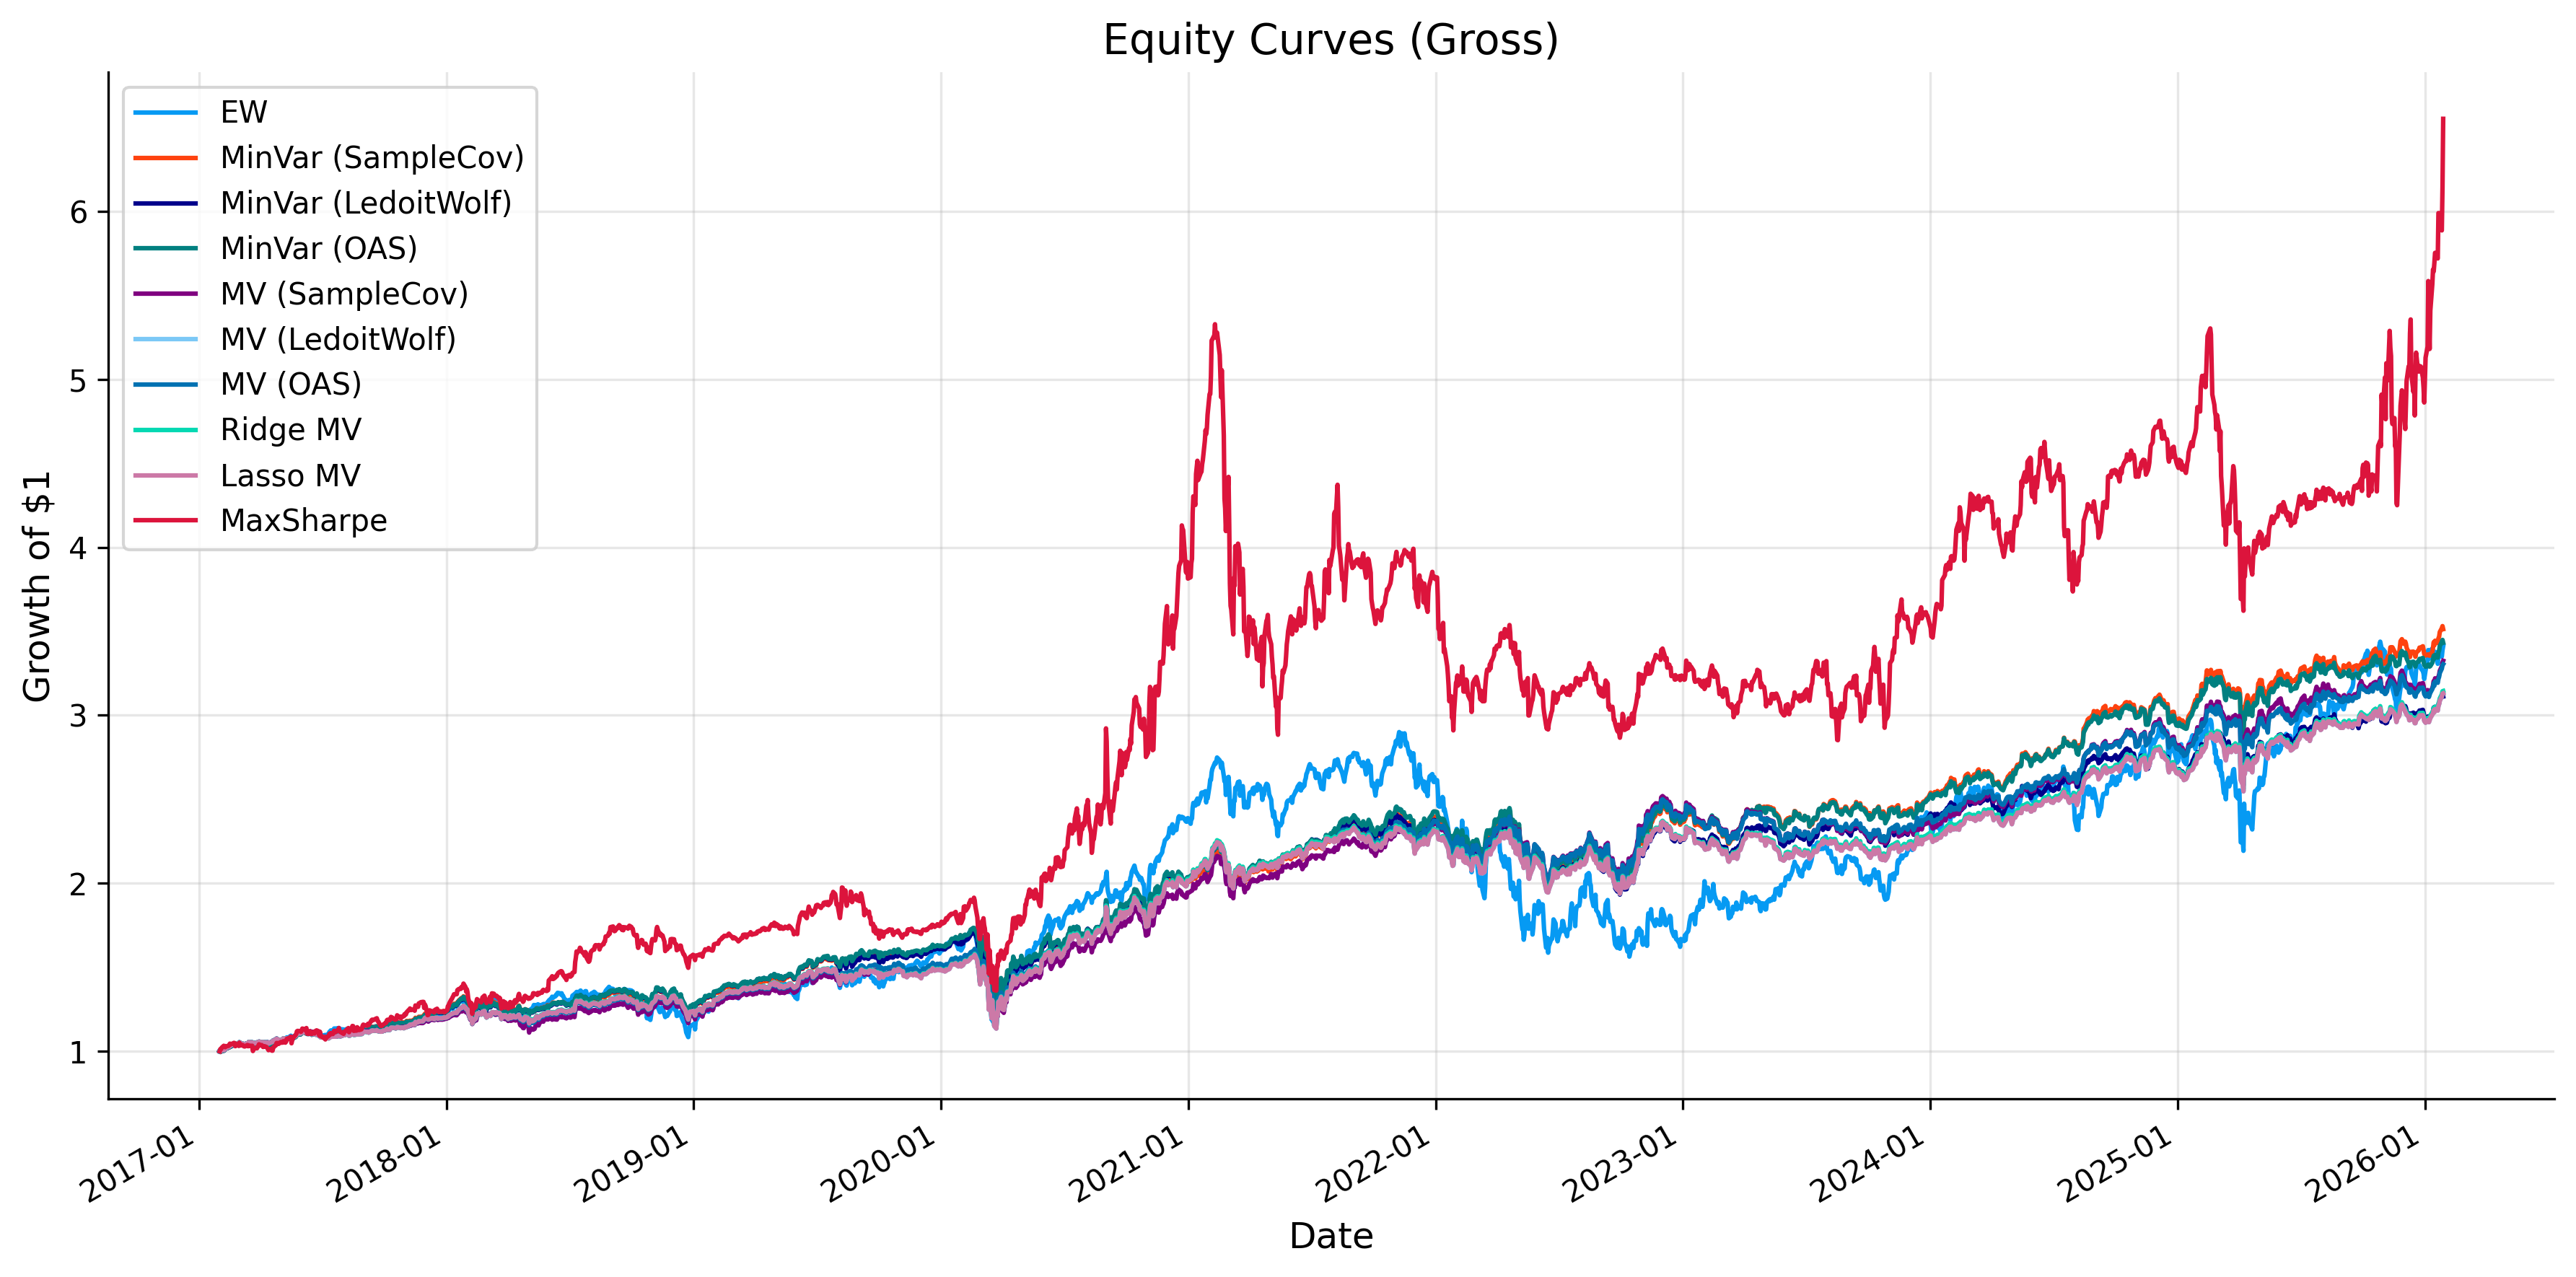

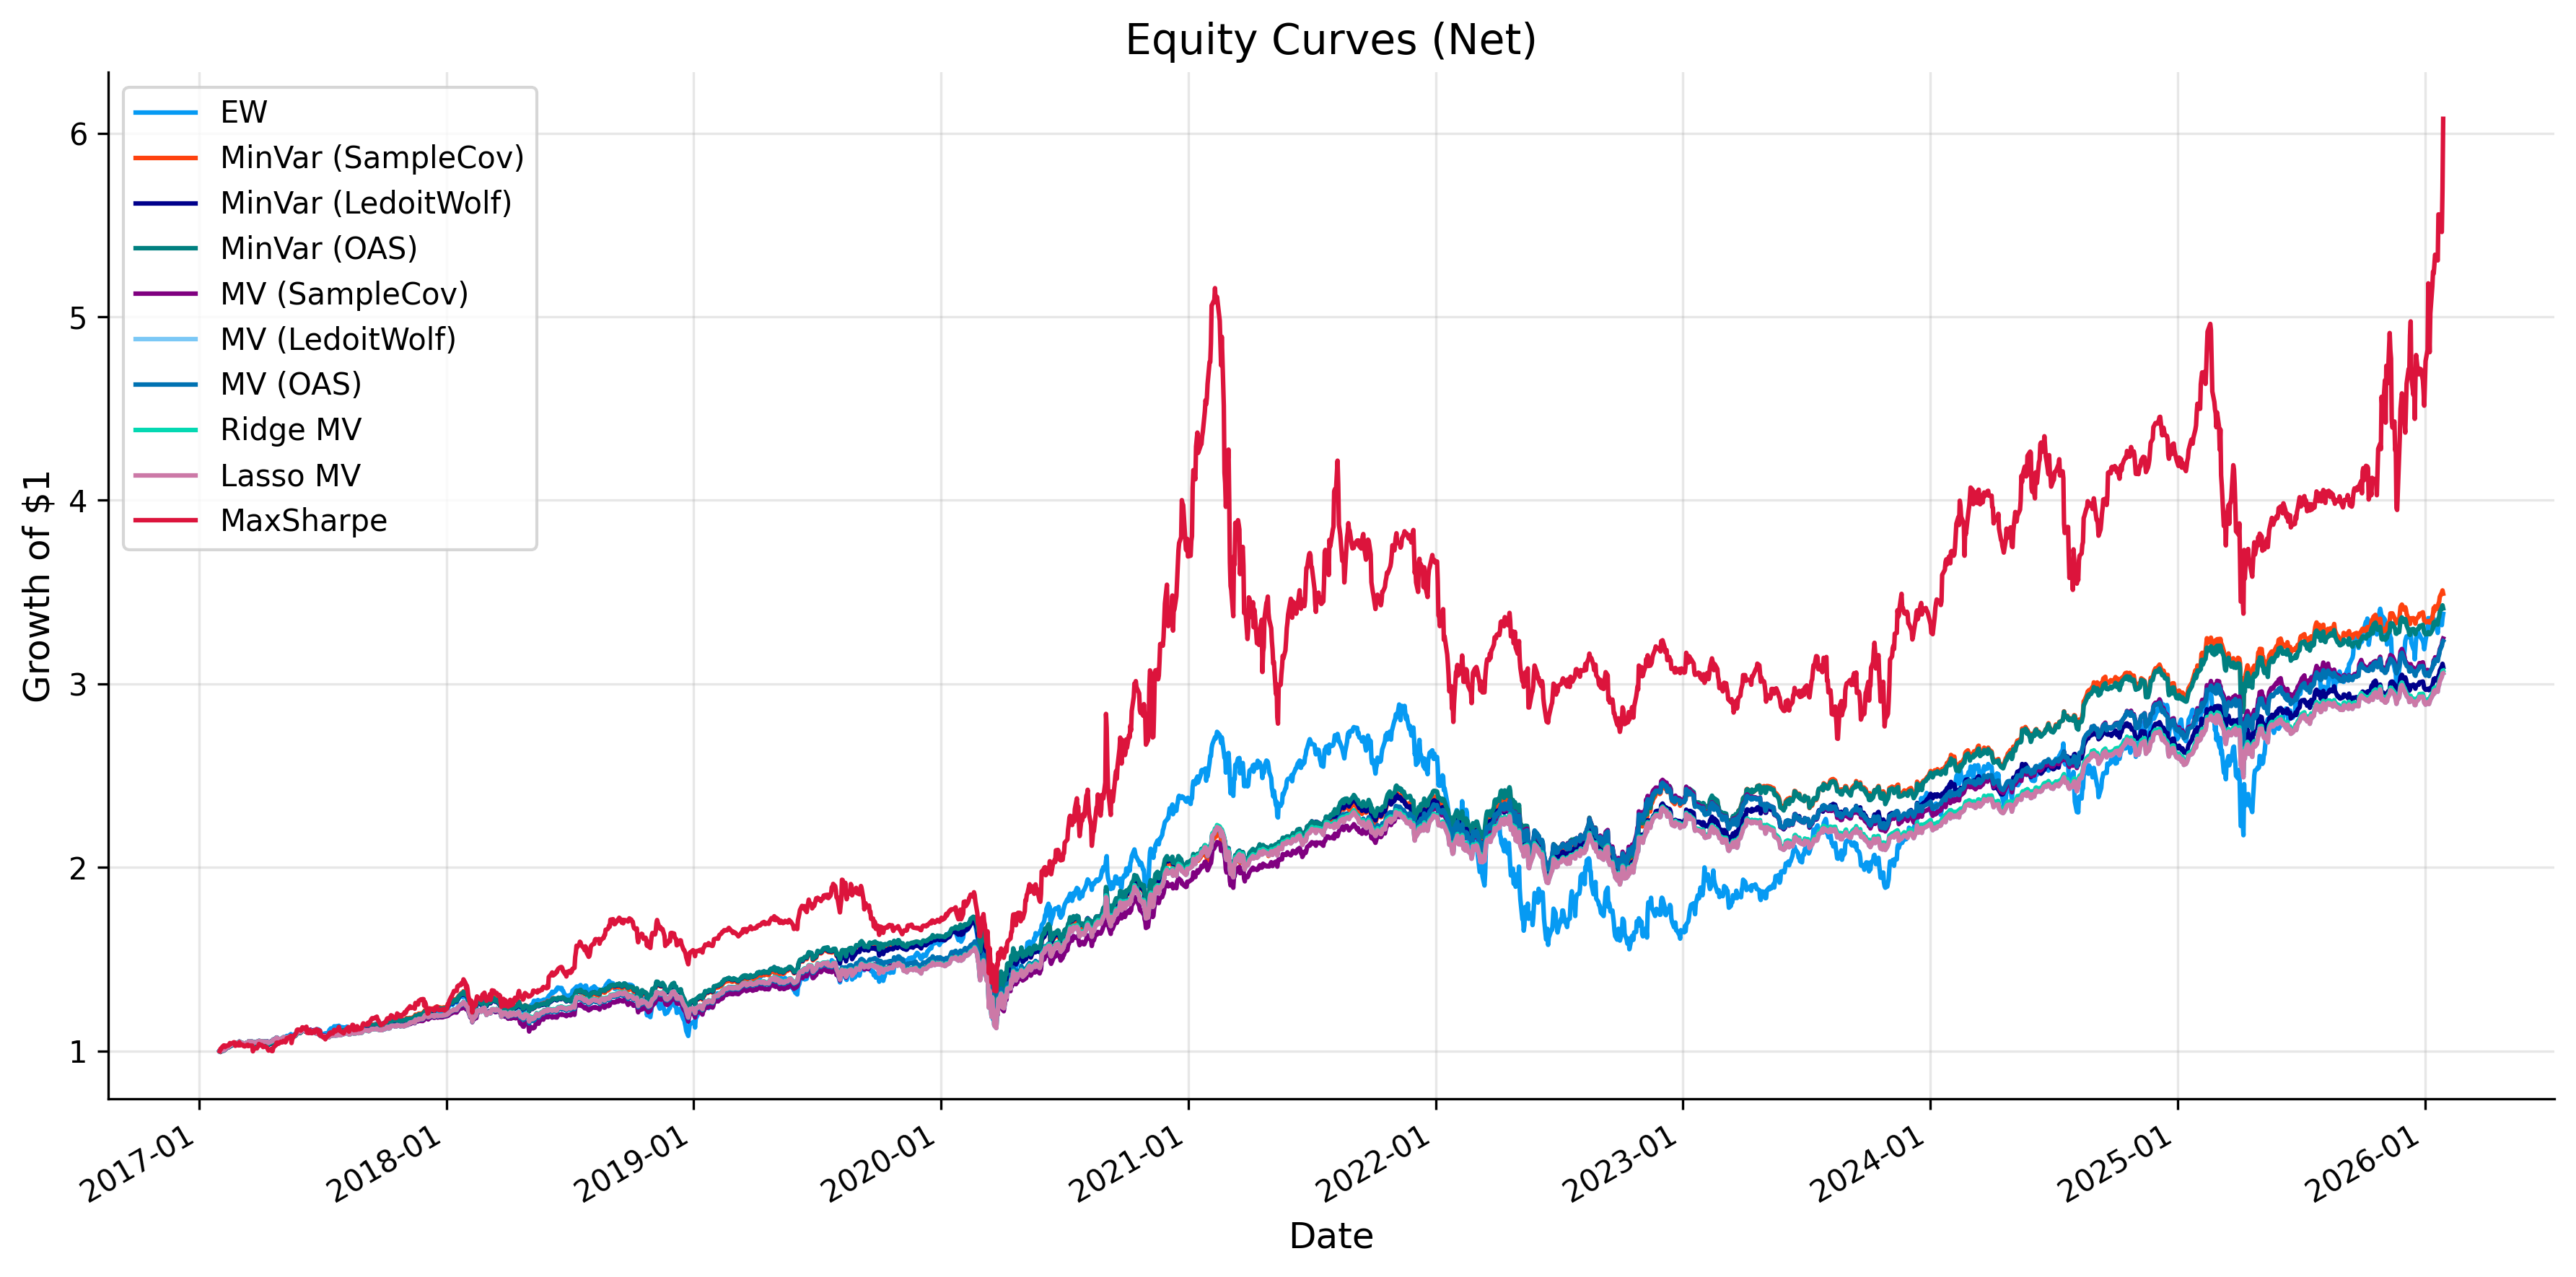

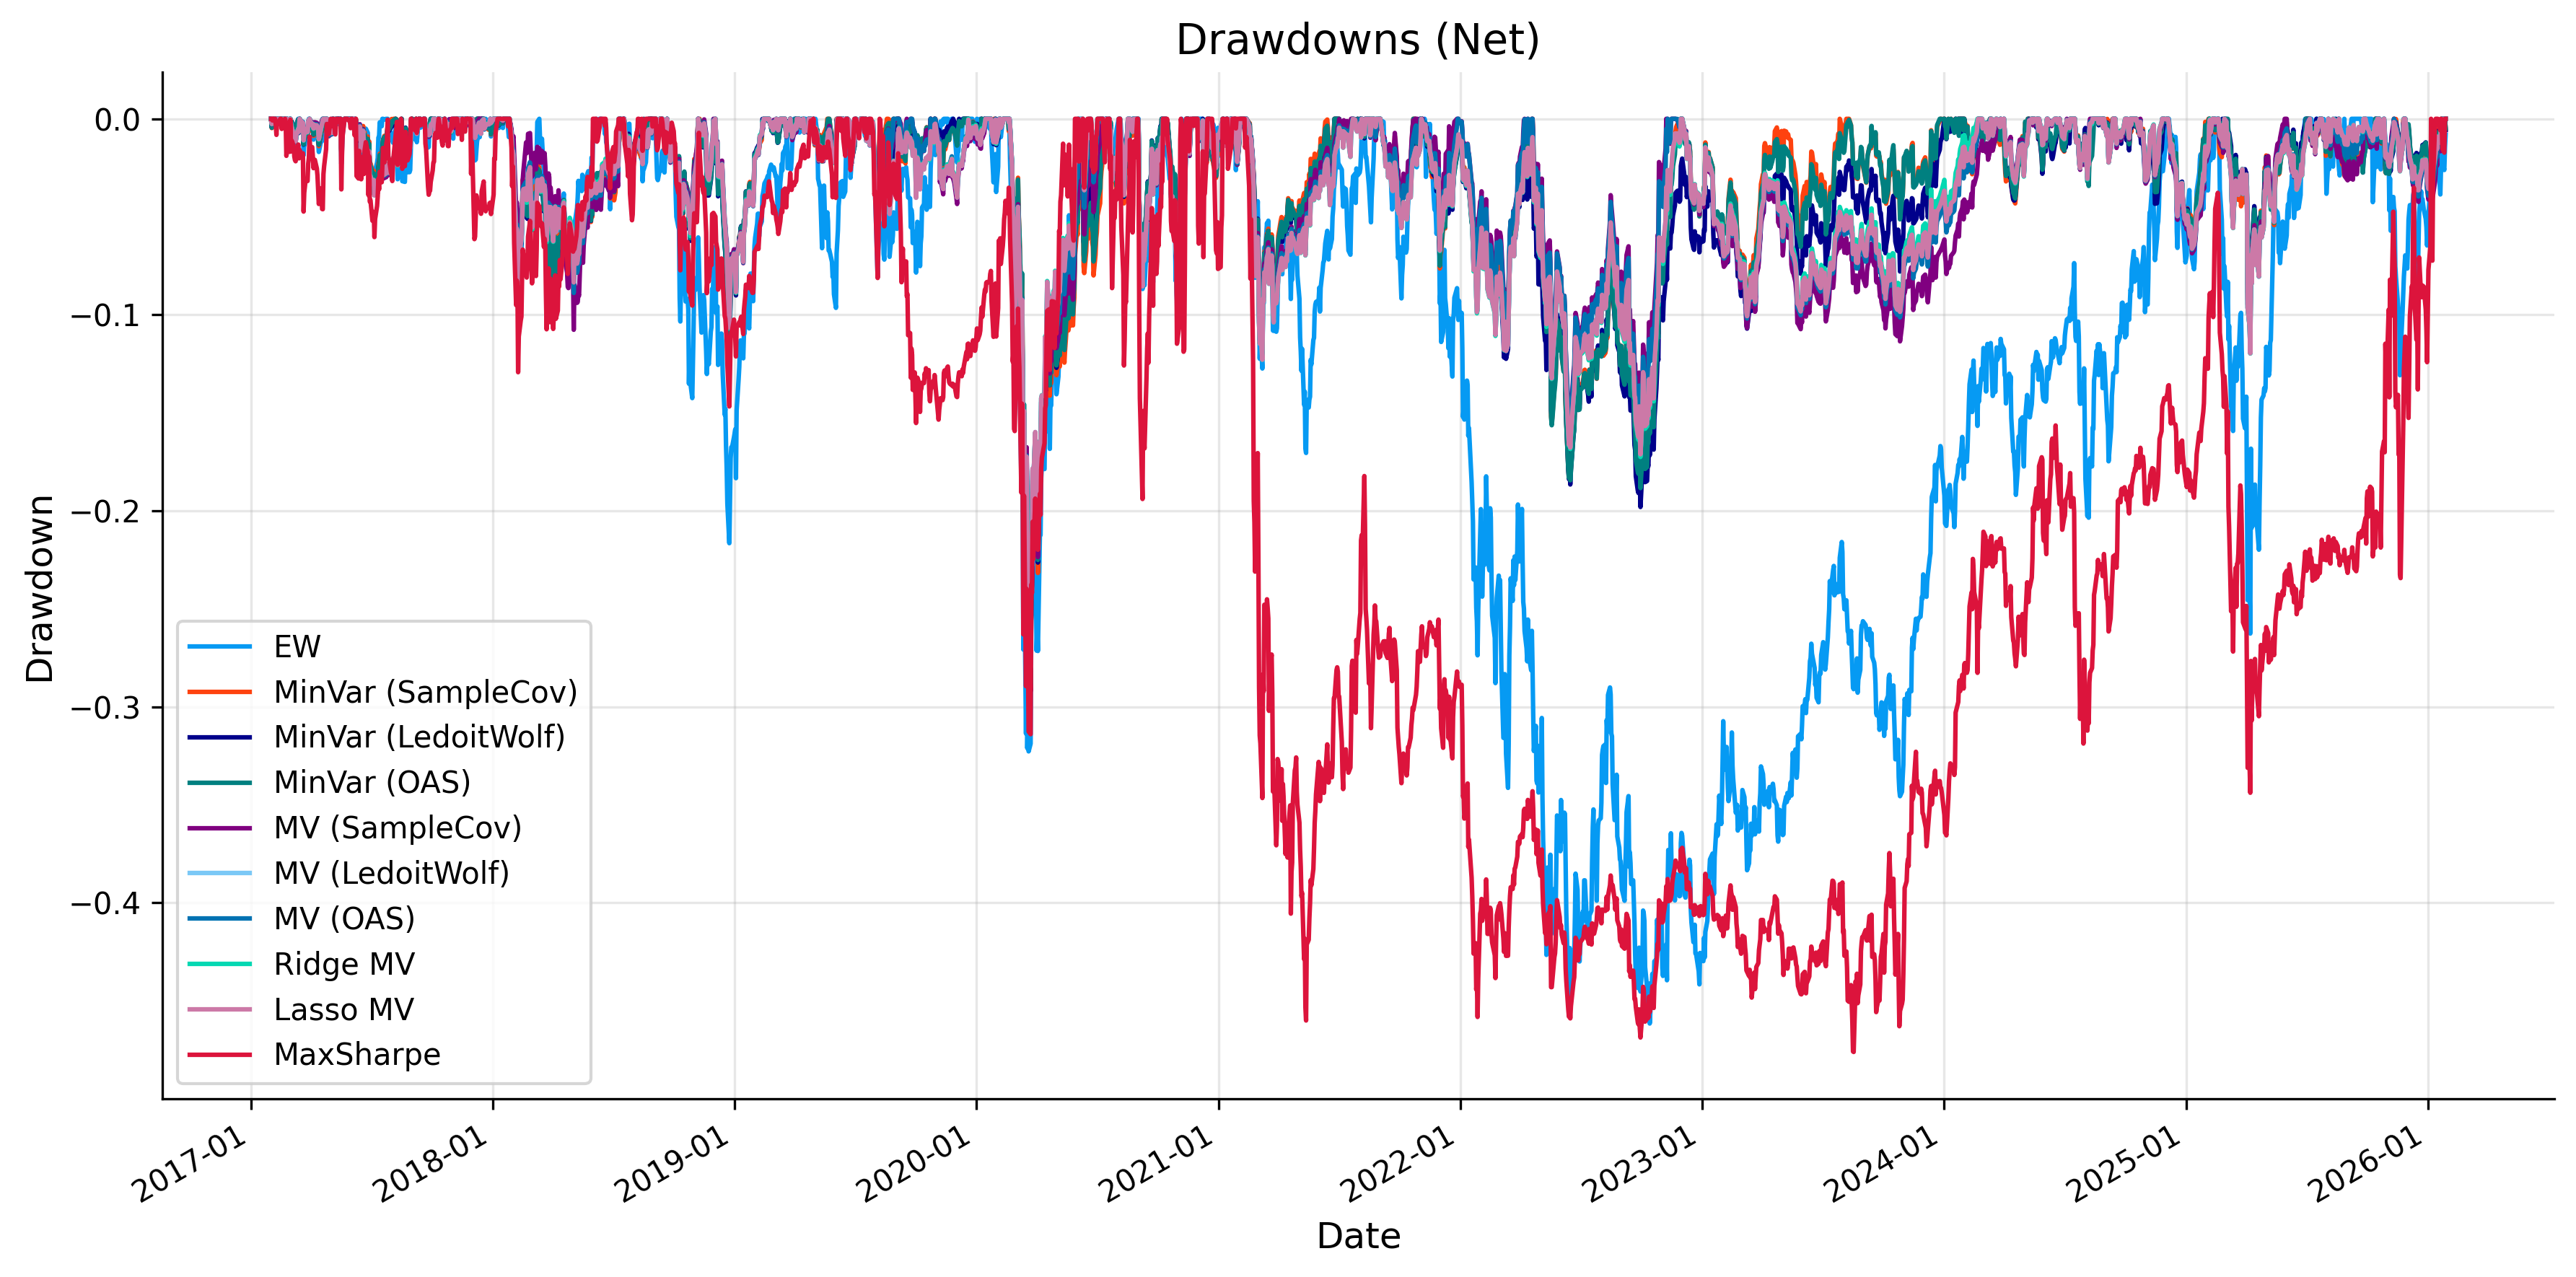

In [6]:
import warnings
warnings.filterwarnings("ignore")

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.dates import DateFormatter
from scipy.optimize import minimize
from sklearn.covariance import LedoitWolf, OAS

# ===== minimal settings (same behavior as main cell) =====
DATA_PATH = r"E:\daneshgah\quantitative-finance-lab\data\nasdaq_all_close_volume.parquet"
DATE_COL = "Date"
START = "2016-01-01"
END = None
RETURNS_TYPE = "simple"
REBAL_FREQ = "M"
LOOKBACK = 250
LIQ_LOOKBACK = 250
TOP_N = 100
MIN_HISTORY = 250

RISK_FREE_ANNUAL = 0.02
LONG_ONLY, W_MIN, W_MAX = True, 0.0, 0.40
COSTS_ENABLED, COST_BPS, FIXED_FEE = True, 10.0, 0.0

MV_LAMBDA = 32.0
RIDGE_MV_GAMMA = 8.0
LASSO_MV_GAMMA = 1.5
RIDGE_OBJ = 1e-4
TURNOVER_PENALTY_BPS = 0.0
USE_COST_AS_PENALTY = True
SOLVER_ORDER = ["OSQP", "ECOS", "SCS"]
JITTER, PSD_EPS, MAX_ITER = 1e-10, 1e-10, 8000

MU_MODE = "6-1"
WINSOR_LO, WINSOR_HI = 0.05, 0.95
TARGET_SHARPE_ANN, MU_CAP_ANN = 0.80, 0.30
APPLY_MU_SHRINK, MU_SHRINK = False, 0.40

BLEND = {
    "MV (SampleCov)": 0.15,
    "MV (LedoitWolf)": 0.15,
    "MV (OAS)": 0.15,
    "Ridge MV": 0.15,
    "Lasso MV": 0.15,
    "MaxSharpe": 0.10,
    "MinVar (SampleCov)": 0.20,
    "MinVar (LedoitWolf)": 0.20,
    "MinVar (OAS)": 0.20,
}

strategy_cov_key = {
    "EW": "LedoitWolf",
    "MinVar (SampleCov)": "SampleCov",
    "MinVar (LedoitWolf)": "LedoitWolf",
    "MinVar (OAS)": "OAS",
    "MV (SampleCov)": "SampleCov",
    "MV (LedoitWolf)": "LedoitWolf",
    "MV (OAS)": "OAS",
    "Ridge MV": "LedoitWolf",
    "Lasso MV": "LedoitWolf",
    "MaxSharpe": "LedoitWolf",
}
strategy_names = list(strategy_cov_key.keys())

# ===== quick helpers =====
def format_date_axis(ax):
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    ax.figure.autofmt_xdate()

def print_warn(msg):
    print(f"[WARN] {msg}")

def make_psd(sigma, eps=1e-10):
    sigma = 0.5 * (sigma + sigma.T)
    vals, vecs = np.linalg.eigh(sigma)
    vals = np.maximum(vals, eps)
    out = (vecs * vals) @ vecs.T
    return 0.5 * (out + out.T)

def safe_normalize_weights(w, w_min, w_max, long_only):
    w = np.asarray(w, dtype=np.float64).flatten()
    if long_only:
        w = np.maximum(w, 0.0)
    if w_min is not None:
        w = np.maximum(w, w_min)
    if w_max is not None:
        w = np.minimum(w, w_max)
    s = w.sum()
    if (not np.isfinite(s)) or s <= 0:
        return None
    w = w / s
    for _ in range(2):
        if long_only:
            w = np.maximum(w, 0.0)
        if w_min is not None:
            w = np.maximum(w, w_min)
        if w_max is not None:
            w = np.minimum(w, w_max)
        s = w.sum()
        if s <= 0:
            return None
        w = w / s
    return w

def blend_weights(w_star, w_prev, eta):
    eta = float(np.clip(eta, 0.0, 1.0))
    return (1.0 - eta) * np.asarray(w_star, dtype=np.float64) + eta * np.asarray(w_prev, dtype=np.float64)

def constraints_feasible(nn, w_min, w_max, long_only):
    w_min_eff = 0.0 if long_only else (-np.inf if w_min is None else w_min)
    w_max_eff = np.inf if w_max is None else w_max
    if np.isfinite(w_max_eff) and w_max_eff * nn < 1.0 - 1e-9:
        return False
    if np.isfinite(w_min_eff) and w_min_eff * nn > 1.0 + 1e-9:
        return False
    return True

def rebalances_per_year(rebal_dates_index):
    if len(rebal_dates_index) < 2:
        return 1.0
    d = pd.to_datetime(rebal_dates_index).values
    gaps = np.diff(d).astype("timedelta64[D]").astype(int)
    med_days = max(float(np.median(gaps)), 1.0)
    return 252.0 / med_days

def tc_rate_from_delta(delta):
    if not COSTS_ENABLED:
        return 0.0
    return float((COST_BPS / 10000.0) * np.sum(np.abs(delta)))

def kappa_annual(rebals_per_year_value):
    k = 0.0
    if USE_COST_AS_PENALTY and COSTS_ENABLED:
        k += COST_BPS / 10000.0
    k += TURNOVER_PENALTY_BPS / 10000.0
    return float(rebals_per_year_value * k)

def momentum_score_from_returns(ret_window, mode="6-1"):
    R = ret_window.replace([np.inf, -np.inf], np.nan).dropna(how="any")
    T = len(R)
    if T < 80:
        return R.mean().values.astype(np.float64)
    if mode == "12-1":
        lookback, skip = 252, 21
    elif mode == "6-1":
        lookback, skip = 126, 21
    elif mode == "3-0":
        lookback, skip = 63, 0
    else:
        raise ValueError("Unknown momentum mode")
    if T < lookback + skip + 5:
        lookback = min(lookback, max(63, T - skip - 1))
    R_use = R.iloc[-(lookback + skip):]
    R_mom = R_use.iloc[:-skip] if skip > 0 else R_use
    return ((1.0 + R_mom).prod(axis=0) - 1.0).values.astype(np.float64)

def winsorize_and_zscore(x, p_lo=0.05, p_hi=0.95):
    x = np.asarray(x, dtype=np.float64)
    lo, hi = np.quantile(x, [p_lo, p_hi])
    x = np.clip(x, lo, hi)
    x = x - x.mean()
    return x / (x.std() + 1e-12)

def scale_mu_to_target_sharpe(mu_dir, cov_ann, target_sharpe_ann, mu_cap_ann):
    mu = np.asarray(mu_dir, dtype=np.float64).flatten()
    if np.all(np.abs(mu) < 1e-12):
        return np.zeros_like(mu)
    A = cov_ann + 1e-8 * np.eye(cov_ann.shape[0])
    try:
        x = np.linalg.solve(A, mu)
    except np.linalg.LinAlgError:
        x = np.linalg.lstsq(A, mu, rcond=None)[0]
    q = float(mu @ x)
    if (not np.isfinite(q)) or q <= 1e-18:
        return np.zeros_like(mu)
    s = float(target_sharpe_ann) / np.sqrt(q)
    return np.clip(s * mu, -mu_cap_ann, mu_cap_ann)

# ===== load close/volume =====
df = pd.read_parquet(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL)

close_map, vol_map = {}, {}
for c in df.columns:
    c = str(c)
    if c == DATE_COL or "__" not in c:
        continue
    t, f = c.rsplit("__", 1)
    f = f.lower()
    if f == "close":
        close_map[t] = c
    elif f == "volume":
        vol_map[t] = c
common = sorted(set(close_map).intersection(vol_map))
if len(common) < 2:
    raise ValueError("Not enough close/volume ticker pairs.")

close_prices = df[[close_map[t] for t in common]].copy(); close_prices.columns = common
volumes = df[[vol_map[t] for t in common]].copy(); volumes.columns = common
close_prices.index = df[DATE_COL]
volumes.index = df[DATE_COL]

close_prices = close_prices.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan).astype(np.float32)
volumes = volumes.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan).astype(np.float32)

start = pd.Timestamp(START)
end = pd.Timestamp(END) if END else None
close_prices = close_prices.loc[close_prices.index >= start]
volumes = volumes.loc[volumes.index >= start]
if end is not None:
    close_prices = close_prices.loc[close_prices.index <= end]
    volumes = volumes.loc[volumes.index <= end]

idx = close_prices.index.intersection(volumes.index)
cols = close_prices.columns.intersection(volumes.columns)
close_prices = close_prices.loc[idx, cols]
volumes = volumes.loc[idx, cols]

if RETURNS_TYPE == "log":
    returns = np.log(close_prices).diff()
else:
    returns = close_prices.pct_change(fill_method=None)
returns = returns.replace([np.inf, -np.inf], np.nan).astype(np.float32)

# ===== optimization solvers =====
cvx_cache = {}

def solve_cvx(prob, var):
    for solver in SOLVER_ORDER:
        try:
            prob.solve(solver=solver, warm_start=True, max_iter=MAX_ITER)
            if var.value is not None:
                w = np.asarray(var.value, dtype=np.float64).flatten()
                if np.all(np.isfinite(w)):
                    return w
        except Exception:
            continue
    return None

def get_mv_solver(nn, mv_lambda, ridge, kappa):
    key = ("mv", nn, mv_lambda, ridge, kappa, W_MIN, W_MAX, LONG_ONLY)
    if key in cvx_cache:
        return cvx_cache[key]
    w = cp.Variable(nn)
    mu = cp.Parameter(nn)
    S = cp.Parameter((nn, nn), PSD=True)
    w_prev = cp.Parameter(nn)
    cons = []
    if LONG_ONLY:
        cons.append(w >= 0)
    if W_MIN is not None:
        cons.append(w >= W_MIN)
    if W_MAX is not None:
        cons.append(w <= W_MAX)
    cons.append(cp.sum(w) == 1)
    obj = cp.Maximize(mu @ w - 0.5 * mv_lambda * cp.quad_form(w, S) - kappa * cp.norm1(w - w_prev) - 0.5 * ridge * cp.sum_squares(w))
    prob = cp.Problem(obj, cons)
    cvx_cache[key] = (prob, w, mu, S, w_prev)
    return prob, w, mu, S, w_prev

def get_reg_mv_solver(nn, mv_lambda, ridge, kappa, gamma_l1, gamma_l2):
    key = ("reg_mv", nn, mv_lambda, ridge, kappa, gamma_l1, gamma_l2, W_MIN, W_MAX, LONG_ONLY)
    if key in cvx_cache:
        return cvx_cache[key]
    w = cp.Variable(nn)
    mu = cp.Parameter(nn)
    S = cp.Parameter((nn, nn), PSD=True)
    w_prev = cp.Parameter(nn)
    cons = []
    if LONG_ONLY:
        cons.append(w >= 0)
    if W_MIN is not None:
        cons.append(w >= W_MIN)
    if W_MAX is not None:
        cons.append(w <= W_MAX)
    cons.append(cp.sum(w) == 1)
    obj = cp.Maximize(mu @ w - 0.5 * mv_lambda * cp.quad_form(w, S) - kappa * cp.norm1(w - w_prev) - 0.5 * ridge * cp.sum_squares(w) - gamma_l1 * cp.norm1(w) - 0.5 * gamma_l2 * cp.sum_squares(w))
    prob = cp.Problem(obj, cons)
    cvx_cache[key] = (prob, w, mu, S, w_prev)
    return prob, w, mu, S, w_prev

def get_minvar_solver(nn, ridge, kappa):
    key = ("minvar", nn, ridge, kappa, W_MIN, W_MAX, LONG_ONLY)
    if key in cvx_cache:
        return cvx_cache[key]
    w = cp.Variable(nn)
    S = cp.Parameter((nn, nn), PSD=True)
    w_prev = cp.Parameter(nn)
    cons = []
    if LONG_ONLY:
        cons.append(w >= 0)
    if W_MIN is not None:
        cons.append(w >= W_MIN)
    if W_MAX is not None:
        cons.append(w <= W_MAX)
    cons.append(cp.sum(w) == 1)
    obj = cp.Minimize(cp.quad_form(w, S) + kappa * cp.norm1(w - w_prev) + 0.5 * ridge * cp.sum_squares(w))
    prob = cp.Problem(obj, cons)
    cvx_cache[key] = (prob, w, S, w_prev)
    return prob, w, S, w_prev

def mv_weights(mu_excess_ann, cov_ann, w_prev, rpy):
    nn = len(mu_excess_ann)
    if not constraints_feasible(nn, W_MIN, W_MAX, LONG_ONLY):
        return None
    prob, w_var, mu_p, S_p, wprev_p = get_mv_solver(nn, MV_LAMBDA, RIDGE_OBJ, kappa_annual(rpy))
    mu_p.value = np.asarray(mu_excess_ann, dtype=np.float64)
    S_p.value = np.asarray(cov_ann, dtype=np.float64)
    wprev_p.value = np.asarray(w_prev, dtype=np.float64)
    w = solve_cvx(prob, w_var)
    return None if w is None else safe_normalize_weights(w, W_MIN, W_MAX, LONG_ONLY)

def ridge_mv_weights(mu_excess_ann, cov_ann, w_prev, rpy):
    nn = len(mu_excess_ann)
    if not constraints_feasible(nn, W_MIN, W_MAX, LONG_ONLY):
        return None
    g2 = RIDGE_MV_GAMMA / max(nn, 1)
    prob, w_var, mu_p, S_p, wprev_p = get_reg_mv_solver(nn, MV_LAMBDA, RIDGE_OBJ, kappa_annual(rpy), 0.0, g2)
    mu_p.value = np.asarray(mu_excess_ann, dtype=np.float64)
    S_p.value = np.asarray(cov_ann, dtype=np.float64)
    wprev_p.value = np.asarray(w_prev, dtype=np.float64)
    w = solve_cvx(prob, w_var)
    return None if w is None else safe_normalize_weights(w, W_MIN, W_MAX, LONG_ONLY)

def lasso_mv_weights(mu_excess_ann, cov_ann, w_prev, rpy):
    nn = len(mu_excess_ann)
    if not constraints_feasible(nn, W_MIN, W_MAX, LONG_ONLY):
        return None
    g1 = LASSO_MV_GAMMA / max(nn, 1)
    prob, w_var, mu_p, S_p, wprev_p = get_reg_mv_solver(nn, MV_LAMBDA, RIDGE_OBJ, kappa_annual(rpy), g1, 0.0)
    mu_p.value = np.asarray(mu_excess_ann, dtype=np.float64)
    S_p.value = np.asarray(cov_ann, dtype=np.float64)
    wprev_p.value = np.asarray(w_prev, dtype=np.float64)
    w = solve_cvx(prob, w_var)
    return None if w is None else safe_normalize_weights(w, W_MIN, W_MAX, LONG_ONLY)

def minvar_weights(cov_ann, w_prev, rpy):
    nn = cov_ann.shape[0]
    if not constraints_feasible(nn, W_MIN, W_MAX, LONG_ONLY):
        return None
    prob, w_var, S_p, wprev_p = get_minvar_solver(nn, RIDGE_OBJ, kappa_annual(rpy))
    S_p.value = np.asarray(cov_ann, dtype=np.float64)
    wprev_p.value = np.asarray(w_prev, dtype=np.float64)
    w = solve_cvx(prob, w_var)
    return None if w is None else safe_normalize_weights(w, W_MIN, W_MAX, LONG_ONLY)

def max_sharpe_weights(mu_excess_ann, cov_ann, w_prev, rpy):
    nn = len(mu_excess_ann)
    if not constraints_feasible(nn, W_MIN, W_MAX, LONG_ONLY):
        return None
    bounds = [(0.0 if LONG_ONLY else (-1.0 if W_MIN is None else W_MIN), 1.0 if W_MAX is None else W_MAX) for _ in range(nn)]
    x0 = np.ones(nn, dtype=np.float64) / nn
    kappa, ridge = kappa_annual(rpy), RIDGE_OBJ
    mu_use = np.asarray(mu_excess_ann, dtype=np.float64)

    def neg_obj(w):
        w = np.asarray(w, dtype=np.float64)
        if np.any(~np.isfinite(w)):
            return 1e6
        ret = float(mu_use @ w)
        vol = float(np.sqrt(w @ cov_ann @ w))
        if vol < 1e-12:
            return 1e6
        return -(ret / vol) + kappa * np.sum(np.abs(w - w_prev)) + 0.5 * ridge * np.sum(w**2)

    res = minimize(neg_obj, x0, method="SLSQP", bounds=bounds, constraints=({"type": "eq", "fun": lambda w: np.sum(w) - 1.0},), options={"maxiter": MAX_ITER})
    if (not res.success) or np.any(~np.isfinite(res.x)):
        return None
    return safe_normalize_weights(res.x, W_MIN, W_MAX, LONG_ONLY)

# ===== liquidity + estimation cache =====
def select_liquid_universe(close_window, volume_window, top_n, min_history_days):
    valid_close = close_window.notna().sum(axis=0) >= min_history_days
    valid_volume = volume_window.notna().sum(axis=0) >= min_history_days
    complete_close = close_window.notna().all(axis=0)
    complete_volume = volume_window.notna().all(axis=0)
    positive = (close_window > 0).all(axis=0) & (volume_window > 0).all(axis=0)
    eligible = close_window.columns[valid_close & valid_volume & complete_close & complete_volume & positive]
    if len(eligible) == 0:
        return [], pd.Series(dtype=np.float32)
    dollar_volume = (close_window[eligible] * volume_window[eligible]).mean(axis=0, skipna=False)
    dollar_volume = dollar_volume.replace([np.inf, -np.inf], np.nan).dropna()
    top = dollar_volume.nlargest(min(int(top_n), len(dollar_volume)))
    return top.index.tolist(), top.astype(np.float32)

def estimate_covariance_maps(window):
    x = window.values.astype(np.float64)
    nn = x.shape[1]
    cov_daily = {
        "SampleCov": np.cov(x, rowvar=False, ddof=1).astype(np.float64),
        "LedoitWolf": LedoitWolf().fit(x).covariance_.astype(np.float64),
        "OAS": OAS().fit(x).covariance_.astype(np.float64),
    }
    out = {}
    for k, c in cov_daily.items():
        c = 0.5 * (c + c.T)
        c += JITTER * np.eye(nn)
        out[k] = 252.0 * make_psd(c, PSD_EPS)
    return out

rebal_dates = returns.resample(REBAL_FREQ).last().index.intersection(returns.index)
cache = {}

for dt in rebal_dates:
    pos = returns.index.get_loc(dt)
    if isinstance(pos, slice):
        pos = pos.stop - 1
    if pos < max(LOOKBACK, LIQ_LOOKBACK):
        continue

    close_window = close_prices.iloc[pos - LIQ_LOOKBACK:pos]
    volume_window = volumes.iloc[pos - LIQ_LOOKBACK:pos]
    if close_window.shape[0] < LIQ_LOOKBACK or volume_window.shape[0] < LIQ_LOOKBACK:
        continue

    liquid_tickers, avg_dollar_volume = select_liquid_universe(close_window, volume_window, TOP_N, MIN_HISTORY)
    if len(liquid_tickers) < 2:
        continue

    close_for_model = close_prices[liquid_tickers].iloc[pos - LOOKBACK:pos]
    if close_for_model.shape[0] < LOOKBACK:
        continue

    if RETURNS_TYPE == "log":
        window = np.log(close_for_model).diff().iloc[1:]
    else:
        window = close_for_model.pct_change(fill_method=None).iloc[1:]

    window = window.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")
    if window.shape[0] < LOOKBACK - 1 or window.shape[1] < 2:
        continue

    active_tickers = window.columns.tolist()
    window = window.astype(np.float32)
    cov_ann_map = estimate_covariance_maps(window)
    cov_ann = cov_ann_map["LedoitWolf"]

    score = momentum_score_from_returns(window, mode=MU_MODE)
    z = winsorize_and_zscore(score, WINSOR_LO, WINSOR_HI)
    mu_excess_ann = scale_mu_to_target_sharpe(z, cov_ann, TARGET_SHARPE_ANN, MU_CAP_ANN)

    cache[dt] = {
        "R": window,
        "mu_excess_ann": mu_excess_ann,
        "cov_ann_map": cov_ann_map,
        "tickers": active_tickers,
        "avg_dollar_volume": avg_dollar_volume.reindex(active_tickers).astype(np.float32),
    }

rebal_dates = [d for d in rebal_dates if d in cache]
if len(rebal_dates) == 0:
    raise ValueError("No rebalance dates with sufficient 250-day history and liquidity data.")

universe_size = pd.Series({dt: len(cache[dt]["tickers"]) for dt in rebal_dates}, name="UniverseSize")
print(f"Universe size across rebalances: min={universe_size.min()}, max={universe_size.max()}, mean={universe_size.mean():.1f}")

REBALS_PER_YEAR = rebalances_per_year(rebal_dates)
rf_daily = (1.0 + RISK_FREE_ANNUAL) ** (1.0 / 252.0) - 1.0

# ===== backtest =====
def backtest_strategy(name, cov_key):
    all_dates = returns.loc[rebal_dates[0]:].index
    rebal_set = set(rebal_dates)

    w = pd.Series(dtype=np.float64)
    gross_value, net_value = 1.0, 1.0
    gross_values, net_values, gross_returns = [], [], []
    weights_rebal = {}
    turnover_list, cost_list = [], []
    fallback_count = 0

    for dt in all_dates:
        if w.empty:
            port_ret = 0.0
            w_drift = pd.Series(dtype=np.float64)
        else:
            r_today = returns.loc[dt].reindex(w.index).fillna(0.0).astype(np.float64)
            port_ret = float(np.dot(w.values, r_today.values))
            grossed = w.values * (1.0 + r_today.values)
            gs = float(grossed.sum())
            w_drift = pd.Series(grossed / gs, index=w.index, dtype=np.float64) if gs > 0 and np.isfinite(gs) else pd.Series(dtype=np.float64)

        gross_value *= (1.0 + port_ret)
        net_value *= (1.0 + port_ret)
        gross_values.append(gross_value)
        net_values.append(net_value)
        gross_returns.append(port_ret)

        if dt in rebal_set:
            st = cache[dt]
            mu_excess_ann = st["mu_excess_ann"]
            cov_ann = st["cov_ann_map"][cov_key]
            active_tickers = st["tickers"]
            nn = len(active_tickers)
            if nn < 2:
                w = w_drift
                continue

            mu_use = (1.0 - MU_SHRINK) * mu_excess_ann if APPLY_MU_SHRINK else mu_excess_ann
            w_pre = w_drift.reindex(active_tickers).fillna(0.0).astype(np.float64)
            s = float(w_pre.sum())
            w_pre = (w_pre / s) if s > 0 else pd.Series(np.ones(nn, dtype=np.float64) / nn, index=active_tickers)

            if name == "EW":
                w_tar = np.ones(nn, dtype=np.float64) / nn
            elif name.startswith("MinVar"):
                w_tar = minvar_weights(cov_ann, w_pre.values, REBALS_PER_YEAR)
            elif name.startswith("MV"):
                w_tar = mv_weights(mu_use, cov_ann, w_pre.values, REBALS_PER_YEAR)
            elif name == "Ridge MV":
                w_tar = ridge_mv_weights(mu_use, cov_ann, w_pre.values, REBALS_PER_YEAR)
            elif name == "Lasso MV":
                w_tar = lasso_mv_weights(mu_use, cov_ann, w_pre.values, REBALS_PER_YEAR)
            elif name == "MaxSharpe":
                w_tar = max_sharpe_weights(mu_use, cov_ann, w_pre.values, REBALS_PER_YEAR)
            else:
                w_tar = None

            if w_tar is None or np.any(~np.isfinite(w_tar)):
                print_warn(f"{name} failed on {dt.date()}, fallback to EW")
                w_tar = np.ones(nn, dtype=np.float64) / nn
                fallback_count += 1

            w_tar = blend_weights(w_tar, w_pre.values, float(BLEND.get(name, 0.0)))
            w_tar = safe_normalize_weights(w_tar, W_MIN, W_MAX, LONG_ONLY)
            if w_tar is None:
                print_warn(f"{name} infeasible on {dt.date()}, fallback to EW")
                w_tar = np.ones(nn, dtype=np.float64) / nn
                fallback_count += 1

            delta = w_tar - w_pre.values
            turnover = 0.5 * np.sum(np.abs(delta))
            cost_value = 0.0
            if COSTS_ENABLED:
                cost_rate = tc_rate_from_delta(delta)
                cost_value = net_value * cost_rate
                net_value = max(net_value - cost_value, 1e-12)
                if FIXED_FEE > 0:
                    fee = FIXED_FEE * np.count_nonzero(np.abs(delta) > 1e-12)
                    net_value = max(net_value - fee, 1e-12)
                    cost_value += fee

            turnover_list.append(turnover)
            cost_list.append(cost_value)
            weights_rebal[dt] = pd.Series(w_tar.astype(np.float32), index=active_tickers)
            w = pd.Series(w_tar, index=active_tickers, dtype=np.float64)
        else:
            w = w_drift

    gross_values = pd.Series(gross_values, index=all_dates, name=f"{name}_gross")
    net_values = pd.Series(net_values, index=all_dates, name=f"{name}_net")
    gross_returns = pd.Series(gross_returns, index=all_dates, name=f"{name}_gross_ret")
    net_returns = net_values.pct_change().fillna(0.0)

    wdf = pd.DataFrame.from_dict(weights_rebal, orient="index")
    if not wdf.empty:
        wdf = wdf.fillna(0.0)

    return {
        "gross_values": gross_values,
        "net_values": net_values,
        "gross_returns": gross_returns,
        "net_returns": net_returns,
        "weights": wdf,
        "turnover": pd.Series(turnover_list, index=wdf.index) if len(wdf) else pd.Series([], dtype=float),
        "costs": pd.Series(cost_list, index=wdf.index) if len(wdf) else pd.Series([], dtype=float),
        "fallbacks": fallback_count,
    }

results = {name: backtest_strategy(name, strategy_cov_key[name]) for name in strategy_names}

# ===== same summaries =====
def calc_drawdown(series):
    return series / series.cummax() - 1.0

def performance_metrics(net_returns, net_values):
    years = len(net_returns) / 252.0
    cagr = (net_values.iloc[-1] ** (1.0 / years) - 1.0) if years > 0 else 0.0
    vol = net_returns.std() * np.sqrt(252.0)
    excess = net_returns - rf_daily
    sharpe = (excess.mean() / net_returns.std()) * np.sqrt(252.0) if net_returns.std() > 0 else np.nan
    dd = calc_drawdown(net_values)
    max_dd = dd.min()
    calmar = cagr / abs(max_dd) if max_dd < 0 else np.nan
    downside = net_returns[net_returns < 0]
    sortino = (excess.mean() / downside.std()) * np.sqrt(252.0) if downside.std() > 0 else np.nan
    return cagr, vol, sharpe, max_dd, calmar, sortino

metrics_rows = []
for name, res in results.items():
    metrics_rows.append([name, *performance_metrics(res["net_returns"], res["net_values"])])

metrics_df = pd.DataFrame(metrics_rows, columns=["Strategy", "CAGR", "AnnVol", "Sharpe", "MaxDD", "Calmar", "Sortino"]).set_index("Strategy")
print("Risk/Return Summary (Net)")
print(metrics_df.applymap(lambda x: f"{x:.4f}" if pd.notnull(x) else "NA"))

trade_rows = []
for name, res in results.items():
    turnover, costs, wdf = res["turnover"], res["costs"], res["weights"]
    if len(wdf) > 0:
        hhi = (wdf ** 2).sum(axis=1)
        avg_hhi = float(hhi.mean())
        eff_n = 1.0 / avg_hhi if avg_hhi > 0 else np.nan
    else:
        avg_hhi, eff_n = np.nan, np.nan
    trade_rows.append([
        name,
        float(turnover.mean()) if len(turnover) else 0.0,
        float(turnover.sum()) if len(turnover) else 0.0,
        float(costs.sum()) if len(costs) else 0.0,
        float(costs.sum() / res["net_values"].iloc[-1]) if len(costs) else 0.0,
        avg_hhi,
        eff_n,
    ])

trade_df = pd.DataFrame(trade_rows, columns=["Strategy", "Avg Turnover", "Total Turnover", "Total Costs", "Cost % Final Value", "Avg HHI", "Effective N"]).set_index("Strategy")
print("Trading & Stability Summary")
print(trade_df.applymap(lambda x: f"{x:.4f}" if pd.notnull(x) else "NA"))

print("Fallback counts per strategy:")
for name in strategy_names:
    print(f"{name}: {results[name]['fallbacks']}")

# ===== same plots except no risk-contribution plots =====
def plot_equity_curves(results_dict, key, title):
    plt.figure(figsize=(12, 6))
    for name, res in results_dict.items():
        s = res[key]
        plt.plot(s.index, s.values, label=name)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Growth of $1")
    plt.grid(True, alpha=0.3)
    plt.legend()
    format_date_axis(plt.gca())
    plt.tight_layout()
    plt.show()

plot_equity_curves(results, "gross_values", "Equity Curves (Gross)")
plot_equity_curves(results, "net_values", "Equity Curves (Net)")

plt.figure(figsize=(12, 6))
for name, res in results.items():
    dd = calc_drawdown(res["net_values"])
    plt.plot(dd.index, dd.values, label=name)
plt.title("Drawdowns (Net)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(True, alpha=0.3)
plt.legend()
format_date_axis(plt.gca())
plt.tight_layout()
plt.show()
